Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc
import networkx as nx

## Mobility of Countries

In [2]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(country_df):
    country_df = country_df[country_df['Participant Profile']=='Learner']
    country_df = country_df[country_df['Activity (mob)'].str.contains('Student')]
    country_df = country_df[~country_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(country_df.loc[:, 'Sending Country Code' ]), set(country_df.loc[:, 'Receiving Country Code']))))
    country_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
    country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
    # Adjacency matrix
    country_serie = country_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

    country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
    country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
    nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank authority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank authority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = country_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = country_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    
    # Communities
    G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
    p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
    node_comm = nodes_df.copy()
    node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
    for i, s in enumerate(p):
        for element in s:
            node_comm.iat[element, 1]=i
    for i, s in enumerate(p):
        display(node_comm[node_comm['Community']==i])
        
    # Geographic Heatmaps
    # adding code country to scores dataframe
    countries_codes = nodes_df
    countries_codes['code'] = nodes
    scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

    # adding Switzerland since there is no Erasmus data
    sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
           'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
           'out degree position':0, 'hits hub position':0, 'hits autority position':0,
           'PageRank hub position':0, 'PageRank authority position':0}
    scores_merge = scores_merge.append(sw, ignore_index = True)

    merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
    merged_df.dropna(subset=['Nodes'], inplace=True)
    
    # focus on eu countries
    european_df = merged_df[merged_df['country'].isin(european_countries)]
    
    plt_list = ['PageRank hub', 'PageRank authority']
    fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

    for i in range(len(plt_list)):
        european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
        sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
        ax4[i].axis('off')
        fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
        ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
        
    # PageRank weighted on the total students enrolled in 2016 in
    # ISCED 5-7 (tertiary education and master degree) for each country
    european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
    european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')
    print('Top 10 countries for students enrollment')
    display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))
    european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
    european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

    # threshold set because some countries had too big values wrt the average
    european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
    european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)

    eu_w_copy = european_df_w.copy()
    eu_w_copy.dropna(inplace = True)
    # Countries ordered by weighted PageRank hub score
    eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
    eu_w_copy.reset_index(drop=True, inplace=True)
    display(eu_w_copy[['country', 'weight_pr_hub']])
    # Countries ordered by weighted PageRank authority score
    eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
    eu_w_copy.reset_index(drop=True, inplace=True)
    display(eu_w_copy[['country', 'weight_pr_aut']])
    
    fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
    plt_list = ['weight_pr_hub', 'weight_pr_aut']
    for i in range(len(plt_list)):
        european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
        sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                                  vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
        ax7[i].axis('off')
        fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
        ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
        
    # Geographic plot for Communities
    node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
    node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
    node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

    eu_communities = european_df.copy()
    eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

    fig5, ax5 = plt.subplots(figsize=(10,10))
    eu_communities.plot(column='Community', ax=ax5, edgecolor='0.5', linewidth=0.3, cmap='Pastel1')
    ax5.axis('off')
    ax5.set_title('European countries - Commmunity', fontsize=15)

In [3]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))
geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# list to focus only the european countries
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

# representation of weighted PageRank values, based on the total students enrolled in 2016 in
# ISCED 5-7 (tertiary education and master degree) for each country
isced57_df = pd.read_csv("eter-export-2016_loc.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()
        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

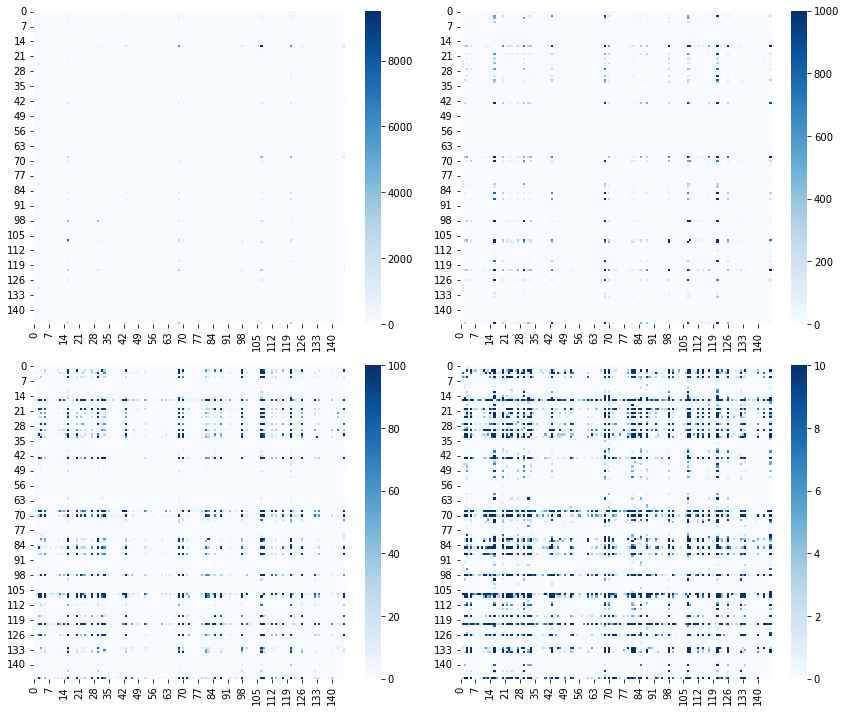

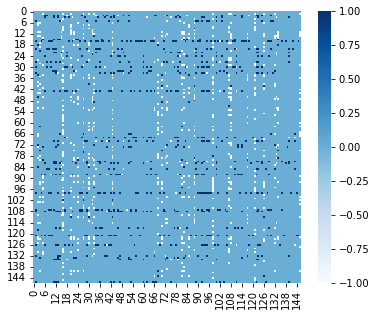

Number of components = 2


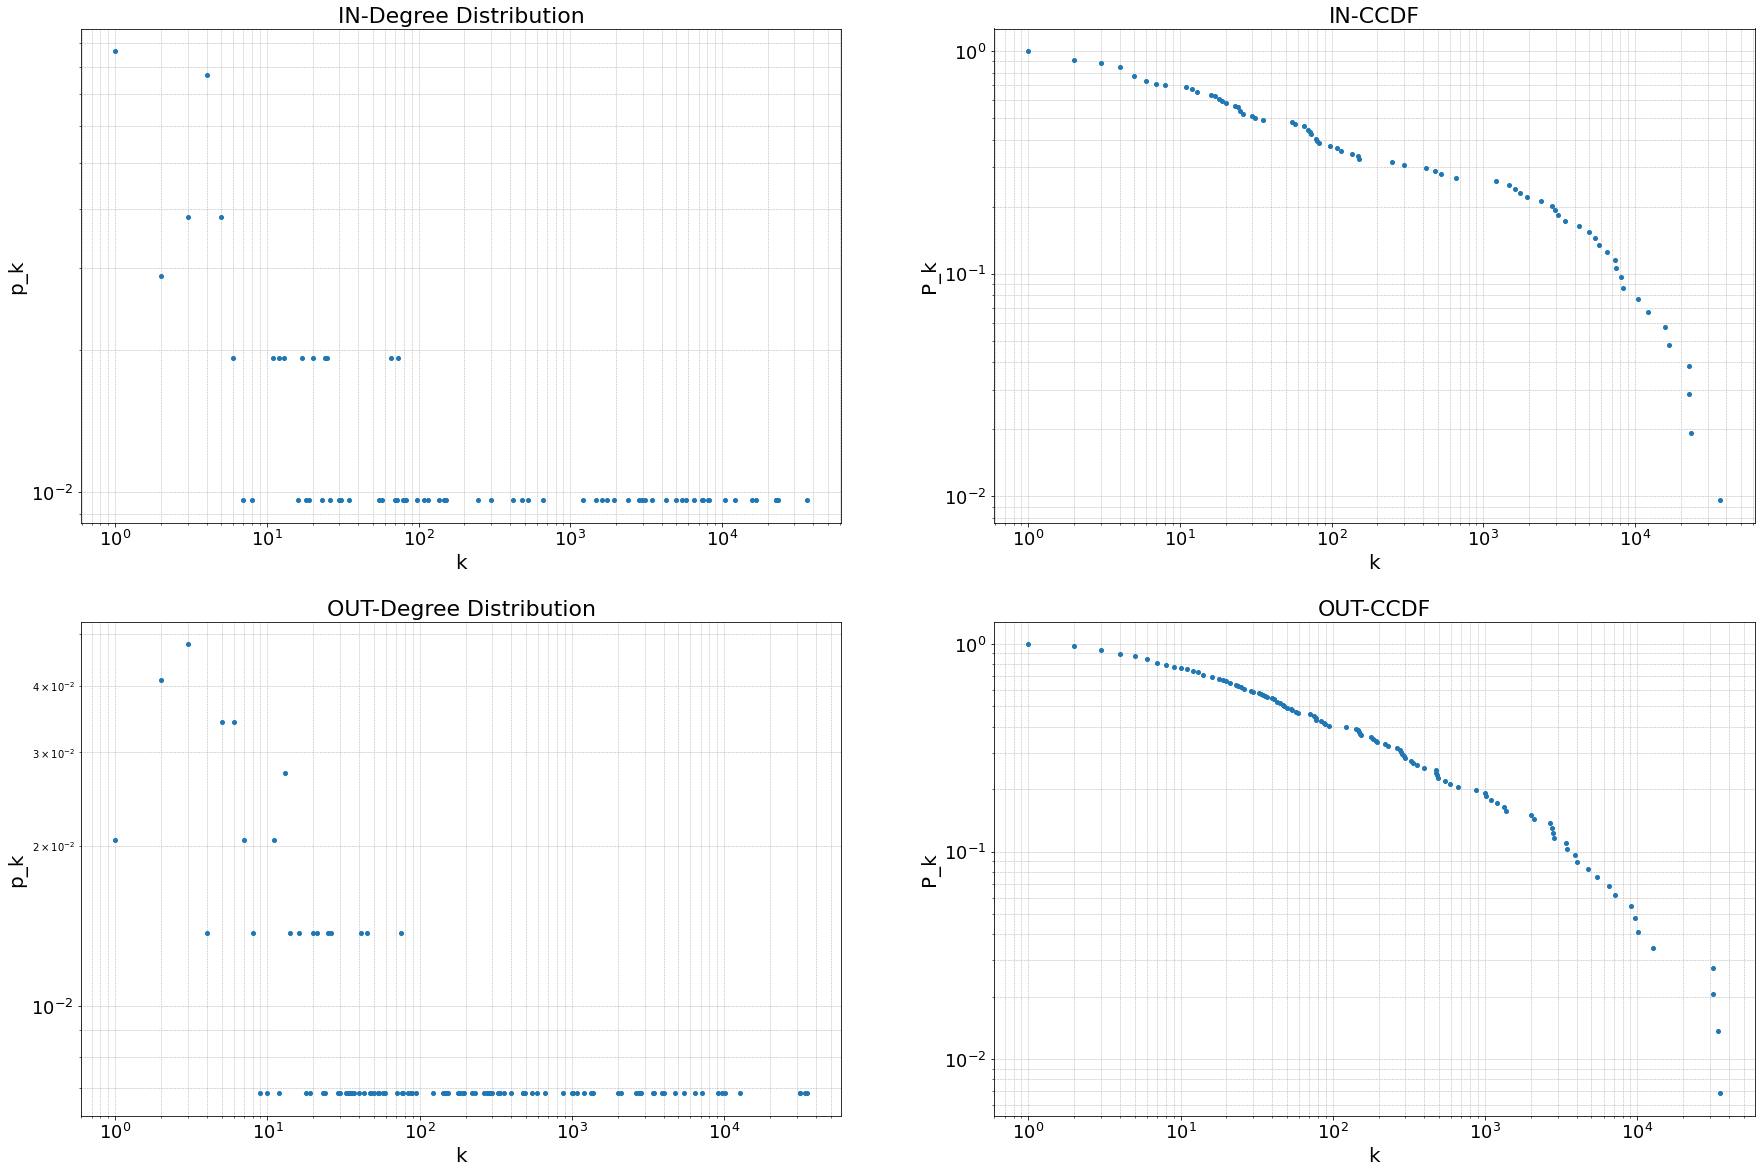

Top 10 for in degree


Nodes  in degree
16         Spain      36263
107        Italy      23344
68        France      22790
121      Germany      22538
146           UK      16849
98        Poland      15750
108     Portugal      12151
43   Netherlands      10510
85        Sweden       8268
70       Czechia       8079

Top 10 for out degree


Nodes  out degree
16         Spain       34913
121      Germany       33931
107        Italy       31591
68        France       31235
30        Turkey       12738
43   Netherlands       10144
98        Poland        9630
146           UK        9086
108     Portugal        7144
126      Belgium        6471

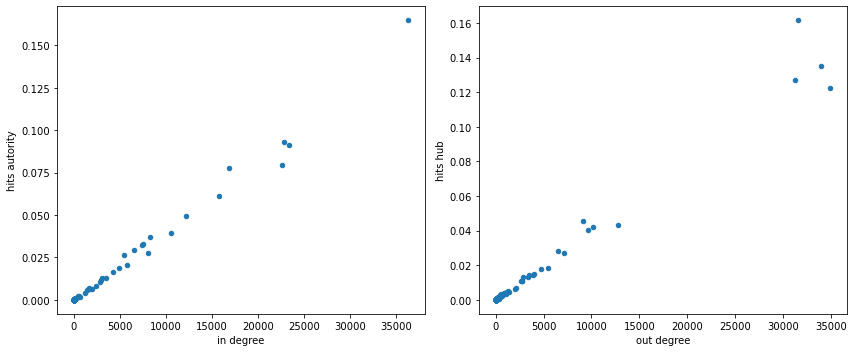

Top 10 for hits hub


Nodes  hits hub
107        Italy  0.161576
121      Germany  0.135408
68        France  0.127085
16         Spain  0.122200
146           UK  0.045554
30        Turkey  0.043050
43   Netherlands  0.042306
98        Poland  0.040657
126      Belgium  0.028275
108     Portugal  0.027016

Top 10 for hits autority


Nodes  hits autority
16         Spain       0.164803
68        France       0.093283
107        Italy       0.091191
121      Germany       0.079345
146           UK       0.077596
98        Poland       0.061080
108     Portugal       0.049354
43   Netherlands       0.039346
85        Sweden       0.036828
88       Finland       0.033024

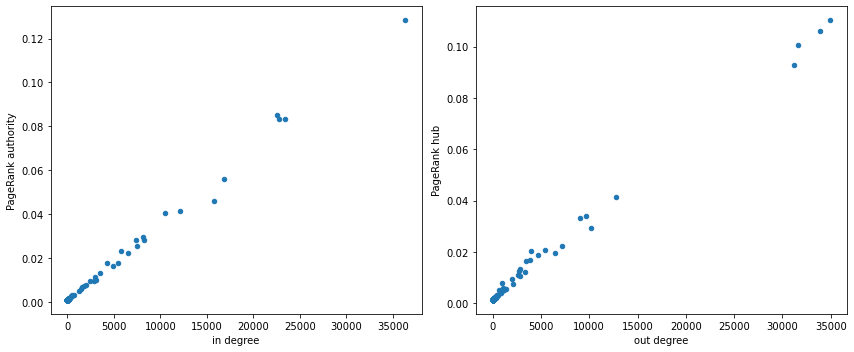

Top 10 for PageRank hub


Nodes  PageRank hub
16         Spain      0.110257
121      Germany      0.105996
107        Italy      0.100815
68        France      0.093048
30        Turkey      0.041473
98        Poland      0.033889
146           UK      0.033424
43   Netherlands      0.029289
108     Portugal      0.022390
70       Czechia      0.020962

Top 10 for PageRank authority


Nodes  PageRank authority
16         Spain            0.128283
121      Germany            0.084965
107        Italy            0.083311
68        France            0.083270
146           UK            0.056150
98        Poland            0.046034
108     Portugal            0.041512
43   Netherlands            0.040408
70       Czechia            0.029744
126      Belgium            0.028452

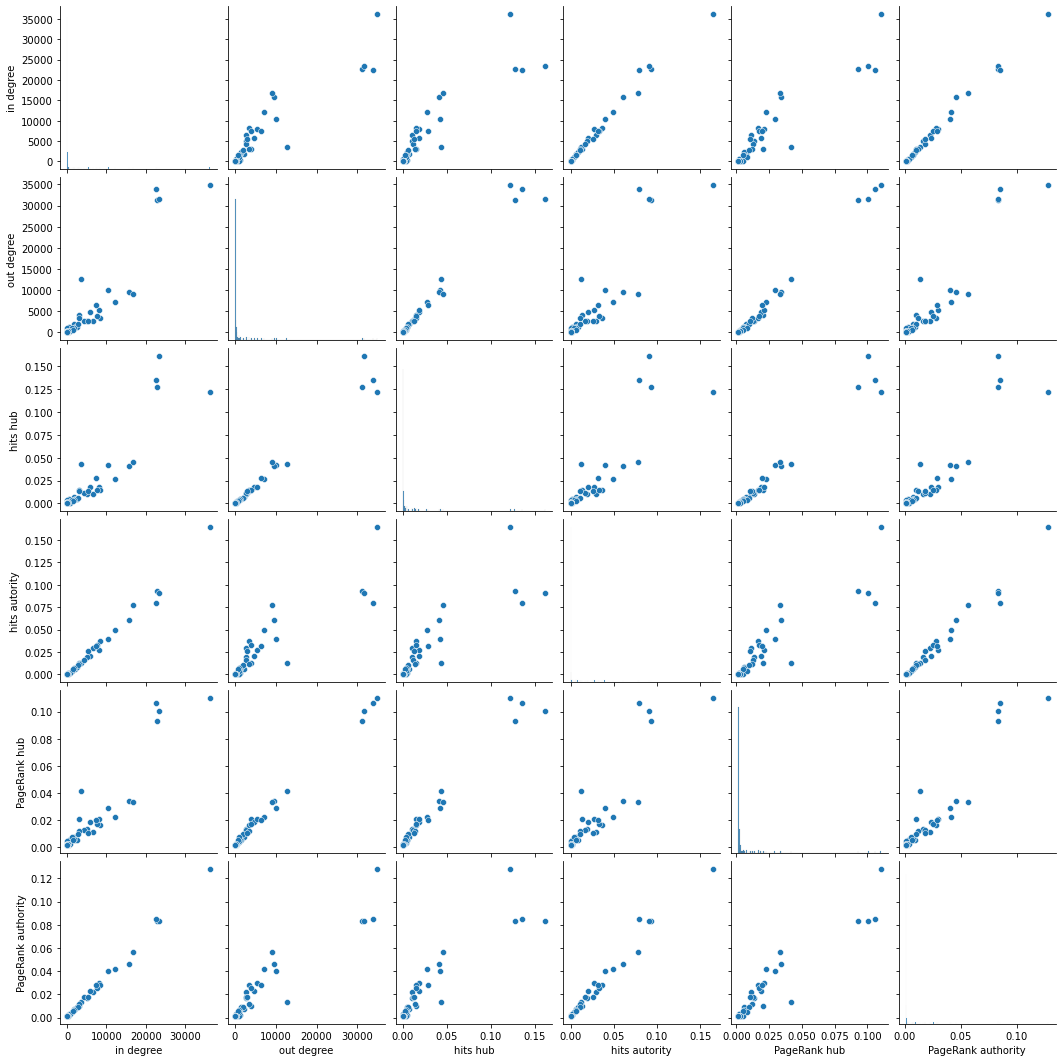

Nodes  in degree  in degree position  hits autority  \
16                Spain      36263                   1       0.164803   
121             Germany      22538                   4       0.079345   
107               Italy      23344                   2       0.091191   
68               France      22790                   3       0.093283   
146                  UK      16849                   5       0.077596   
98               Poland      15750                   6       0.061080   
108            Portugal      12151                   7       0.049354   
43          Netherlands      10510                   8       0.039346   
70              Czechia       8079                  10       0.027760   
126             Belgium       7416                  12       0.032101   
85               Sweden       8268                   9       0.036828   
88              Finland       7517                  11       0.033024   
20              Austria       5808                  14       0.020285   
2                Norway       6494                  13       0.029125   
117             Ireland       5419                  15       0.026383   
32              Denmark       4293                  17       0.016299   
27              Hungary       4948                  16       0.018998   
30               Turkey       3461                  18       0.012586   
33                   EL       2975                  20       0.011472   
3               Romania       3090                  19       0.012937   
81            Lithuania       2826                  21       0.010807   
24             Slovenia       2402                  22       0.008168   
22              Croatia       1949                  23       0.006518   
5              Slovakia       1735                  24       0.006356   
82               Latvia       1615                  25       0.006811   
134             Estonia       1478                  26       0.006028   
132            Bulgaria       1204                  27       0.004279   
133              Cyprus        659                  28       0.001930   
15              Iceland        528                  29       0.002094   
112  Russian Federation        483                  30       0.001973   
72                Malta        421                  31       0.001527   
84               Israel        298                  32       0.001121   
73           Luxembourg        152                  34       0.000671   
23               Serbia        248                  33       0.000994   
80               Canada        115                  37       0.000421   
49        United States        137                  36       0.000587   
143     North Macedonia        148                  35       0.000588   
140              Jordan        109                  38       0.000457   
79                China         70                  46       0.000134   
114             Ukraine         73                  44       0.000168   

     hits autority position  PageRank authority  PageRank authority position  
16                        1            0.128283                            1  
121                       4            0.084965                            2  
107                       3            0.083311                            3  
68                        2            0.083270                            4  
146                       5            0.056150                            5  
98                        6            0.046034                            6  
108                       7            0.041512                            7  
43                        8            0.040408                            8  
70                       13            0.029744                            9  
126                      11            0.028452                           10  
85                        9            0.028061                           11  
88                       10            0.025517                           12

Nodes  out degree  out degree position  hits hub  \
16                    Spain       34913                    1  0.122200   
121                 Germany       33931                    2  0.135408   
107                   Italy       31591                    3  0.161576   
68                   France       31235                    4  0.127085   
30                   Turkey       12738                    5  0.043050   
98                   Poland        9630                    7  0.040657   
146                      UK        9086                    8  0.045554   
43              Netherlands       10144                    6  0.042306   
108                Portugal        7144                    9  0.027016   
70                  Czechia        5412                   11  0.018478   
3                   Romania        4021                   13  0.015054   
126                 Belgium        6471                   10  0.028275   
20                  Austria        4728                   12  0.017966   
88                  Finland        3906                   14  0.014616   
85                   Sweden        3455                   15  0.014486   
27                  Hungary        2794                   18  0.010795   
32                  Denmark        2767                   19  0.011163   
33                       EL        3396                   16  0.013430   
2                    Norway        2651                   20  0.010680   
117                 Ireland        2828                   17  0.013306   
81                Lithuania        1999                   22  0.006061   
132                Bulgaria        1011                   27  0.003661   
5                  Slovakia        2092                   21  0.006650   
82                   Latvia        1086                   26  0.003244   
24                 Slovenia        1367                   23  0.004798   
22                  Croatia        1325                   24  0.005102   
112      Russian Federation        1201                   25  0.004732   
134                 Estonia         669                   30  0.002310   
114                 Ukraine        1004                   28  0.003845   
23                   Serbia         875                   29  0.003816   
42                  Tunisia         587                   31  0.003173   
52                  Georgia         548                   32  0.002217   
100                 Albania         478                   36  0.001829   
14   Bosnia and Herzegovina         487                   34  0.002040   
12                  Morocco         491                   33  0.002553   
73               Luxembourg         479                   35  0.001955   
143         North Macedonia         300                   41  0.000595   
84                   Israel         397                   37  0.001503   
140                  Jordan         327                   40  0.001078   
79                    China         338                   39  0.001296   

     hits hub position  PageRank hub  PageRank hub position  
16                   4      0.110257                      1  
121                  2      0.105996                      2  
107                  1      0.100815                      3  
68                   3      0.093048                      4  
30                   6      0.041473                      5  
98                   8      0.033889                      6  
146                  5      0.033424                      7  
43                   7      0.029289                      8  
108                 10      0.022390                      9  
70                  11      0.020962                     10  
3                   13      0.020560                     11  
126                  9      0.019769                     12  
20                  12      0.018680                     13  
88                  14      0.016837                     14  
85                  15      0.016523                     

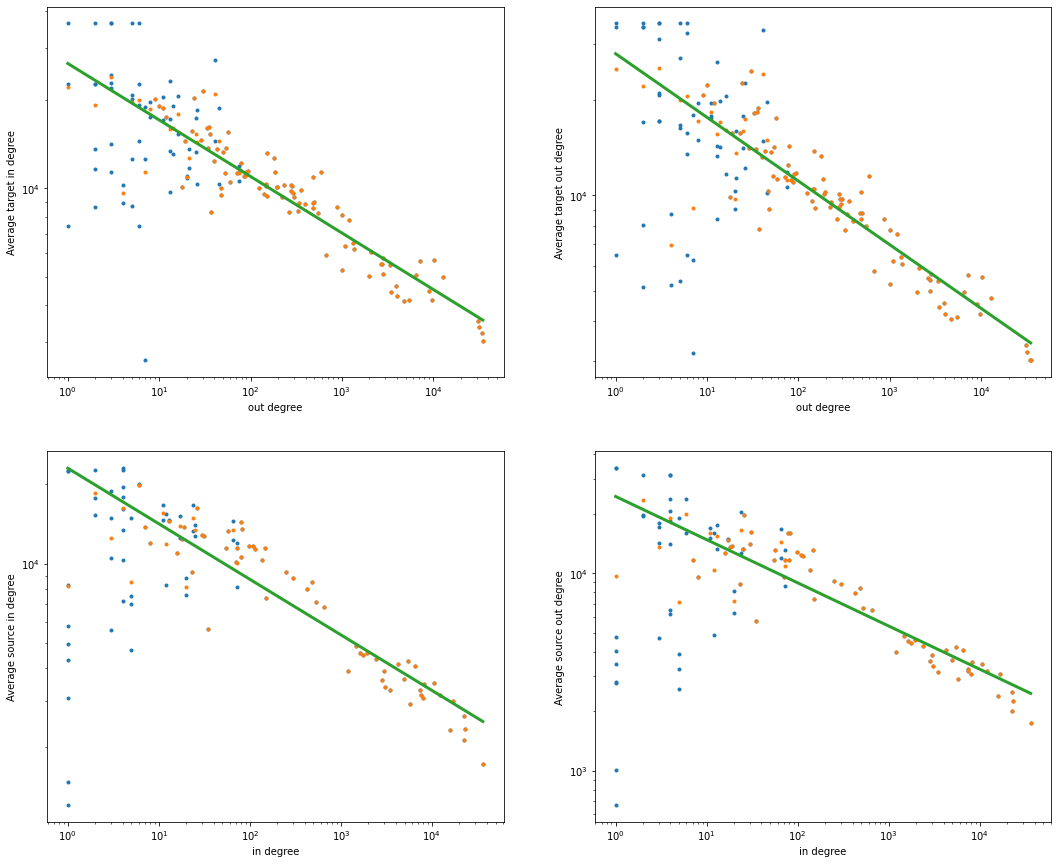

(-0.19190430299796604, -0.201005823903545, -0.2114176952655288, -0.21856149732297478)


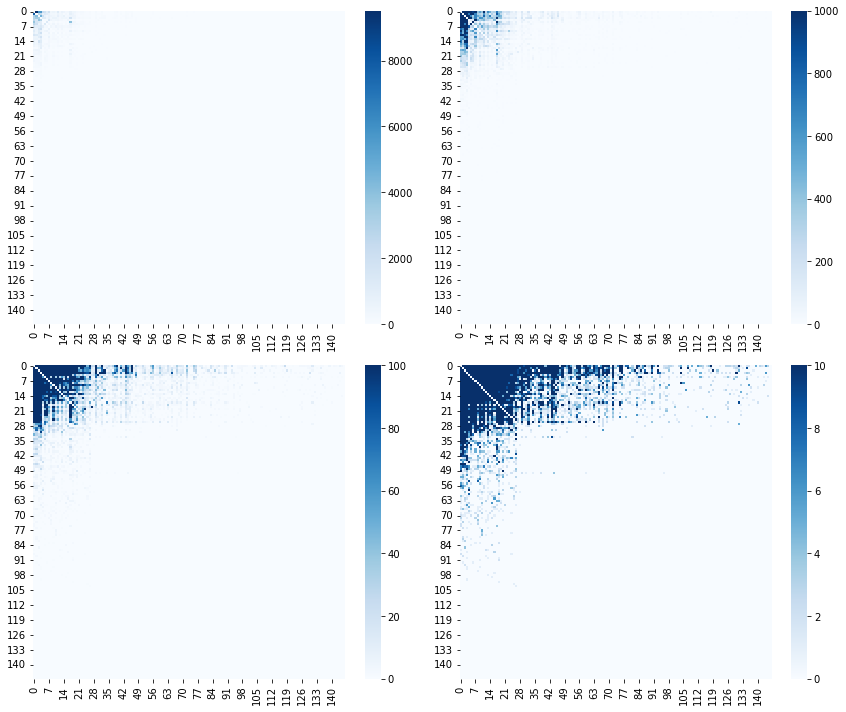

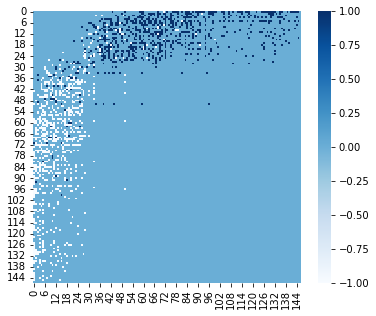

Nodes  Community
1         Uzbekistan          0
3            Romania          0
4               Iraq          0
6       South Africa          0
7           Ethiopia          0
..               ...        ...
135           Rwanda          0
137          Burundi          0
143  North Macedonia          0
144         Paraguay          0
145    Côte d'Ivoire          0

[69 rows x 2 columns]

Nodes  Community
2                              Norway          1
5                            Slovakia          1
10                             Uganda          1
11                                 XK          1
12                            Morocco          1
..                                ...        ...
139  Lao People's Democratic Republic          1
140                            Jordan          1
141                             Gabon          1
142               Trinidad and Tobago          1
146                                UK          1

[57 rows x 2 columns]

Nodes  Community
18   Korea, Republic of          2
21                 Peru          2
30               Turkey          2
36                Kenya          2
37              Nigeria          2
47           Azerbaijan          2
60              Belarus          2
62              Lebanon          2
65               Zambia          2
70              Czechia          2
77             Pakistan          2
81            Lithuania          2
83   Dominican Republic          2
89           Montenegro          2
109               Sudan          2
110               Ghana          2
113             Uruguay          2
116    Papua New Guinea          2
129          Bangladesh          2
136         El Salvador          2

Nodes  Community
0   nan          3

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
13          Turkey                          7107650.0
34         Germany                          2625241.0
39  United Kingdom                          2263020.0
30           Italy                          1797986.0
6            Spain                          1491419.0
28          Poland                          1418588.0
16     Netherlands                           720583.0
15          Greece                           704969.0
25          Sweden                           438578.0
31        Portugal                           323467.0

country  weight_pr_hub
0       Luxembourg   2.000000e-07
1    Liechtenstein   2.000000e-07
2            Malta   1.672427e-07
3          Romania   1.524939e-07
4          Estonia   1.133660e-07
5         Slovenia   1.086155e-07
6          Belgium   8.570608e-08
7        Lithuania   8.260642e-08
8           Latvia   7.601893e-08
9            Spain   7.392743e-08
10         Czechia   7.067111e-08
11        Portugal   6.921876e-08
12        Slovakia   6.734856e-08
13         Finland   6.085745e-08
14       Macedonia   5.703170e-08
15           Italy   5.607120e-08
16         Ireland   5.241397e-08
17         Denmark   4.944061e-08
18         Hungary   4.859938e-08
19          Norway   4.116854e-08
20     Netherlands   4.064640e-08
21         Germany   4.037578e-08
22          Sweden   3.767413e-08
23         Croatia   3.531952e-08
24        Bulgaria   3.376328e-08
25          Poland   2.388935e-08
26         Albania   2.317336e-08
27          Greece   1.729928e-08
28          Serbia   1.722992e-08
29  United Kingdom   1.476970e-08
30          Turkey   5.834922e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0       Luxembourg   2.000000e-07
1    Liechtenstein   2.000000e-07
2            Malta   1.939959e-07
3         Slovenia   1.797711e-07
4          Estonia   1.334071e-07
5         Portugal   1.283355e-07
6          Belgium   1.233476e-07
7          Czechia   1.002792e-07
8          Finland   9.223439e-08
9          Ireland   8.955316e-08
10          Latvia   8.858606e-08
11           Spain   8.601409e-08
12       Lithuania   8.334065e-08
13          Norway   8.292957e-08
14         Romania   7.377618e-08
15         Denmark   6.832701e-08
16        Slovakia   6.433085e-08
17          Sweden   6.398171e-08
18         Hungary   5.923545e-08
19     Netherlands   5.607658e-08
20         Croatia   4.713820e-08
21           Italy   4.633587e-08
22          Poland   3.245045e-08
23         Germany   3.236449e-08
24       Macedonia   2.937487e-08
25  United Kingdom   2.481206e-08
26        Bulgaria   2.253805e-08
27          Greece   1.629953e-08
28         Albania   9.170029e-09
29          Serbia   7.748081e-09
30          Turkey   1.866223e-09
31     Switzerland   0.000000e+00

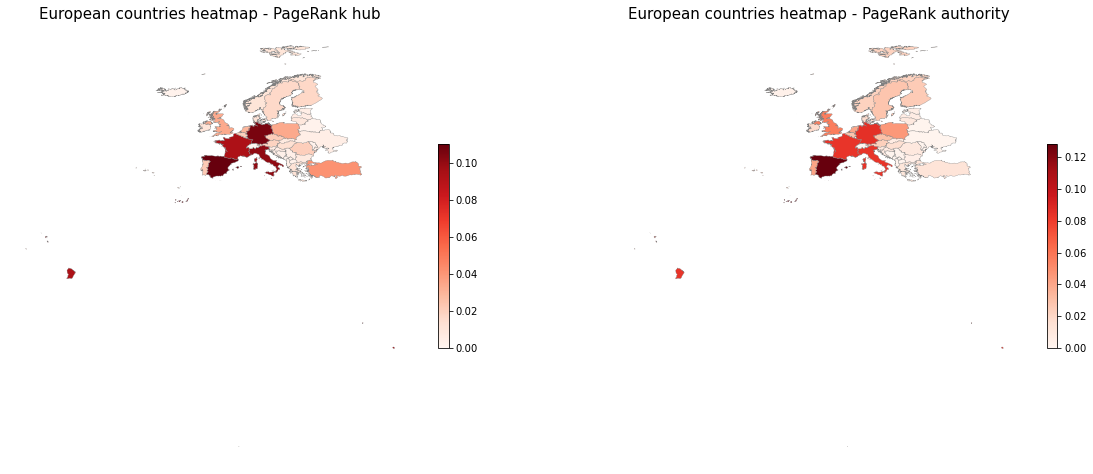

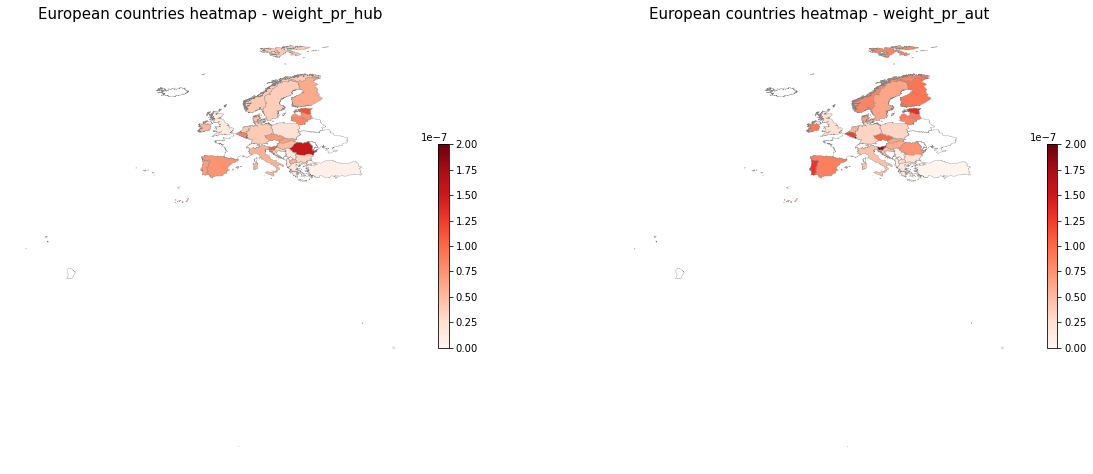

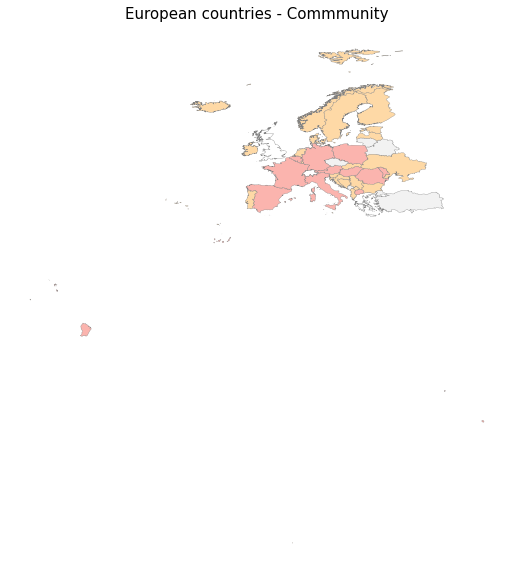

In [4]:
country19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country19_df)

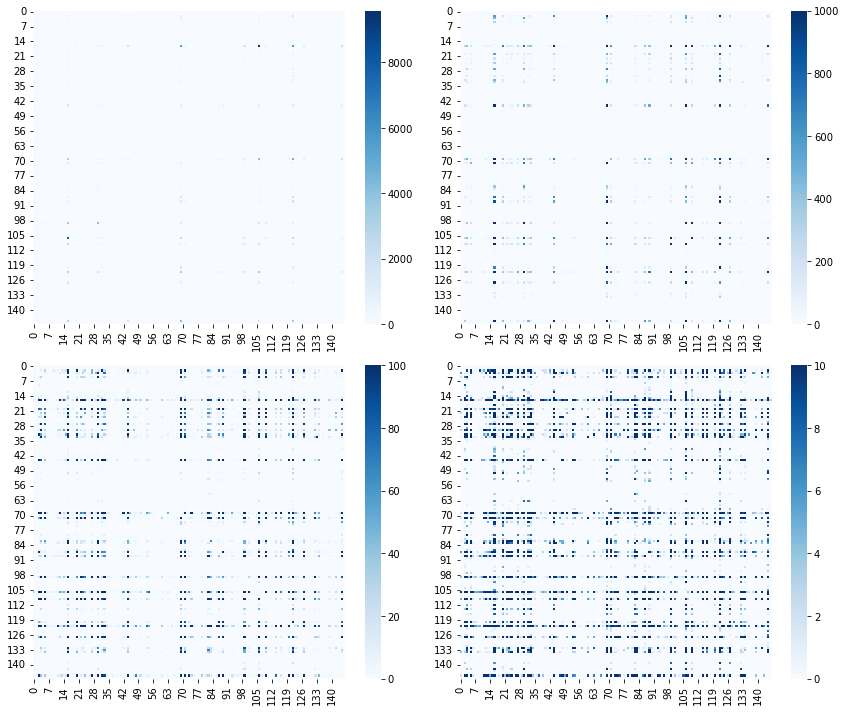

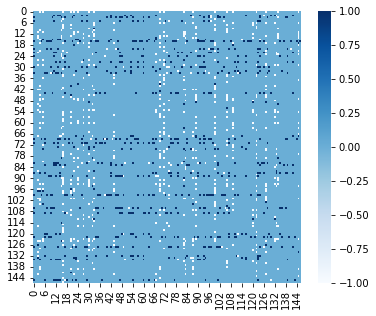

Number of components = 2


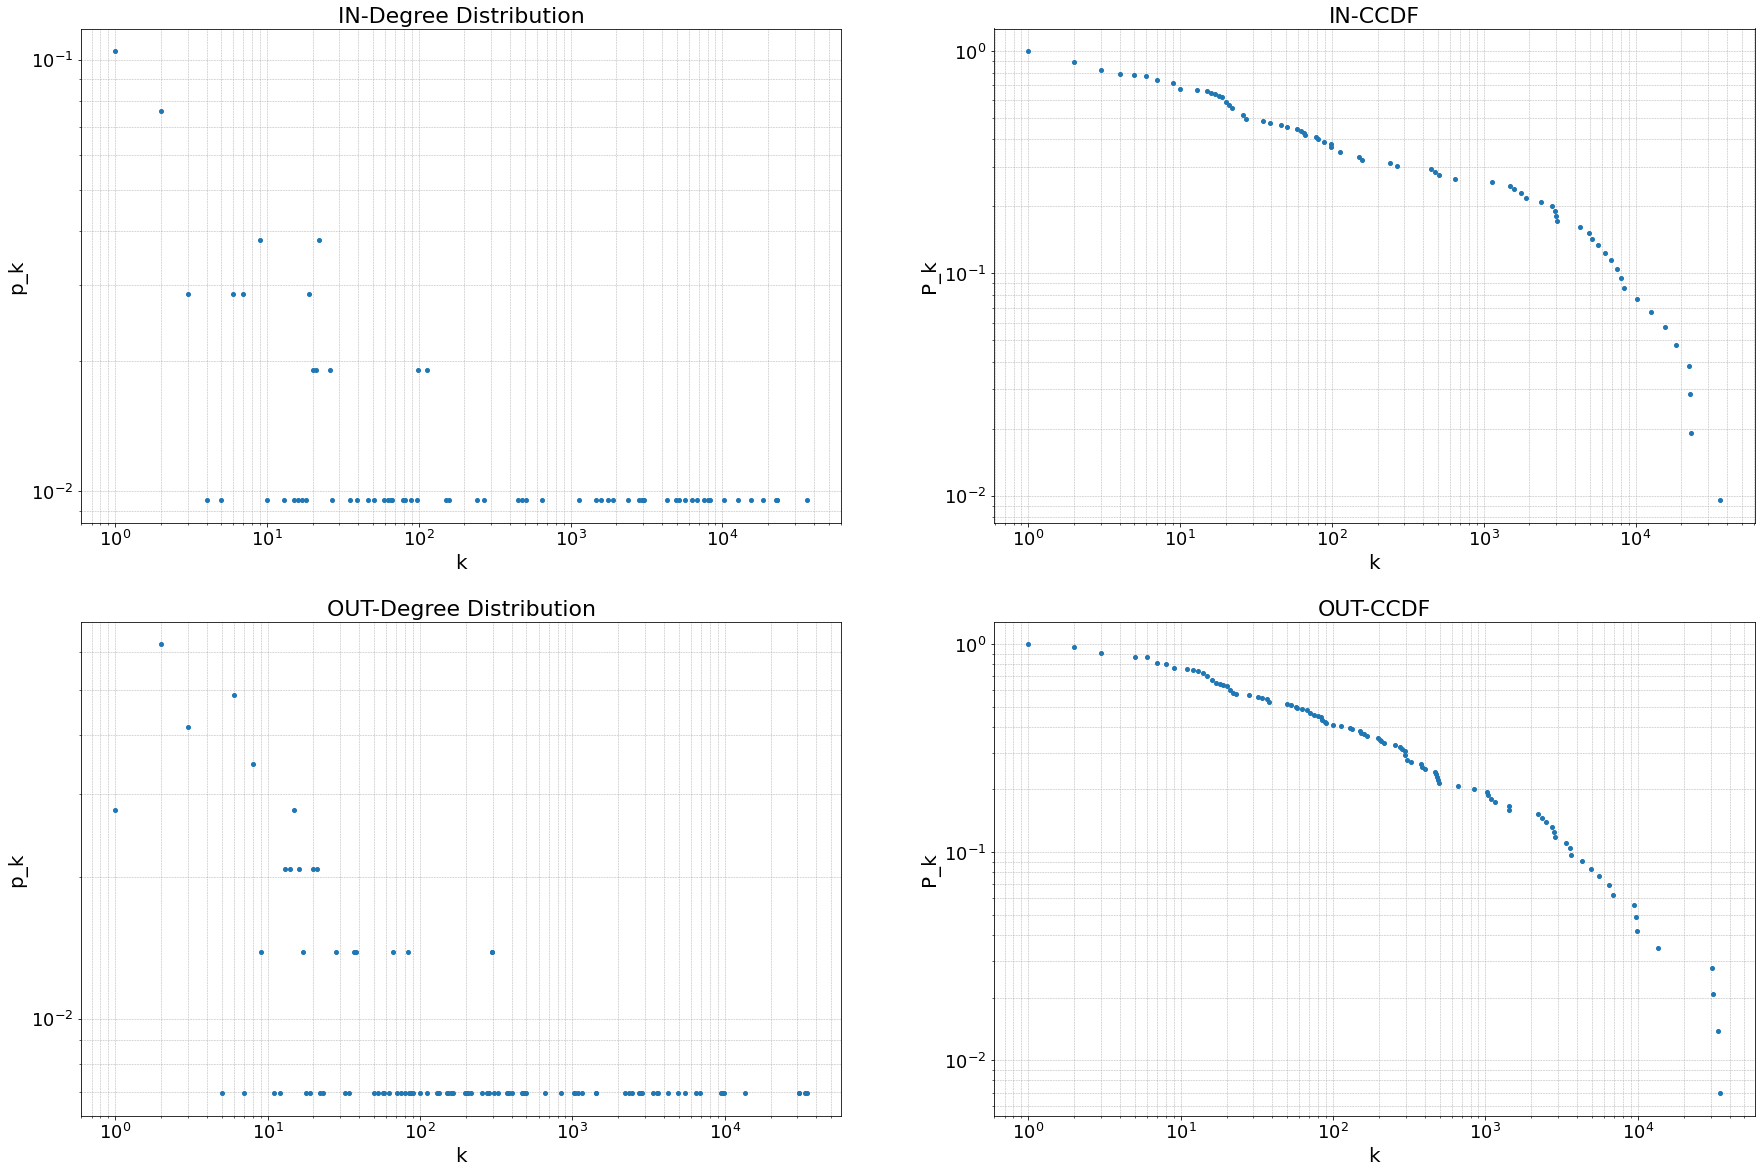

Top 10 for in degree


Nodes  in degree
16         Spain      36020
69        France      23047
122      Germany      22906
106        Italy      22627
145           UK      18474
99        Poland      15539
109     Portugal      12585
44   Netherlands      10198
71       Czechia       8342
87        Sweden       8079

Top 10 for out degree


Nodes  out degree
16         Spain       34630
122      Germany       33780
106        Italy       30947
69        France       30554
30        Turkey       13510
44   Netherlands        9843
99        Poland        9775
145           UK        9395
109     Portugal        6862
127      Belgium        6511

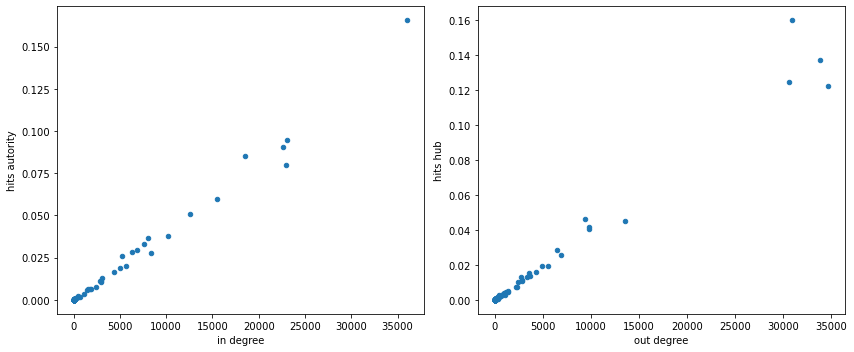

Top 10 for hits hub


Nodes  hits hub
106        Italy  0.160041
122      Germany  0.137508
69        France  0.124890
16         Spain  0.122369
145           UK  0.046538
30        Turkey  0.045017
44   Netherlands  0.041869
99        Poland  0.040729
127      Belgium  0.028681
109     Portugal  0.025886

Top 10 for hits autority


Nodes  hits autority
16         Spain       0.165548
69        France       0.094907
106        Italy       0.090780
145           UK       0.085221
122      Germany       0.079958
99        Poland       0.059830
109     Portugal       0.050634
44   Netherlands       0.037921
87        Sweden       0.036803
89       Finland       0.033260

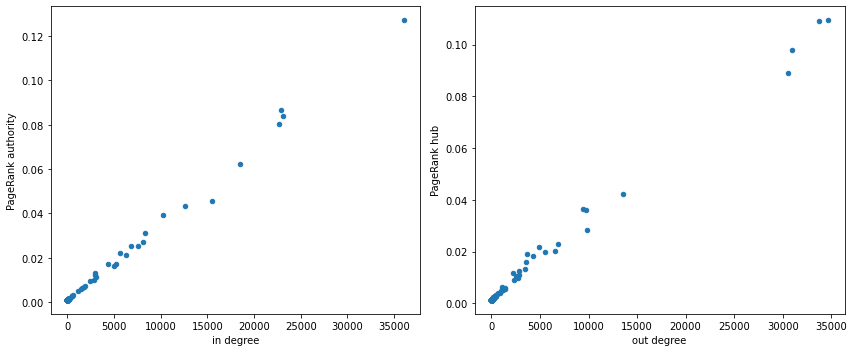

Top 10 for PageRank hub


Nodes  PageRank hub
16         Spain      0.109364
122      Germany      0.109099
106        Italy      0.097924
69        France      0.089084
30        Turkey      0.042240
145           UK      0.036373
99        Poland      0.036089
44   Netherlands      0.028372
109     Portugal      0.023053
20       Austria      0.021770

Top 10 for PageRank authority


Nodes  PageRank authority
16         Spain            0.127053
122      Germany            0.086534
69        France            0.083933
106        Italy            0.080115
145           UK            0.062336
99        Poland            0.045379
109     Portugal            0.043211
44   Netherlands            0.039211
71       Czechia            0.031170
87        Sweden            0.027315

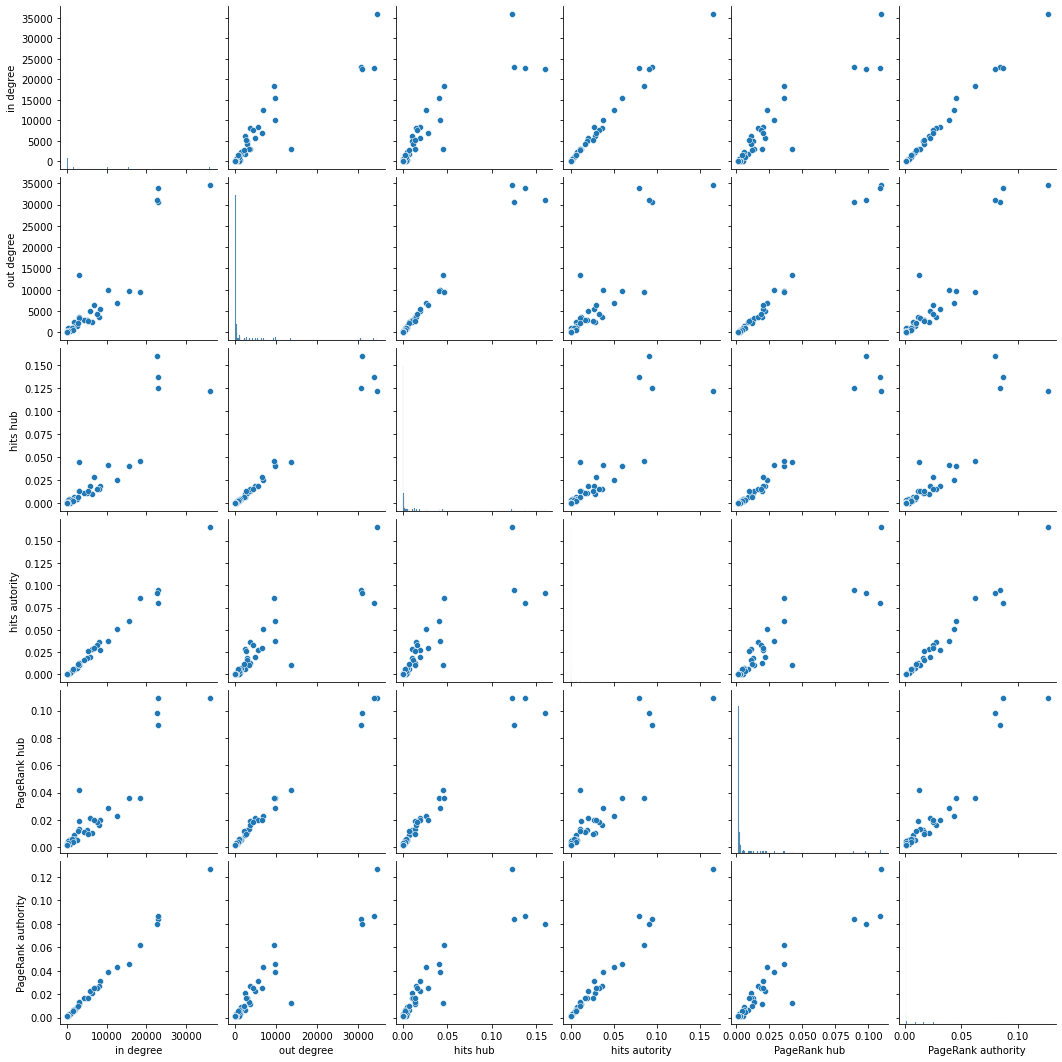

Nodes  in degree  in degree position  hits autority  \
16                    Spain      36020                   1       0.165548   
122                 Germany      22906                   3       0.079958   
69                   France      23047                   2       0.094907   
106                   Italy      22627                   4       0.090780   
145                      UK      18474                   5       0.085221   
99                   Poland      15539                   6       0.059830   
109                Portugal      12585                   7       0.050634   
44              Netherlands      10198                   8       0.037921   
71                  Czechia       8342                   9       0.027543   
87                   Sweden       8079                  10       0.036803   
89                  Finland       7590                  11       0.033260   
127                 Belgium       6846                  12       0.029684   
20                  Austria       5666                  14       0.019946   
2                    Norway       6282                  13       0.028431   
120                 Ireland       5184                  15       0.025973   
32                  Denmark       4315                  17       0.016555   
27                  Hungary       4970                  16       0.018853   
33                       EL       3001                  19       0.010903   
30                   Turkey       2952                  20       0.010592   
3                   Romania       3058                  18       0.012703   
82                Lithuania       2835                  21       0.011192   
24                 Slovenia       2378                  22       0.007568   
22                  Croatia       1909                  23       0.006136   
5                  Slovakia       1763                  24       0.006463   
83                   Latvia       1587                  25       0.006606   
134                 Estonia       1479                  26       0.005960   
132                Bulgaria       1129                  27       0.003655   
133                  Cyprus        650                  28       0.001940   
15                  Iceland        510                  29       0.002093   
73                    Malta        453                  31       0.001687   
114      Russian Federation        475                  30       0.001612   
86                   Israel        268                  32       0.000985   
23                   Serbia        242                  33       0.000875   
50            United States        157                  34       0.000696   
74               Luxembourg        152                  35       0.000693   
14   Bosnia and Herzegovina        113                  36       0.000367   
79                    China         79                  43       0.000147   
81                   Canada         89                  41       0.000308   
116                 Ukraine         98                  40       0.000297   
142         North Macedonia        113                  37       0.000405   

     hits autority position  PageRank authority  PageRank authority position  
16                        1            0.127053                            1  
122                       5            0.086534                            2  
69                        2            0.083933                            3  
106                       3            0.080115                            4  
145                       4            0.062336                            5  
99                        6            0.045379                            6  
109                       7            0.043211                            7  
44                        8            0.039211                            8  
71                       13            0.031170                            9  
87                        9            0.027315                           

Nodes  out degree  out degree position  hits hub  \
16                    Spain       34630                    1  0.122369   
122                 Germany       33780                    2  0.137508   
106                   Italy       30947                    3  0.160041   
69                   France       30554                    4  0.124890   
30                   Turkey       13510                    5  0.045017   
145                      UK        9395                    8  0.046538   
99                   Poland        9775                    7  0.040729   
44              Netherlands        9843                    6  0.041869   
109                Portugal        6862                    9  0.025886   
20                  Austria        4938                   12  0.019161   
127                 Belgium        6511                   10  0.028681   
71                  Czechia        5527                   11  0.019247   
3                   Romania        3646                   14  0.013879   
89                  Finland        4275                   13  0.016044   
87                   Sweden        3574                   15  0.015303   
33                       EL        3404                   16  0.013223   
27                  Hungary        2882                   17  0.010898   
82                Lithuania        2205                   22  0.007061   
32                  Denmark        2811                   18  0.011598   
2                    Norway        2481                   20  0.010131   
120                 Ireland        2736                   19  0.013247   
5                  Slovakia        2345                   21  0.007096   
132                Bulgaria        1085                   26  0.003823   
22                  Croatia        1435                   23  0.005140   
83                   Latvia        1041                   27  0.002953   
24                 Slovenia        1423                   24  0.004711   
114      Russian Federation        1158                   25  0.004444   
116                 Ukraine        1026                   28  0.003747   
134                 Estonia         660                   30  0.002223   
23                   Serbia         839                   29  0.003316   
14   Bosnia and Herzegovina         477                   34  0.001881   
12                  Morocco         489                   32  0.002320   
74               Luxembourg         495                   31  0.002038   
42                  Tunisia         483                   33  0.002575   
101                 Albania         403                   36  0.001405   
53                  Georgia         465                   35  0.001763   
142         North Macedonia         323                   39  0.000654   
86                   Israel         375                   38  0.001396   
79                    China         382                   37  0.001375   
11                       XK         277                   46  0.000855   

     hits hub position  PageRank hub  PageRank hub position  
16                   4      0.109364                      1  
122                  2      0.109099                      2  
106                  1      0.097924                      3  
69                   3      0.089084                      4  
30                   6      0.042240                      5  
145                  5      0.036373                      6  
99                   8      0.036089                      7  
44                   7      0.028372                      8  
109                 10      0.023053                      9  
20                  12      0.021770                     10  
127                  9      0.020250                     11  
71                  11      0.019907                     12  
3                   15      0.019066                     13  
89                  13      0.018470                     14  
87                  14      0.016030                     

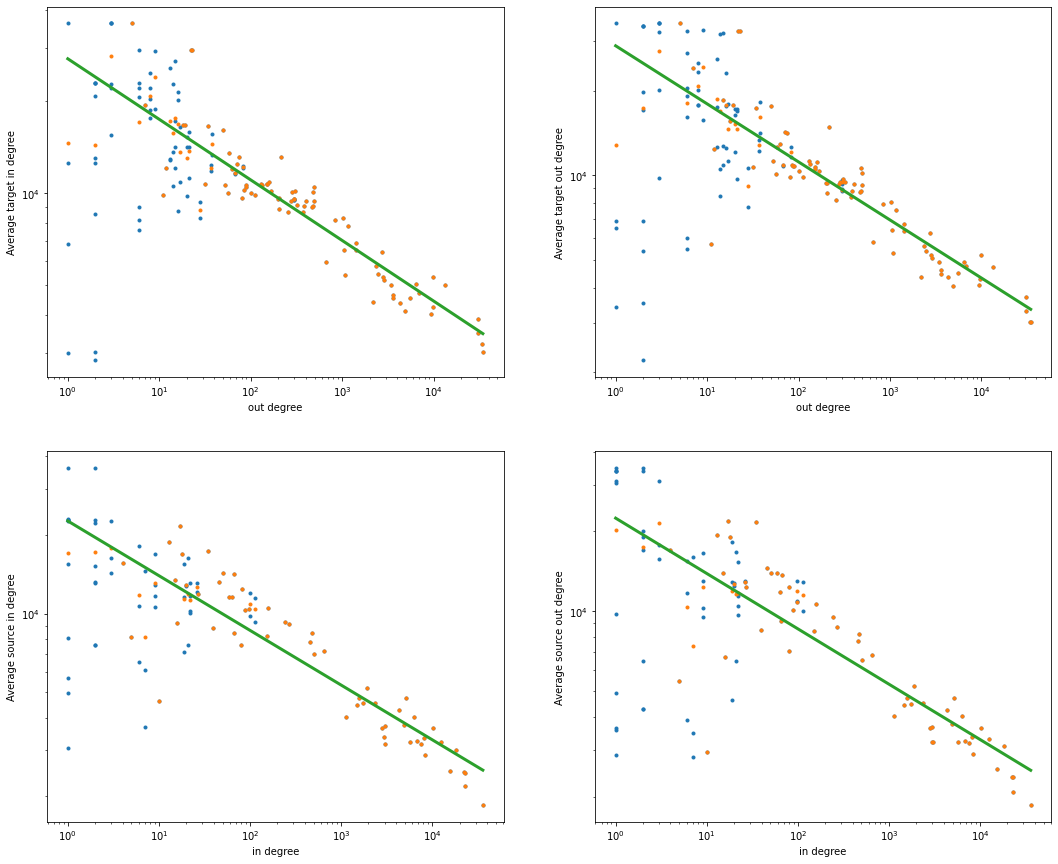

(-0.19839347404635532, -0.20604484181819913, -0.20917415960303473, -0.20856165223470094)


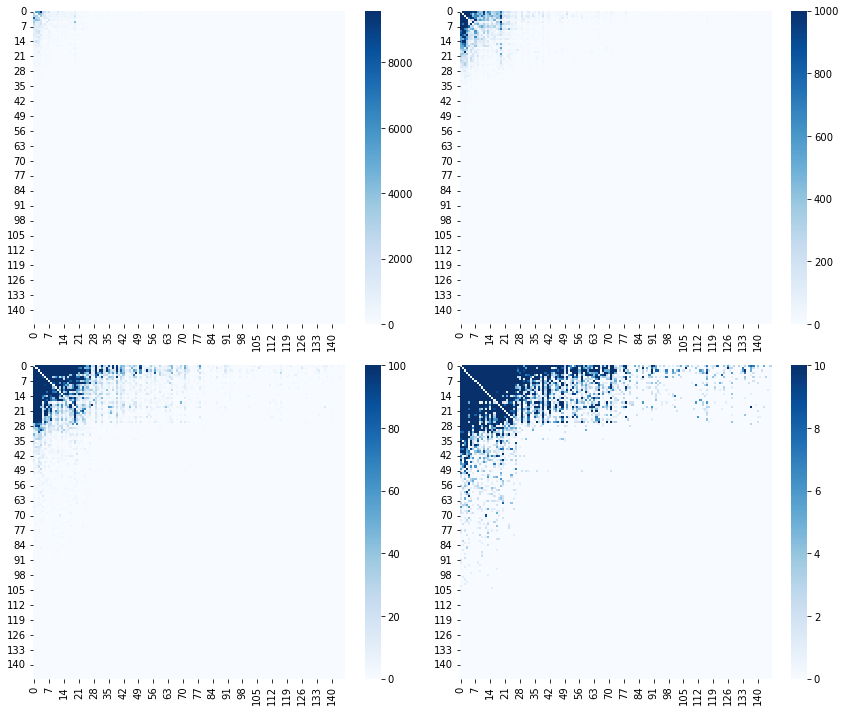

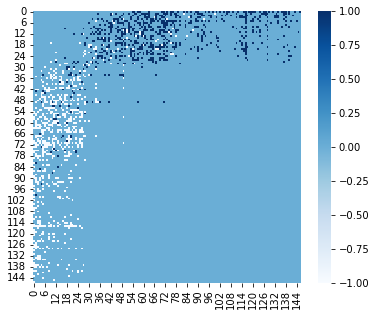

Nodes  Community
4                   Iraq          0
7               Ethiopia          0
8                Myanmar          0
9                  Nepal          0
16                 Spain          0
..                   ...        ...
140                Gabon          0
141  Trinidad and Tobago          0
143             Paraguay          0
144        Côte d'Ivoire          0
146           Mauritania          0

[47 rows x 2 columns]

Nodes  Community
0                      Uzbekistan          1
2                          Norway          1
5                        Slovakia          1
13            Palestine, State of          1
14         Bosnia and Herzegovina          1
..                            ...        ...
130  Tanzania, United Republic of          1
133                        Cyprus          1
134                       Estonia          1
142               North Macedonia          1
145                            UK          1

[44 rows x 2 columns]

Nodes  Community
11                   XK          2
12              Morocco          2
18   Korea, Republic of          2
19              Ecuador          2
24             Slovenia          2
30               Turkey          2
32              Denmark          2
48                Egypt          2
49            Hong Kong          2
53              Georgia          2
59                 Fiji          2
60              Belarus          2
63              Lebanon          2
68               Malawi          2
82            Lithuania          2
83               Latvia          2
84   Dominican Republic          2
85               Panama          2
89              Finland          2
92          Afghanistan          2
107            Malaysia          2
110               Ghana          2
111               Sudan          2
112               Japan          2
120             Ireland          2
124               India          2
125              Gambia          2
129          Bangladesh          2
132            Bulgaria          2
135         El Salvador          2
137               Libya          2
139              Jordan          2

Nodes  Community
3                              Romania          3
6                         South Africa          3
10                              Uganda          3
26                           Argentina          3
33                                  EL          3
45                             Algeria          3
51   Venezuela, Bolivarian Republic of          3
75                               Chile          3
80                   Brunei Darussalam          3
113                           Botswana          3
128                         Tajikistan          3
131                          Mauritius          3

Nodes  Community
21               Peru          4
27            Hungary          4
36              Kenya          4
41             Bhutan          4
50      United States          4
54           Viet Nam          4
57           Mongolia          4
71            Czechia          4
76         Cabo Verde          4
101           Albania          4
118  Papua New Guinea          4

Nodes  Community
1   nan          5

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
13          Turkey                          7107650.0
34         Germany                          2625241.0
39  United Kingdom                          2263020.0
30           Italy                          1797986.0
6            Spain                          1491419.0
28          Poland                          1418588.0
16     Netherlands                           720583.0
15          Greece                           704969.0
25          Sweden                           438578.0
31        Portugal                           323467.0

country  weight_pr_hub
0       Luxembourg   2.000000e-07
1    Liechtenstein   2.000000e-07
2            Malta   1.615868e-07
3          Romania   1.414166e-07
4         Slovenia   1.030543e-07
5        Lithuania   1.022671e-07
6          Estonia   8.887769e-08
7          Belgium   8.779008e-08
8         Slovakia   7.930057e-08
9            Spain   7.332851e-08
10        Portugal   7.126727e-08
11          Latvia   7.101621e-08
12         Czechia   6.711531e-08
13         Finland   6.676041e-08
14       Macedonia   5.806861e-08
15           Italy   5.446309e-08
16         Ireland   4.884346e-08
17         Hungary   4.561838e-08
18         Denmark   4.274294e-08
19         Germany   4.155758e-08
20          Norway   3.944553e-08
21     Netherlands   3.937320e-08
22          Sweden   3.655081e-08
23         Croatia   3.602993e-08
24        Bulgaria   2.691932e-08
25          Poland   2.544010e-08
26         Albania   2.126780e-08
27          Greece   1.865586e-08
28          Serbia   1.685233e-08
29  United Kingdom   1.607281e-08
30          Turkey   5.942914e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0       Luxembourg   2.000000e-07
1            Malta   2.000000e-07
2    Liechtenstein   2.000000e-07
3         Slovenia   1.786941e-07
4         Portugal   1.335861e-07
5          Estonia   1.274242e-07
6          Belgium   1.090200e-07
7          Czechia   1.050861e-07
8          Finland   9.145925e-08
9        Lithuania   8.721573e-08
10         Ireland   8.541925e-08
11           Spain   8.518949e-08
12         Romania   8.489857e-08
13          Latvia   8.304045e-08
14          Norway   7.848664e-08
15         Denmark   6.669199e-08
16          Sweden   6.228195e-08
17        Slovakia   6.162832e-08
18         Hungary   5.913845e-08
19     Netherlands   5.441618e-08
20         Croatia   4.670279e-08
21           Italy   4.455839e-08
22         Germany   3.296214e-08
23          Poland   3.198902e-08
24       Macedonia   2.788566e-08
25  United Kingdom   2.754530e-08
26        Bulgaria   2.239988e-08
27          Greece   1.860285e-08
28         Albania   8.482448e-09
29          Serbia   7.707365e-09
30          Turkey   1.743374e-09
31     Switzerland   0.000000e+00

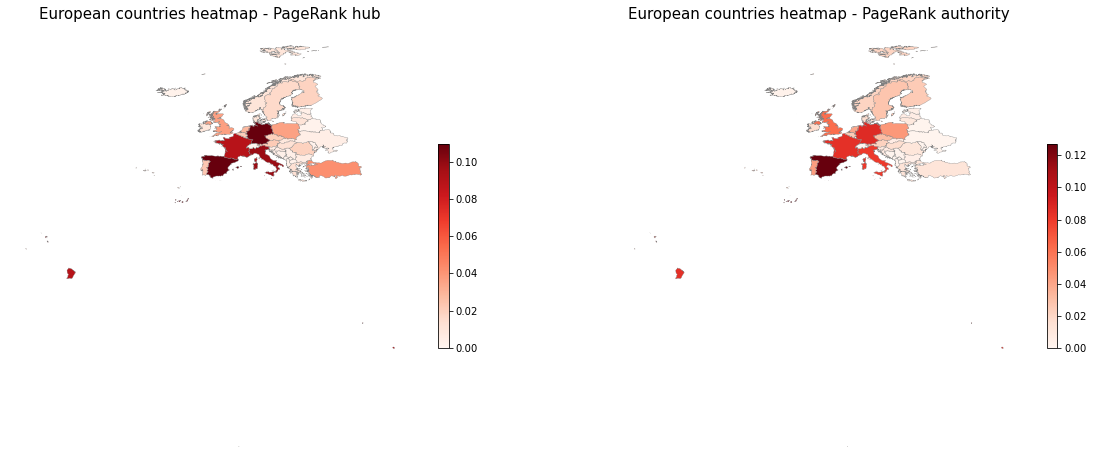

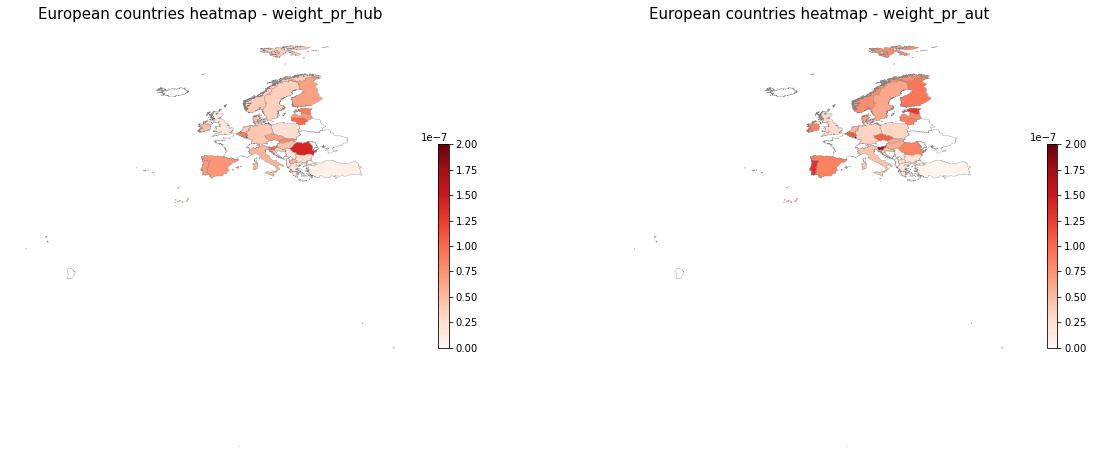

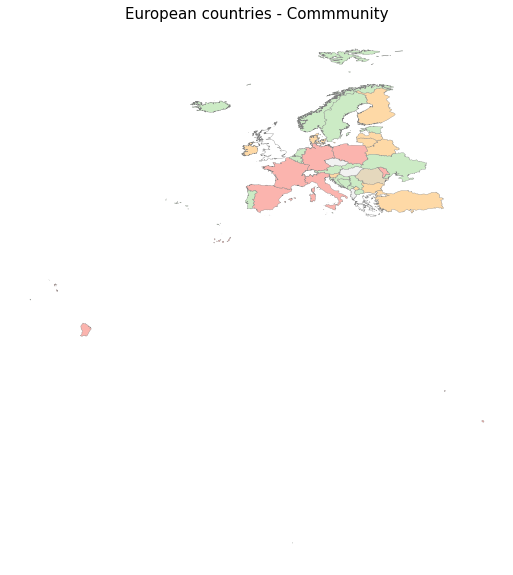

In [5]:
country18_df = pd.read_csv('data\Erasmus18.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country18_df)

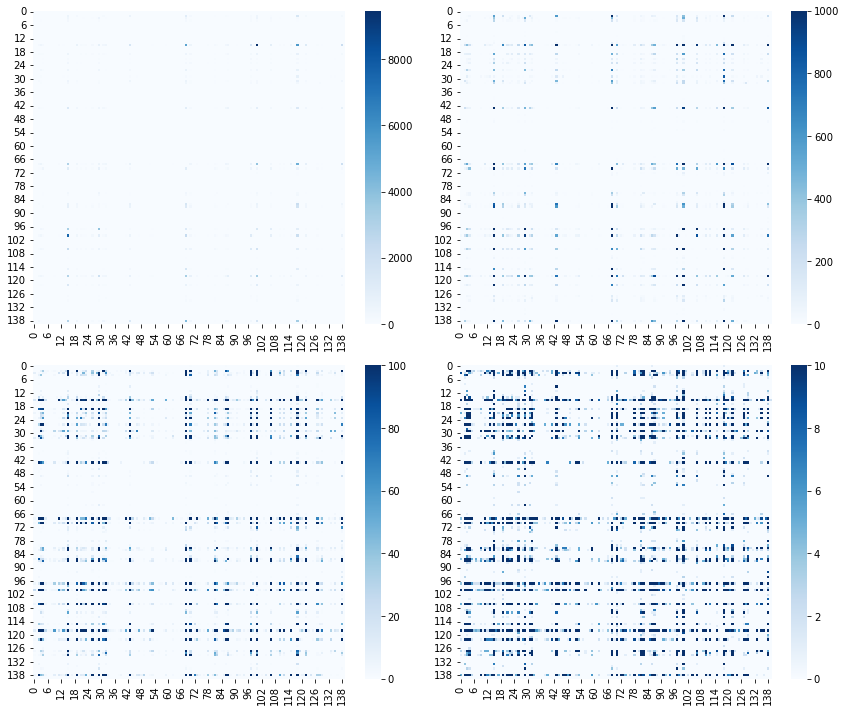

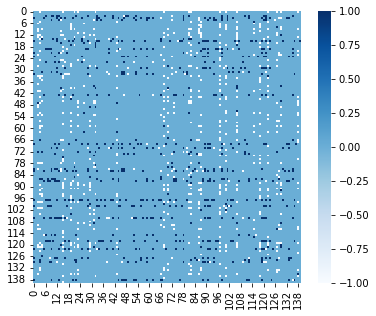

Number of components = 2


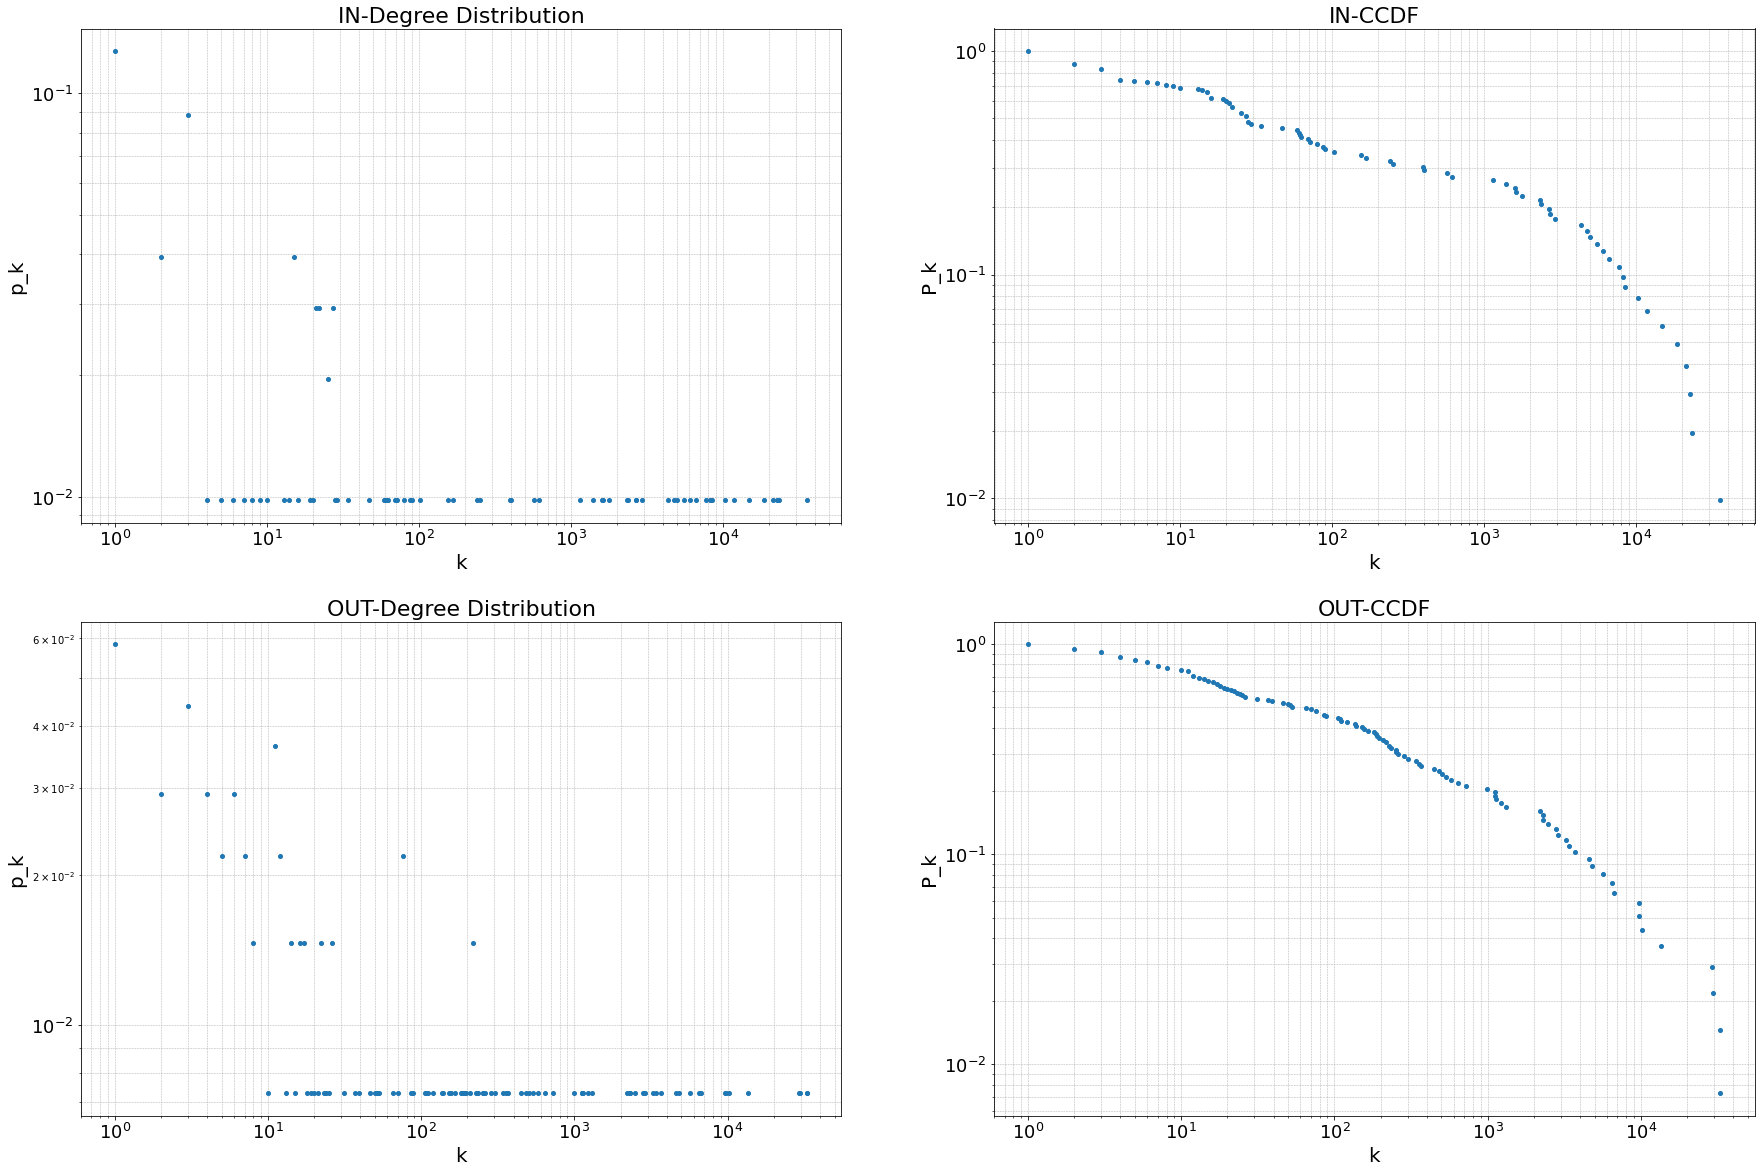

Top 10 for in degree


Nodes  in degree
15         Spain      35605
118      Germany      23161
68        France      22577
100        Italy      21364
138           UK      18668
97        Poland      14837
106     Portugal      11764
43   Netherlands      10325
86        Sweden       8497
70       Czechia       8191

Top 10 for out degree


Nodes  out degree
15         Spain       32975
118      Germany       32916
68        France       29867
100        Italy       29261
29        Turkey       13546
97        Poland       10157
43   Netherlands        9806
138           UK        9681
122      Belgium        6723
106     Portugal        6520

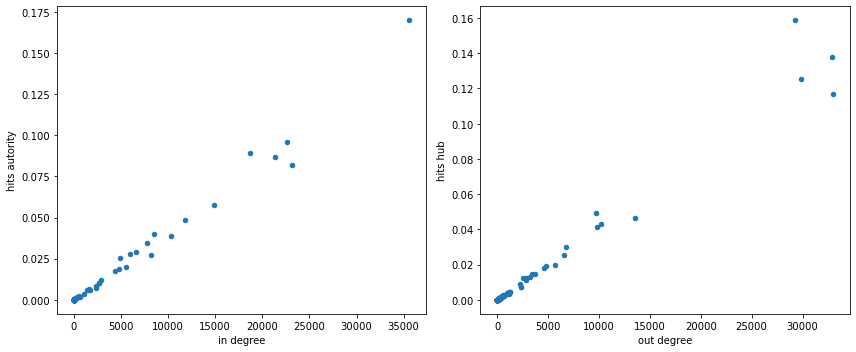

Top 10 for hits hub


Nodes  hits hub
100        Italy  0.158669
118      Germany  0.138050
68        France  0.125551
15         Spain  0.117020
138           UK  0.049037
29        Turkey  0.046440
97        Poland  0.042947
43   Netherlands  0.041421
122      Belgium  0.030267
106     Portugal  0.025288

Top 10 for hits autority


Nodes  hits autority
15         Spain       0.169761
68        France       0.095757
138           UK       0.088944
100        Italy       0.086551
118      Germany       0.082129
97        Poland       0.057782
106     Portugal       0.048229
86        Sweden       0.040013
43   Netherlands       0.039021
87       Finland       0.034659

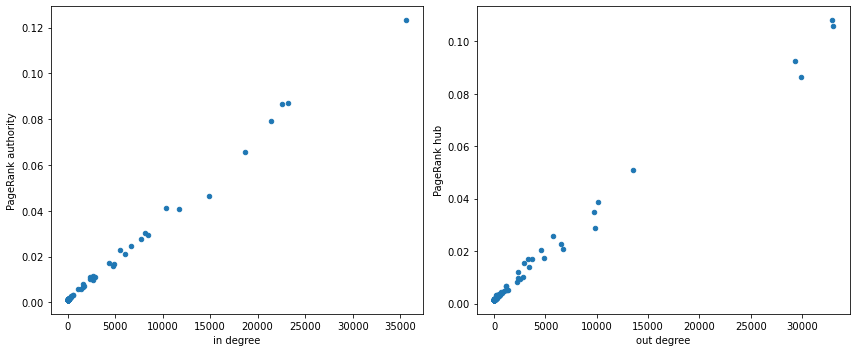

Top 10 for PageRank hub


Nodes  PageRank hub
118      Germany      0.107969
15         Spain      0.105780
100        Italy      0.092630
68        France      0.086511
29        Turkey      0.050982
97        Poland      0.038558
138           UK      0.034877
43   Netherlands      0.028793
70       Czechia      0.025774
106     Portugal      0.022677

Top 10 for PageRank authority


Nodes  PageRank authority
15         Spain            0.123114
118      Germany            0.087006
68        France            0.086449
100        Italy            0.079213
138           UK            0.065609
97        Poland            0.046248
43   Netherlands            0.041350
106     Portugal            0.040707
70       Czechia            0.030310
86        Sweden            0.029418

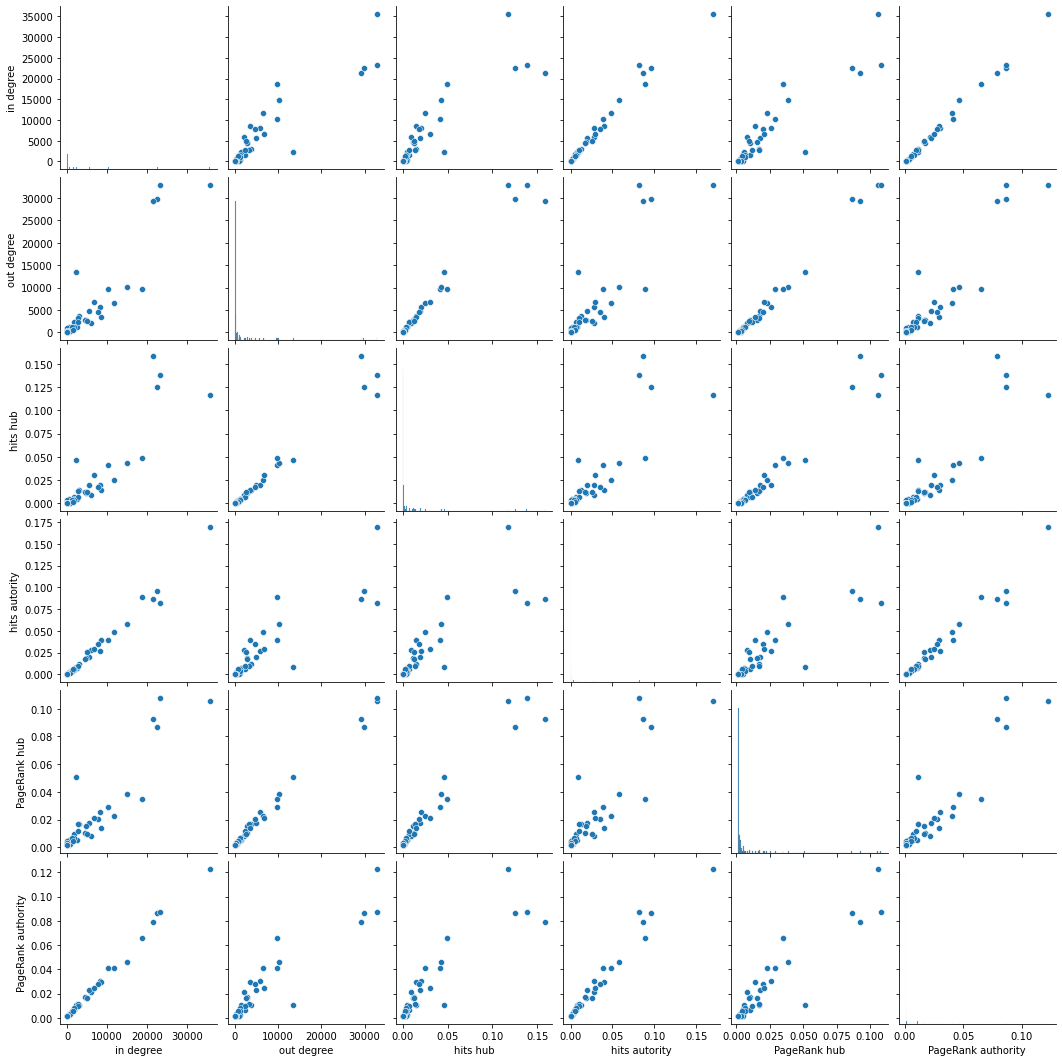

Nodes  in degree  in degree position  hits autority  \
15                Spain      35605                   1       0.169761   
118             Germany      23161                   2       0.082129   
68               France      22577                   3       0.095757   
100               Italy      21364                   4       0.086551   
138                  UK      18668                   5       0.088944   
97               Poland      14837                   6       0.057782   
43          Netherlands      10325                   8       0.039021   
106            Portugal      11764                   7       0.048229   
70              Czechia       8191                  10       0.027478   
86               Sweden       8497                   9       0.040013   
87              Finland       7719                  11       0.034659   
122             Belgium       6645                  12       0.029181   
19              Austria       5562                  14       0.020000   
2                Norway       6012                  13       0.027800   
31              Denmark       4362                  17       0.017367   
115             Ireland       4942                  15       0.025519   
26              Hungary       4753                  16       0.018594   
32                   EL       2688                  20       0.009944   
3               Romania       2932                  18       0.011985   
29               Turkey       2326                  22       0.008511   
23             Slovenia       2367                  21       0.007317   
81            Lithuania       2692                  19       0.010274   
82               Latvia       1593                  25       0.006580   
21              Croatia       1777                  23       0.005673   
4              Slovakia       1627                  24       0.006065   
129             Estonia       1397                  26       0.005867   
127            Bulgaria       1142                  27       0.003644   
14              Iceland        569                  29       0.002494   
128              Cyprus        614                  28       0.001771   
72                Malta        395                  31       0.001552   
110  Russian Federation        403                  30       0.001586   
85               Israel        240                  33       0.000845   
22               Serbia        253                  32       0.000888   
49        United States        168                  34       0.000569   
73           Luxembourg        154                  35       0.000767   
78                China         87                  38       0.000229   
80               Canada        102                  36       0.000447   
109               Japan         90                  37       0.000415   
17   Korea, Republic of         59                  45       0.000186   
98              Albania         71                  40       0.000381   

     hits autority position  PageRank authority  PageRank authority position  
15                        1            0.123114                            1  
118                       5            0.087006                            2  
68                        2            0.086449                            3  
100                       4            0.079213                            4  
138                       3            0.065609                            5  
97                        6            0.046248                            6  
43                        9            0.041350                            7  
106                       7            0.040707                            8  
70                       13            0.030310                            9  
86                        8            0.029418                           10  
87                       10            0.027783                           11  
122                      11            0.024593                           12

Nodes  out degree  out degree position  hits hub  \
118                 Germany       32916                    2  0.138050   
15                    Spain       32975                    1  0.117020   
100                   Italy       29261                    4  0.158669   
68                   France       29867                    3  0.125551   
29                   Turkey       13546                    5  0.046440   
97                   Poland       10157                    6  0.042947   
138                      UK        9681                    8  0.049037   
43              Netherlands        9806                    7  0.041421   
70                  Czechia        5694                   11  0.019911   
106                Portugal        6520                   10  0.025288   
122                 Belgium        6723                    9  0.030267   
87                  Finland        4613                   13  0.018064   
19                  Austria        4838                   12  0.019445   
3                   Romania        3701                   14  0.014400   
32                       EL        3268                   16  0.013178   
26                  Hungary        2869                   17  0.011019   
86                   Sweden        3394                   15  0.014861   
81                Lithuania        2309                   21  0.007263   
31                  Denmark        2810                   18  0.012119   
4                  Slovakia        2316                   20  0.007171   
115                 Ireland        2492                   19  0.012187   
2                    Norway        2196                   22  0.009252   
127                Bulgaria        1112                   27  0.003873   
82                   Latvia        1141                   25  0.003331   
23                 Slovenia        1311                   23  0.004607   
21                  Croatia        1233                   24  0.004574   
110      Russian Federation        1122                   26  0.004397   
112                 Ukraine         998                   28  0.004001   
129                 Estonia         643                   30  0.002034   
22                   Serbia         728                   29  0.002768   
13   Bosnia and Herzegovina         450                   35  0.001515   
78                    China         575                   31  0.002390   
11                  Morocco         537                   32  0.002809   
53                  Georgia         507                   33  0.001899   
135         North Macedonia         303                   39  0.000562   
133                  Jordan         259                   41  0.000759   
46               Azerbaijan         189                   50  0.000450   
73               Luxembourg         484                   34  0.002201   
41                  Tunisia         357                   37  0.001660   
98                  Albania         370                   36  0.001528   

     hits hub position  PageRank hub  PageRank hub position  
118                  2      0.107969                      1  
15                   4      0.105780                      2  
100                  1      0.092630                      3  
68                   3      0.086511                      4  
29                   6      0.050982                      5  
97                   7      0.038558                      6  
138                  5      0.034877                      7  
43                   8      0.028793                      8  
70                  11      0.025774                      9  
106                 10      0.022677                     10  
122                  9      0.020963                     11  
87                  13      0.020220                     12  
19                  12      0.017531                     13  
3                   15      0.017118                     14  
32                  16      0.016792                     

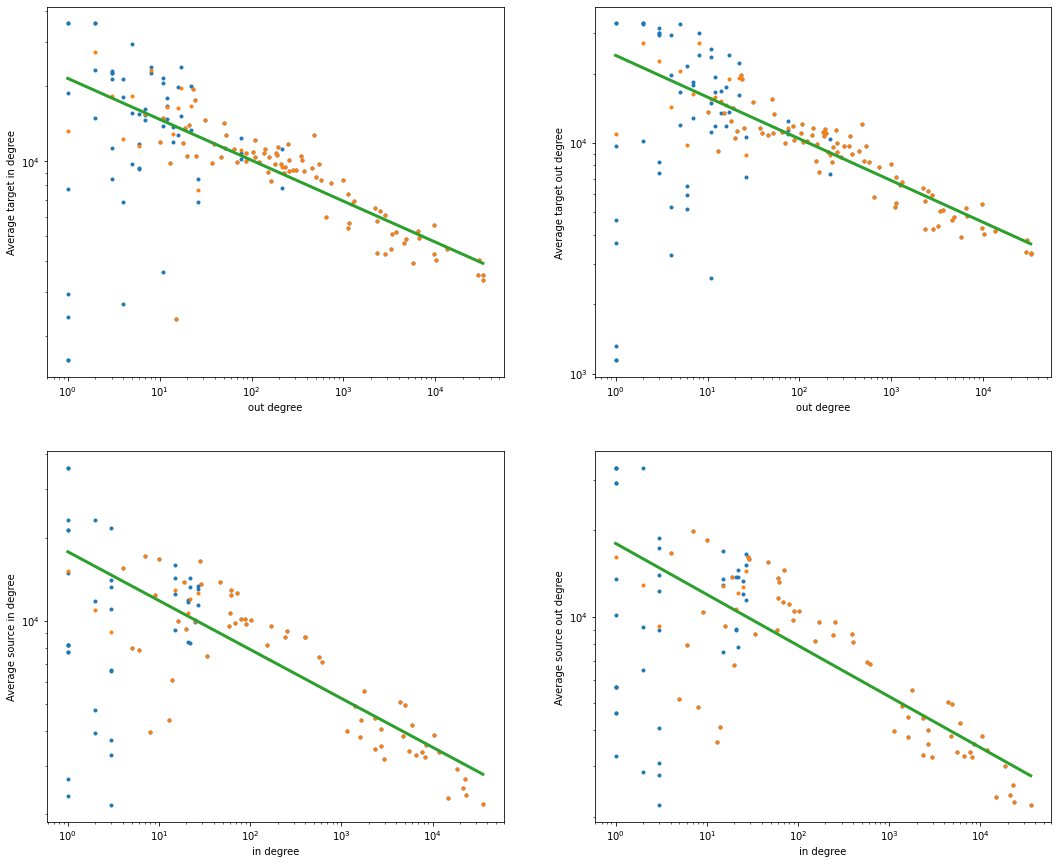

(-0.1638113565743919, -0.1808333579656681, -0.17663416293109127, -0.17836246071891335)


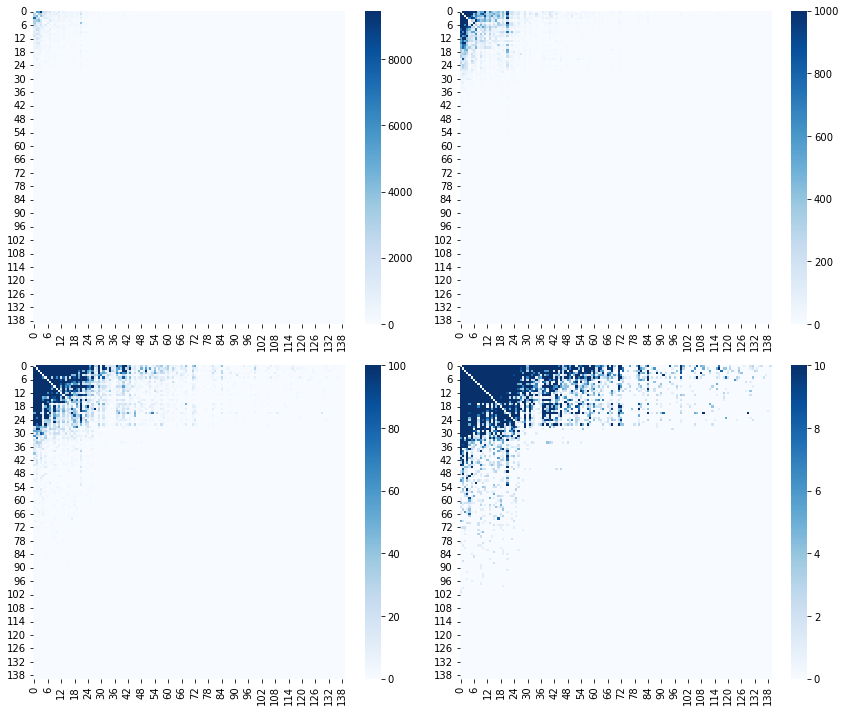

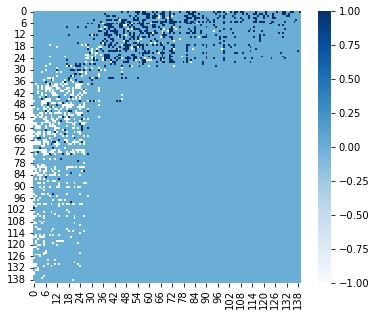

Nodes  Community
2                             Norway          0
5                       South Africa          0
6                           Ethiopia          0
9                                 XK          0
10                            Uganda          0
11                           Morocco          0
12               Palestine, State of          0
14                           Iceland          0
16                          Colombia          0
18                           Ecuador          0
26                           Hungary          0
30                           Jamaica          0
36                           Nigeria          0
39                         Australia          0
41                           Tunisia          0
43                       Netherlands          0
48                         Hong Kong          0
51                             Macao          0
52                          Viet Nam          0
53                           Georgia          0
55                      Burkina Faso          0
61                       Timor-Leste          0
66                     Liechtenstein          0
69                        Madagascar          0
72                             Malta          0
73                        Luxembourg          0
78                             China          0
80                            Canada          0
86                            Sweden          0
95                              Cuba          0
106                         Portugal          0
110               Russian Federation          0
115                          Ireland          0
116  Bolivia, Plurinational State of          0
118                          Germany          0
120                            India          0
122                          Belgium          0
125     Tanzania, United Republic of          0

Nodes  Community
0                  Uzbekistan          1
3                     Romania          1
4                    Slovakia          1
8                       Nepal          1
19                    Austria          1
21                    Croatia          1
22                     Serbia          1
23                   Slovenia          1
27                  Nicaragua          1
31                    Denmark          1
32                         EL          1
35                      Kenya          1
46                 Azerbaijan          1
49              United States          1
56                   Mongolia          1
59                    Belarus          1
60   Central African Republic          1
79          Brunei Darussalam          1
81                  Lithuania          1
84         Dominican Republic          1
85                     Israel          1
88                 Montenegro          1
91                 Kazakhstan          1
96                 Costa Rica          1
98                    Albania          1
104                  Malaysia          1
109                     Japan          1
112                   Ukraine          1
117                     Niger          1
119                   Armenia          1
121                    Mexico          1
123                Tajikistan          1
126                 Mauritius          1
127                  Bulgaria          1
128                    Cyprus          1
129                   Estonia          1
130               El Salvador          1
134       Trinidad and Tobago          1

Nodes  Community
15                Spain          2
17   Korea, Republic of          2
20                 Peru          2
29               Turkey          2
33            Indonesia          2
44              Algeria          2
58                Benin          2
67               Malawi          2
75           Cabo Verde          2
76             Pakistan          2
90          Afghanistan          2
92             Thailand          2
99            Singapore          2
105              Angola          2
108               Sudan          2
113              Belize          2
114    Papua New Guinea          2
124          Bangladesh          2
133              Jordan          2
135     North Macedonia          2
138                  UK          2
139          Mauritania          2

Nodes  Community
7                      Myanmar          3
24                  Mozambique          3
28        Moldova, Republic of          3
38   Taiwan, Province of China          3
40                      Bhutan          3
45                 Philippines          3
47                       Egypt          3
57                    Honduras          3
63                        Mali          3
71        Syrian Arab Republic          3
74                       Chile          3
77                     Senegal          3
82                      Latvia          3
83                      Panama          3
89                  Kyrgyzstan          3
93                    Suriname          3
97                      Poland          3
100                      Italy          3
101                  Sri Lanka          3
131                      Libya          3
136                   Paraguay          3

Nodes  Community
13              Bosnia and Herzegovina          4
25                           Argentina          4
34                            Cambodia          4
37                           Guatemala          4
42                            Barbados          4
50   Venezuela, Bolivarian Republic of          4
54                               Haiti          4
62                             Lebanon          4
64           Iran, Islamic Republic of          4
65                              Zambia          4
68                              France          4
70                             Czechia          4
87                             Finland          4
94                              Brazil          4
102                        New Zealand          4
103                           Cameroon          4
107                              Ghana          4
111                            Uruguay          4
132   Lao People's Democratic Republic          4
137                      Côte d'Ivoire          4

Nodes  Community
1   nan          5

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
13          Turkey                          7107650.0
34         Germany                          2625241.0
39  United Kingdom                          2263020.0
30           Italy                          1797986.0
6            Spain                          1491419.0
28          Poland                          1418588.0
16     Netherlands                           720583.0
15          Greece                           704969.0
25          Sweden                           438578.0
31        Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.492077e-07
3          Romania   1.269687e-07
4        Lithuania   1.038695e-07
5         Slovenia   1.008047e-07
6          Estonia   9.722841e-08
7          Belgium   9.088036e-08
8         Slovakia   8.726855e-08
9          Czechia   8.689476e-08
10          Latvia   8.319393e-08
11         Finland   7.308682e-08
12           Spain   7.092605e-08
13        Portugal   7.010644e-08
14       Macedonia   6.583604e-08
15         Hungary   5.536776e-08
16           Italy   5.151878e-08
17         Ireland   4.661964e-08
18         Germany   4.112719e-08
19     Netherlands   3.995800e-08
20         Denmark   3.928433e-08
21          Sweden   3.216798e-08
22         Croatia   3.190898e-08
23          Norway   3.044968e-08
24        Bulgaria   2.887107e-08
25          Poland   2.718071e-08
26          Greece   2.381973e-08
27         Albania   2.016383e-08
28          Serbia   1.619288e-08
29  United Kingdom   1.541150e-08
30          Turkey   7.172862e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.963920e-07
3         Slovenia   1.939973e-07
4         Portugal   1.258455e-07
5          Estonia   1.246647e-07
6          Belgium   1.066173e-07
7           Latvia   1.024491e-07
8          Czechia   1.021874e-07
9          Finland   1.004248e-07
10       Lithuania   8.574431e-08
11           Spain   8.254842e-08
12         Ireland   8.232216e-08
13         Romania   8.084707e-08
14          Norway   7.869189e-08
15          Sweden   6.707696e-08
16         Denmark   6.682868e-08
17        Slovakia   6.054686e-08
18         Hungary   5.764323e-08
19     Netherlands   5.738467e-08
20         Croatia   4.456249e-08
21           Italy   4.405664e-08
22         Germany   3.314218e-08
23          Poland   3.260108e-08
24  United Kingdom   2.899191e-08
25       Macedonia   2.457189e-08
26        Bulgaria   2.425445e-08
27          Greece   1.612880e-08
28         Albania   9.442370e-09
29          Serbia   8.126549e-09
30          Turkey   1.531775e-09
31     Switzerland   0.000000e+00

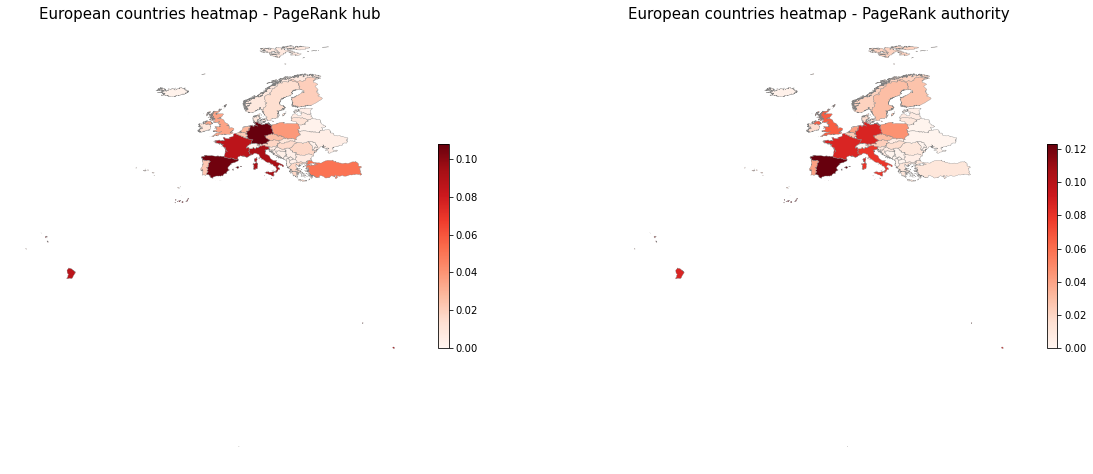

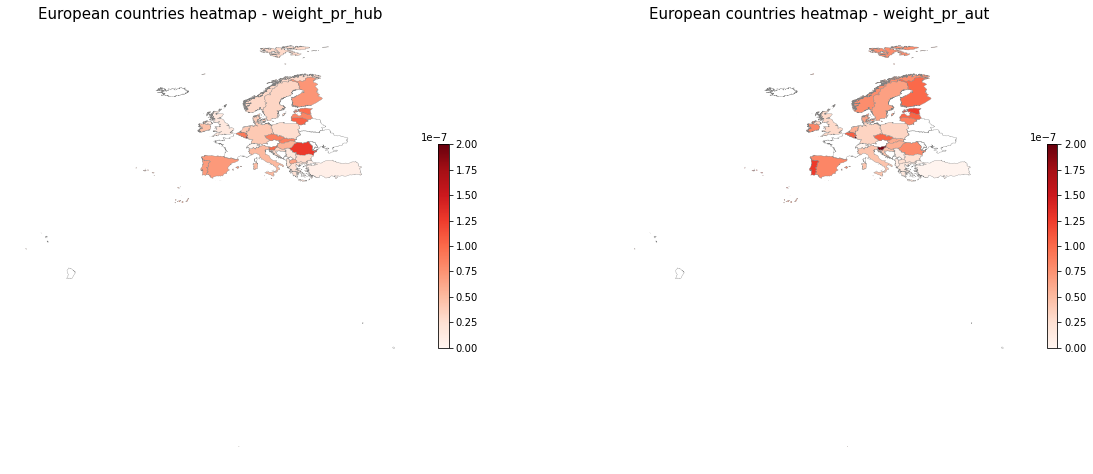

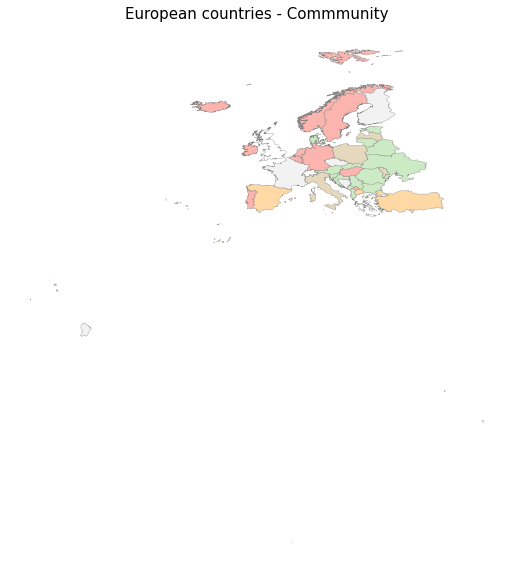

In [6]:
country17_df = pd.read_csv('data\Erasmus17.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country17_df)

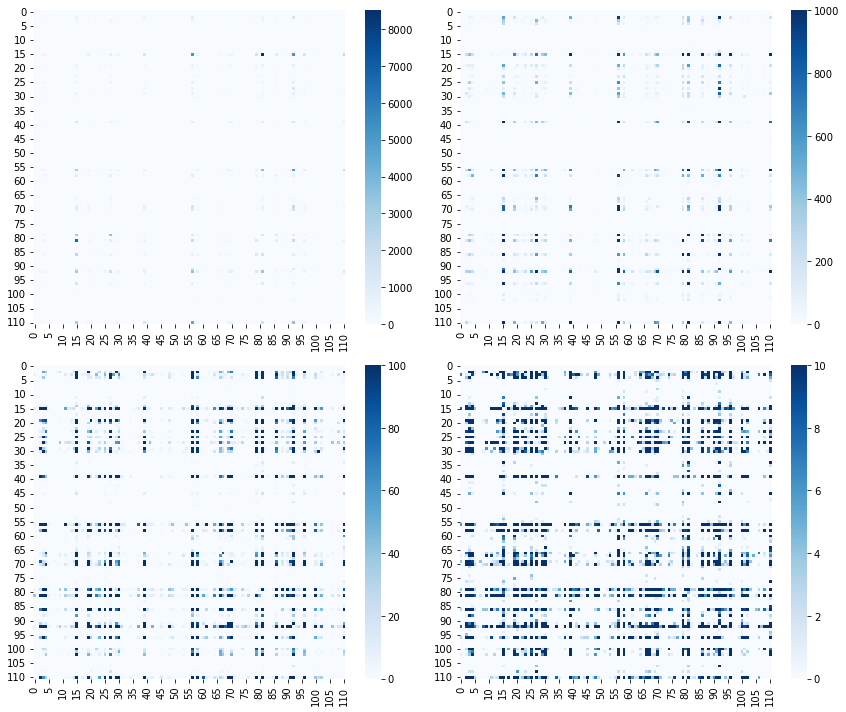

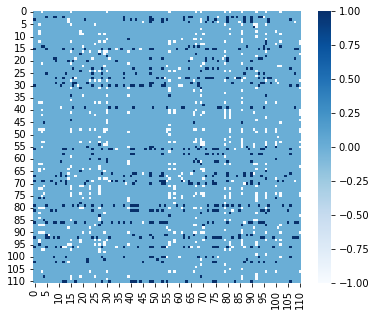

Number of components = 2


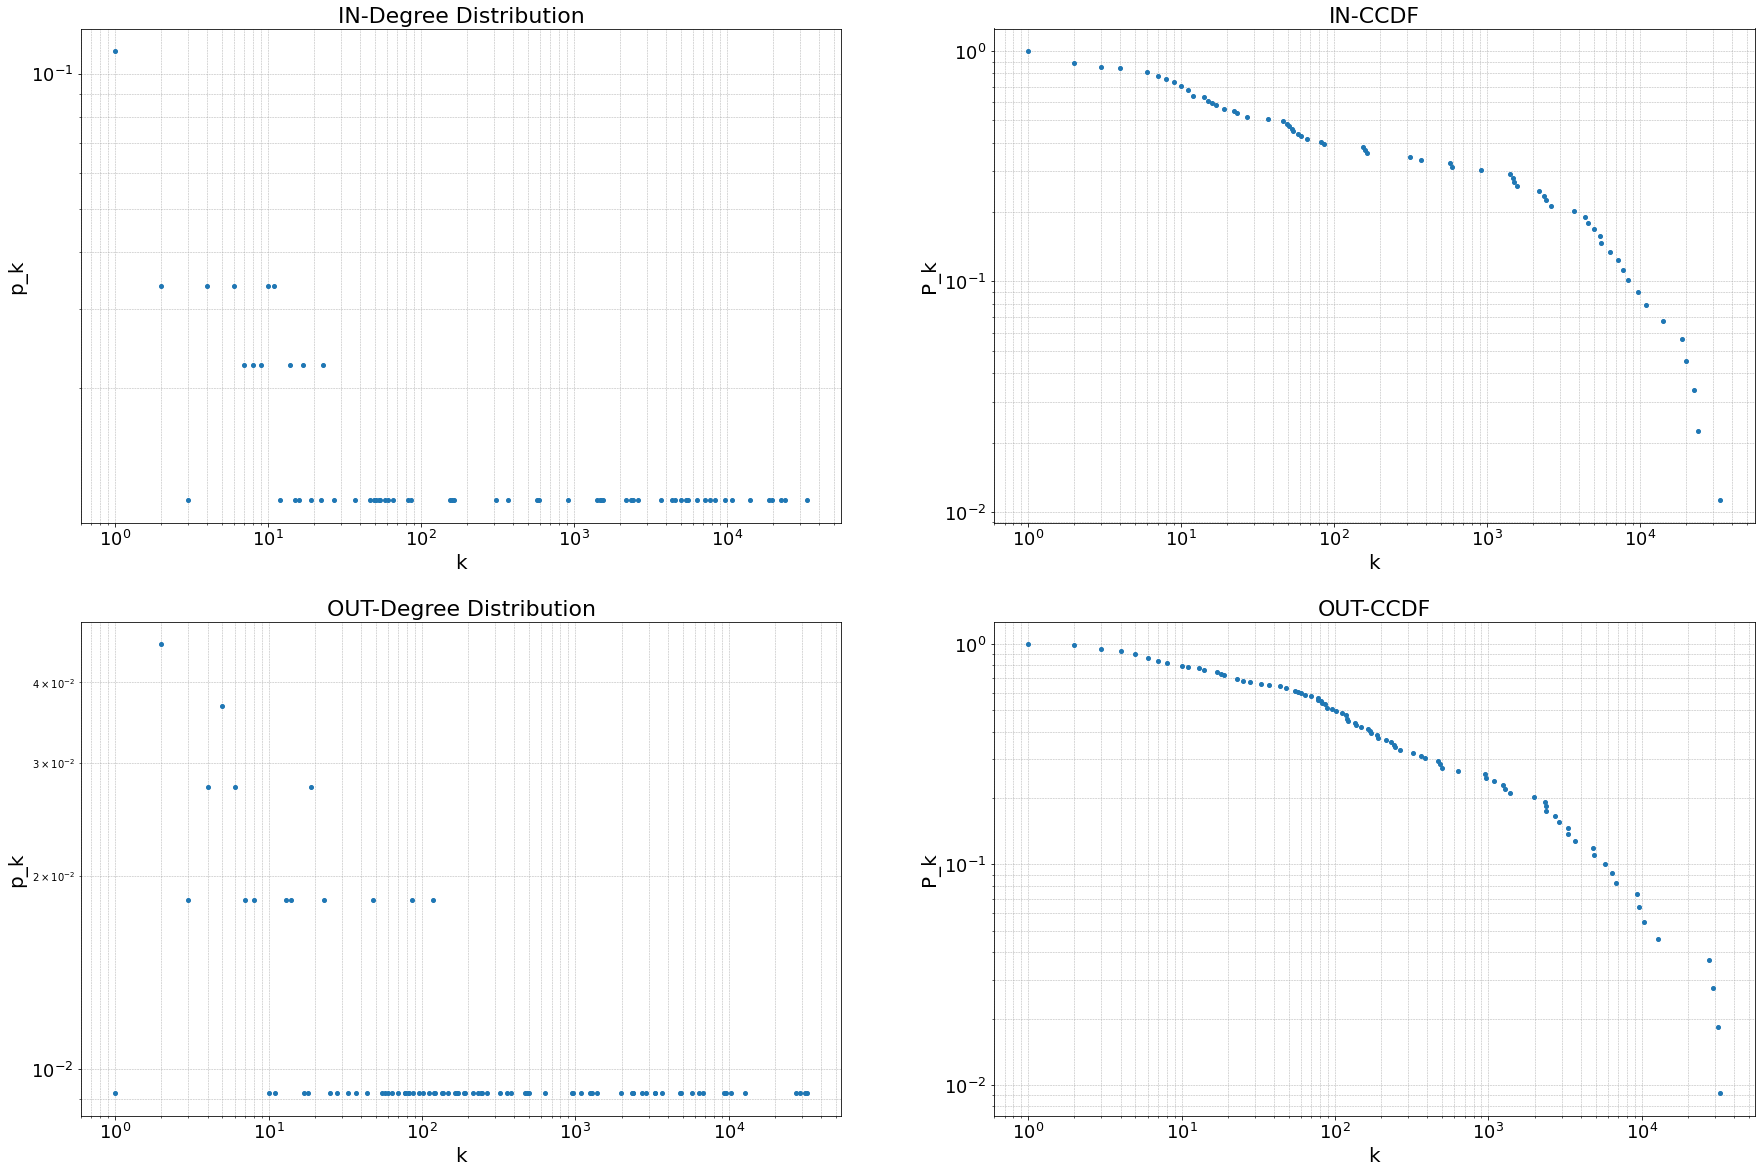

Top 10 for in degree


Nodes  in degree
15         Spain      33293
92       Germany      23798
56        France      22383
81         Italy      19833
110           UK      18794
79        Poland      14105
86      Portugal      10852
39   Netherlands       9731
69        Sweden       8345
58       Czechia       7736

Top 10 for out degree


Nodes  out degree
92       Germany       32334
15         Spain       31506
56        France       29317
81         Italy       27270
27        Turkey       12785
79        Poland       10401
110           UK        9578
39   Netherlands        9319
96       Belgium        6751
86      Portugal        6377

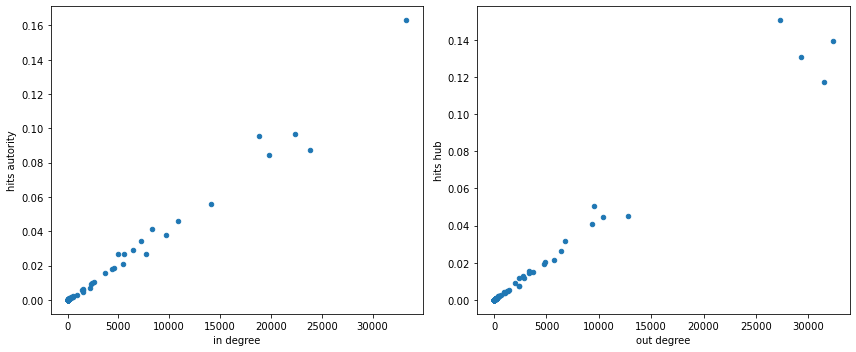

Top 10 for hits hub


Nodes  hits hub
81         Italy  0.150597
92       Germany  0.139633
56        France  0.131016
15         Spain  0.117437
110           UK  0.050395
27        Turkey  0.045201
79        Poland  0.044641
39   Netherlands  0.040668
96       Belgium  0.031715
86      Portugal  0.026263

Top 10 for hits autority


Nodes  hits autority
15         Spain       0.162945
56        France       0.096727
110           UK       0.095482
92       Germany       0.087375
81         Italy       0.084303
79        Poland       0.055721
86      Portugal       0.045732
69        Sweden       0.041256
39   Netherlands       0.038033
70       Finland       0.034068

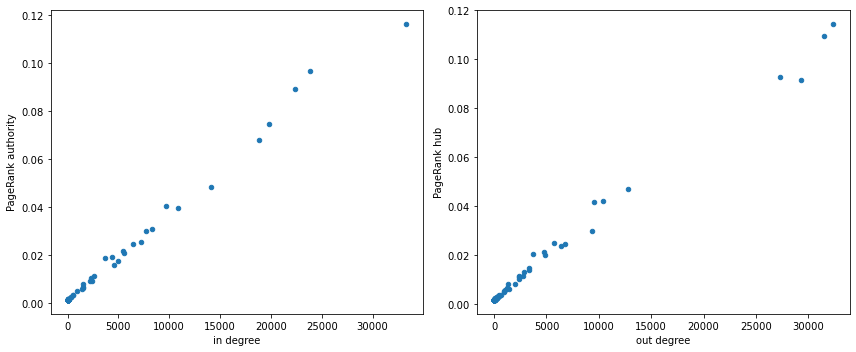

Top 10 for PageRank hub


Nodes  PageRank hub
92       Germany      0.114569
15         Spain      0.109729
81         Italy      0.092845
56        France      0.091482
27        Turkey      0.046980
79        Poland      0.042238
110           UK      0.041662
39   Netherlands      0.029906
58       Czechia      0.024756
96       Belgium      0.024384

Top 10 for PageRank authority


Nodes  PageRank authority
15         Spain            0.116533
92       Germany            0.096689
56        France            0.089403
81         Italy            0.074795
110           UK            0.068275
79        Poland            0.048501
39   Netherlands            0.040407
86      Portugal            0.039777
69        Sweden            0.030819
58       Czechia            0.029999

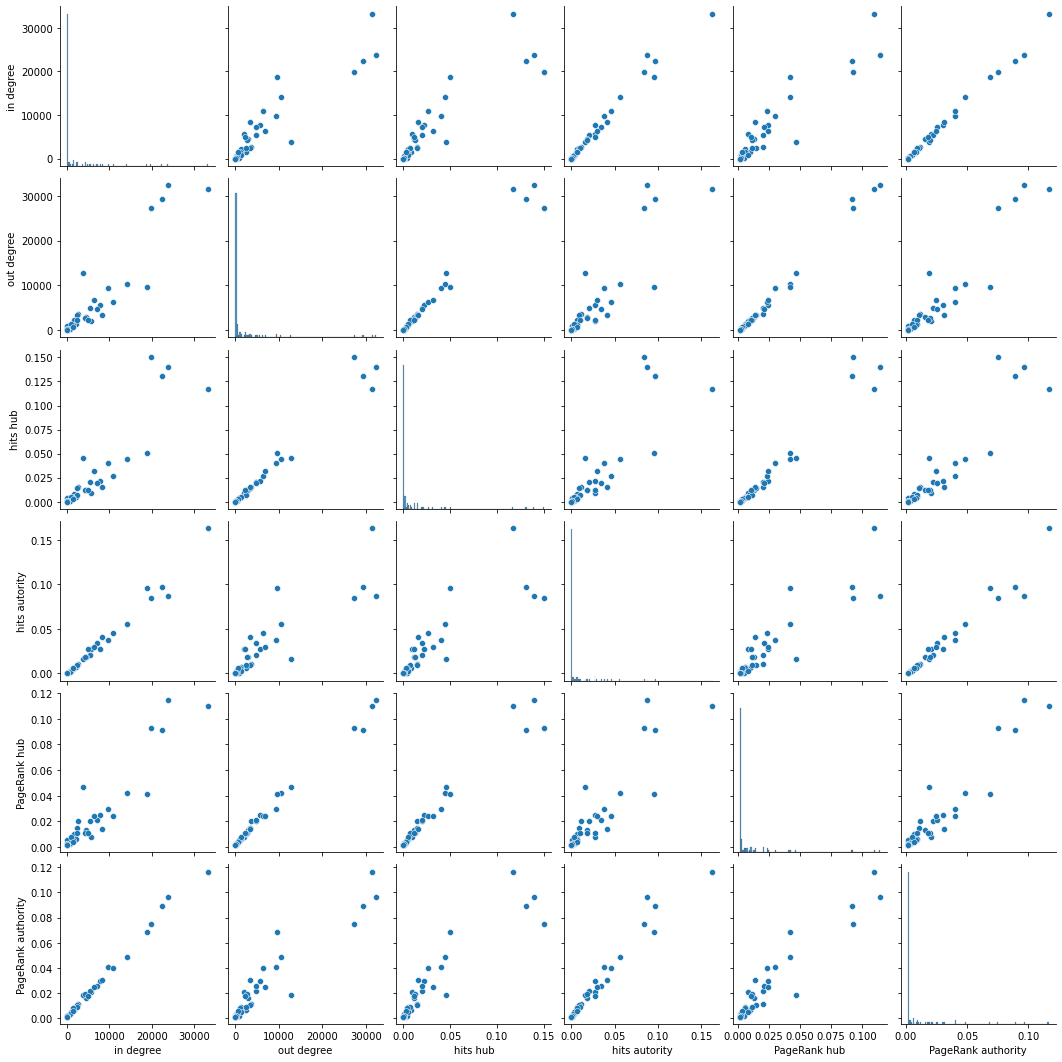

Nodes  in degree  in degree position  hits autority  \
15                Spain      33293                   1       0.162945   
92              Germany      23798                   2       0.087375   
56               France      22383                   3       0.096727   
81                Italy      19833                   4       0.084303   
110                  UK      18794                   5       0.095482   
79               Poland      14105                   6       0.055721   
39          Netherlands       9731                   8       0.038033   
86             Portugal      10852                   7       0.045732   
69               Sweden       8345                   9       0.041256   
58              Czechia       7736                  10       0.026969   
70              Finland       7179                  11       0.034068   
96              Belgium       6395                  12       0.029199   
19              Austria       5428                  14       0.020758   
2                Norway       5532                  13       0.026885   
29              Denmark       4341                  17       0.017851   
27               Turkey       3693                  18       0.015895   
91              Ireland       4999                  15       0.026967   
25              Hungary       4542                  16       0.018515   
3               Romania       2625                  19       0.010639   
30                   EL       2353                  21       0.008945   
23             Slovenia       2196                  22       0.006885   
66            Lithuania       2429                  20       0.009774   
67               Latvia       1500                  24       0.006364   
20              Croatia       1485                  25       0.004798   
4              Slovakia       1556                  23       0.005946   
102             Estonia       1408                  26       0.005928   
100            Bulgaria        916                  27       0.003091   
14              Iceland        586                  28       0.002462   
101              Cyprus        570                  29       0.001849   
60                Malta        311                  31       0.001155   
88   Russian Federation        368                  30       0.001684   
45        United States        159                  33       0.000595   
22               Serbia        163                  32       0.000558   
61           Luxembourg        155                  34       0.000800   
68               Israel         82                  36       0.000308   
65               Canada         86                  35       0.000393   
64                China         66                  37       0.000184   
34            Australia         61                  38       0.000333   
11              Morocco         58                  39       0.000304   
17   Korea, Republic of         49                  43       0.000137   

     hits autority position  PageRank authority  PageRank authority position  
15                        1            0.116533                            1  
92                        4            0.096689                            2  
56                        2            0.089403                            3  
81                        5            0.074795                            4  
110                       3            0.068275                            5  
79                        6            0.048501                            6  
39                        9            0.040407                            7  
86                        7            0.039777                            8  
69                        8            0.030819                            9  
58                       12            0.029999                           10  
70                       10            0.025510                           11  
96                       11            0.024832                           12

Nodes  out degree  out degree position  hits hub  \
92              Germany       32334                    1  0.139633   
15                Spain       31506                    2  0.117437   
81                Italy       27270                    4  0.150597   
56               France       29317                    3  0.131016   
27               Turkey       12785                    5  0.045201   
79               Poland       10401                    6  0.044641   
110                  UK        9578                    7  0.050395   
39          Netherlands        9319                    8  0.040668   
58              Czechia        5721                   11  0.021545   
96              Belgium        6751                    9  0.031715   
86             Portugal        6377                   10  0.026263   
70              Finland        4781                   13  0.019474   
3               Romania        3678                   14  0.014823   
19              Austria        4873                   12  0.020217   
30                   EL        3310                   16  0.014303   
69               Sweden        3319                   15  0.015275   
25              Hungary        2887                   17  0.011807   
66            Lithuania        2359                   20  0.007445   
29              Denmark        2720                   18  0.012691   
91              Ireland        2333                   21  0.011820   
4              Slovakia        2368                   19  0.007646   
2                Norway        1979                   22  0.008815   
100            Bulgaria        1290                   24  0.004872   
20              Croatia        1251                   25  0.004658   
23             Slovenia        1381                   23  0.005118   
67               Latvia        1085                   26  0.003462   
90              Ukraine         945                   28  0.003750   
88   Russian Federation         969                   27  0.004081   
102             Estonia         632                   29  0.002337   
22               Serbia         496                   30  0.001893   
61           Luxembourg         485                   31  0.002327   
64                China         468                   32  0.002004   
48              Georgia         361                   34  0.001258   
11              Morocco         383                   33  0.001900   
101              Cyprus         321                   35  0.000758   
74           Kazakhstan         247                   37  0.000918   
37              Tunisia         266                   36  0.001248   
108     North Macedonia         191                   41  0.000417   
80              Albania         187                   42  0.000763   
106              Jordan         148                   46  0.000516   

     hits hub position  PageRank hub  PageRank hub position  
92                   2      0.114569                      1  
15                   4      0.109729                      2  
81                   1      0.092845                      3  
56                   3      0.091482                      4  
27                   6      0.046980                      5  
79                   7      0.042238                      6  
110                  5      0.041662                      7  
39                   8      0.029906                      8  
58                  11      0.024756                      9  
96                   9      0.024384                     10  
86                  10      0.023881                     11  
70                  13      0.021154                     12  
3                   15      0.020380                     13  
19                  12      0.020145                     14  
30                  16      0.014628                     15  
69                  14      0.014002                     16  
25                  19      0.013235                     17  
66                  22      0.0

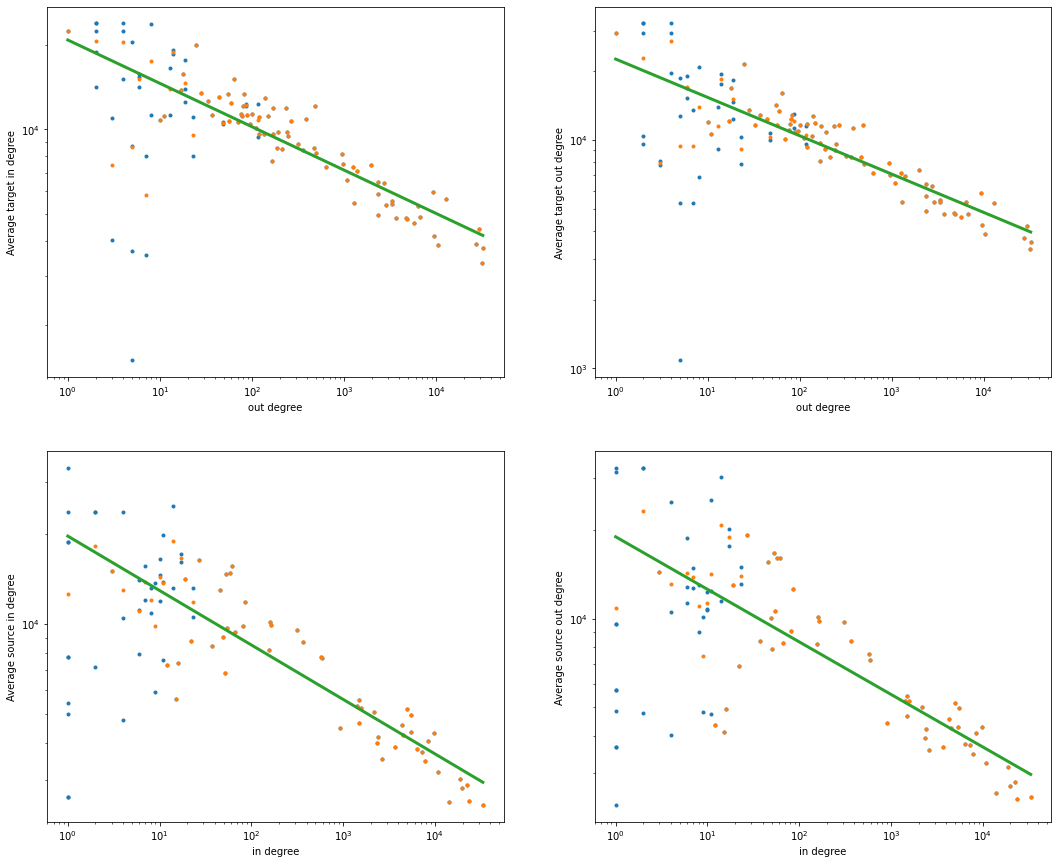

(-0.1544304249297988, -0.16778856685274204, -0.18258937454941349, -0.17804032141718953)


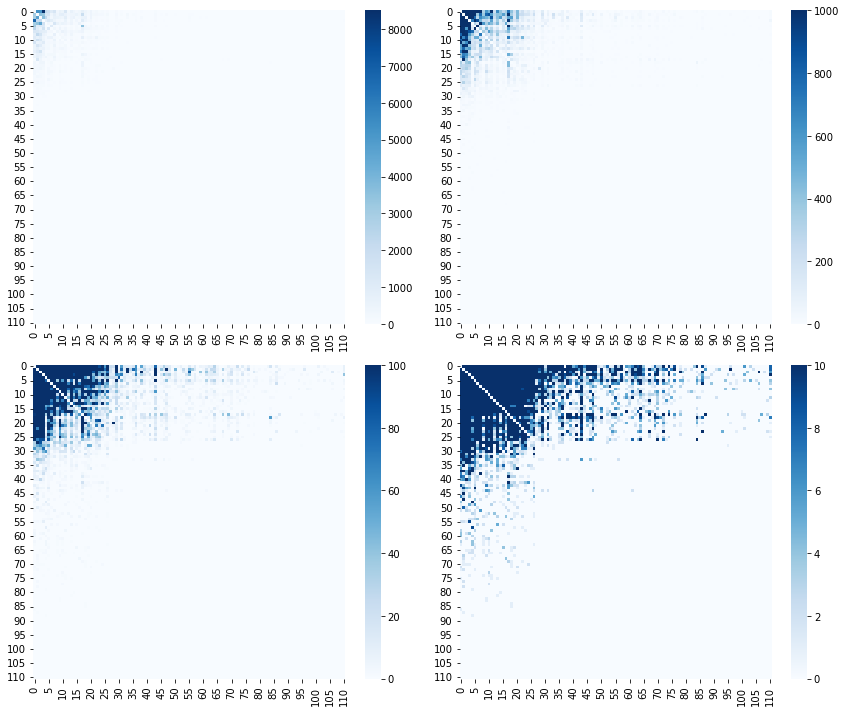

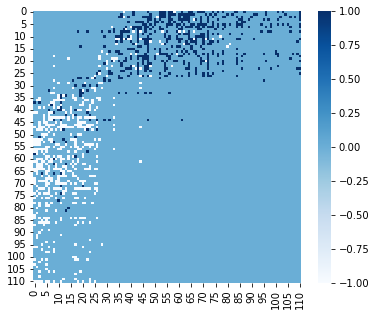

Nodes  Community
0                           Uzbekistan          0
3                              Romania          0
5                         South Africa          0
7                              Myanmar          0
11                             Morocco          0
13              Bosnia and Herzegovina          0
25                             Hungary          0
28                Moldova, Republic of          0
32                            Cambodia          0
35           Taiwan, Province of China          0
37                             Tunisia          0
40                             Algeria          0
42                               Egypt          0
46   Venezuela, Bolivarian Republic of          0
50                        Burkina Faso          0
51                            Mongolia          0
52                            Honduras          0
56                              France          0
57                          Madagascar          0
61                          Luxembourg          0
66                           Lithuania          0
67                              Latvia          0
69                              Sweden          0
74                          Kazakhstan          0
75                            Thailand          0
80                             Albania          0
81                               Italy          0
86                            Portugal          0
87                               Japan          0
88                  Russian Federation          0
101                             Cyprus          0
104                              Libya          0
105   Lao People's Democratic Republic          0
108                    North Macedonia          0

Nodes  Community
6         Ethiopia          1
8            Nepal          1
10          Uganda          1
16        Colombia          1
21            Peru          1
22          Serbia          1
29         Denmark          1
30              EL          1
31       Indonesia          1
38        Barbados          1
39     Netherlands          1
41      Azerbaijan          1
45   United States          1
48         Georgia          1
49        Viet Nam          1
54         Lebanon          1
55   Liechtenstein          1
60           Malta          1
70         Finland          1
77            Cuba          1
82     New Zealand          1
91         Ireland          1
92         Germany          1
95          Mexico          1
98      Bangladesh          1
100       Bulgaria          1
107          Gabon          1
109       Paraguay          1

Nodes  Community
2         Norway          2
4       Slovakia          2
9             XK          2
14       Iceland          2
19       Austria          2
20       Croatia          2
23      Slovenia          2
26     Nicaragua          2
27        Turkey          2
36        Bhutan          2
53       Belarus          2
58       Czechia          2
63      Pakistan          2
64         China          2
68        Israel          2
71    Montenegro          2
72    Kyrgyzstan          2
73   Afghanistan          2
76        Brazil          2
78    Costa Rica          2
84     Sri Lanka          2
90       Ukraine          2
93       Armenia          2
97    Tajikistan          2
102      Estonia          2

Nodes  Community
12            Palestine, State of          3
15                          Spain          3
17             Korea, Republic of          3
18                        Ecuador          3
24                      Argentina          3
33                      Guatemala          3
34                      Australia          3
43                    Philippines          3
44                      Hong Kong          3
47                          Macao          3
59           Syrian Arab Republic          3
62                          Chile          3
65                         Canada          3
79                         Poland          3
83                      Singapore          3
85                       Malaysia          3
89                        Uruguay          3
94                          India          3
96                        Belgium          3
99   Tanzania, United Republic of          3
103                   El Salvador          3
106                        Jordan          3
110                            UK          3

Nodes  Community
1   nan          4

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
12          Turkey                          7107650.0
34         Germany                          2625241.0
39  United Kingdom                          2263020.0
30           Italy                          1797986.0
6            Spain                          1491419.0
28          Poland                          1418588.0
16     Netherlands                           720583.0
15          Greece                           704969.0
25          Sweden                           438578.0
31        Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.717710e-07
3          Romania   1.511653e-07
4         Slovenia   1.152472e-07
5          Belgium   1.057105e-07
6        Lithuania   9.866581e-08
7         Slovakia   8.973590e-08
8          Czechia   8.346247e-08
9          Estonia   8.291044e-08
10         Finland   7.646203e-08
11        Portugal   7.382788e-08
12           Spain   7.357377e-08
13          Latvia   7.331518e-08
14         Ireland   5.386471e-08
15       Macedonia   5.314523e-08
16           Italy   5.163831e-08
17         Hungary   4.757780e-08
18         Denmark   4.379717e-08
19         Germany   4.364116e-08
20     Netherlands   4.150309e-08
21         Croatia   4.039316e-08
22        Bulgaria   3.441266e-08
23          Sweden   3.192481e-08
24          Poland   2.977437e-08
25          Norway   2.974320e-08
26          Greece   2.075026e-08
27  United Kingdom   1.840972e-08
28         Albania   1.810482e-08
29          Serbia   1.538392e-08
30          Turkey   6.609799e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1            Malta   2.000000e-07
2       Luxembourg   2.000000e-07
3         Slovenia   1.770698e-07
4          Estonia   1.354579e-07
5         Portugal   1.229693e-07
6          Belgium   1.076548e-07
7           Latvia   1.012808e-07
8          Czechia   1.011389e-07
9          Finland   9.220635e-08
10         Ireland   8.860261e-08
11         Romania   8.548312e-08
12       Lithuania   8.028789e-08
13           Spain   7.813569e-08
14          Norway   7.703323e-08
15         Denmark   7.497805e-08
16          Sweden   7.027031e-08
17        Slovakia   5.790980e-08
18         Hungary   5.702243e-08
19     Netherlands   5.607551e-08
20         Croatia   4.256757e-08
21           Italy   4.159941e-08
22         Germany   3.683066e-08
23          Poland   3.418965e-08
24       Macedonia   3.134522e-08
25  United Kingdom   3.016992e-08
26        Bulgaria   2.138097e-08
27          Greece   1.483537e-08
28         Albania   1.047136e-08
29          Serbia   8.028754e-09
30          Turkey   2.630136e-09
31     Switzerland   0.000000e+00

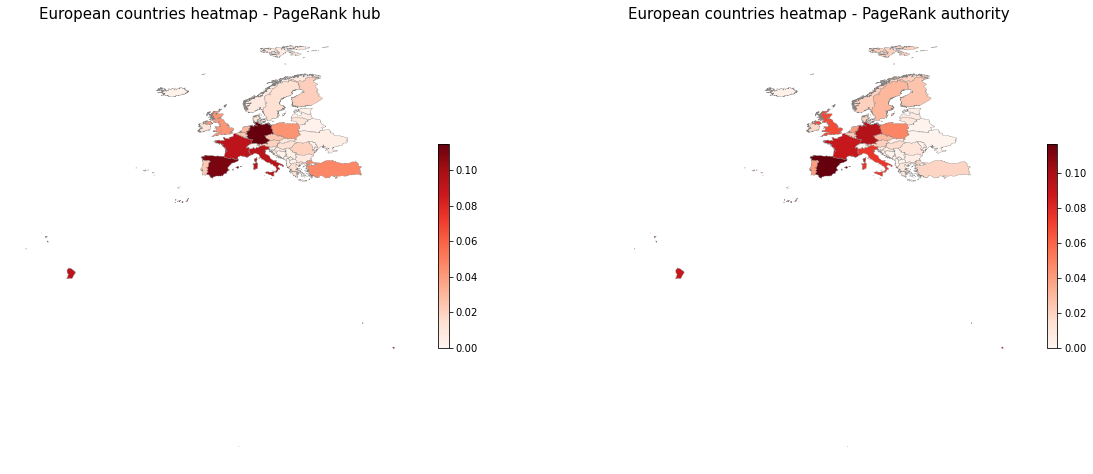

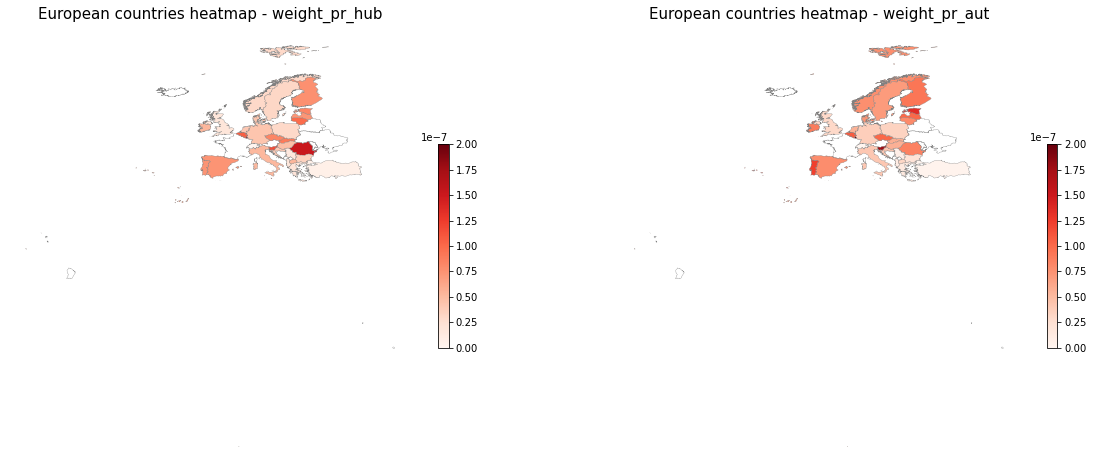

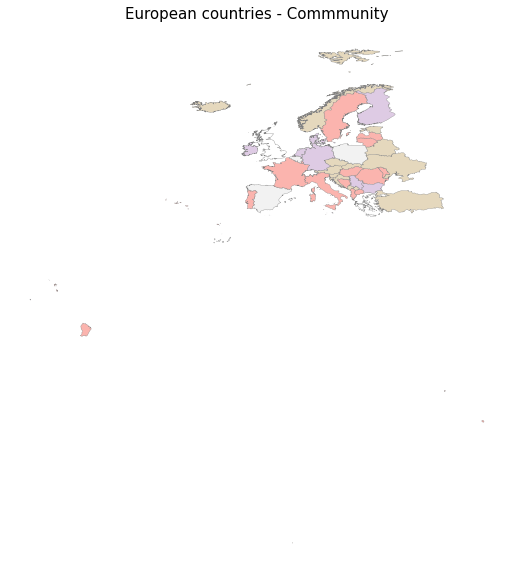

In [7]:
country16_df = pd.read_csv('data\Erasmus16.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country16_df)

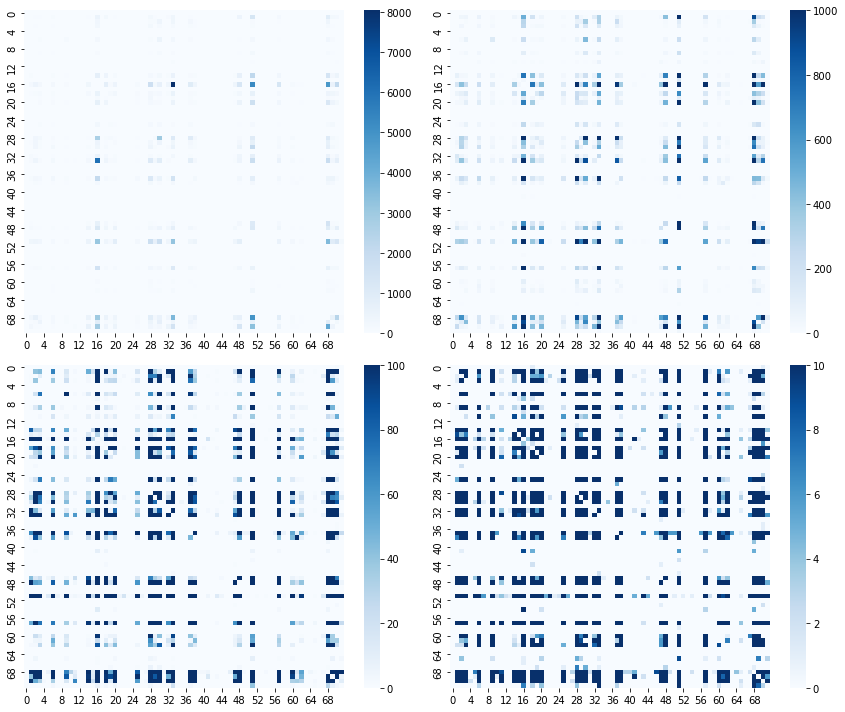

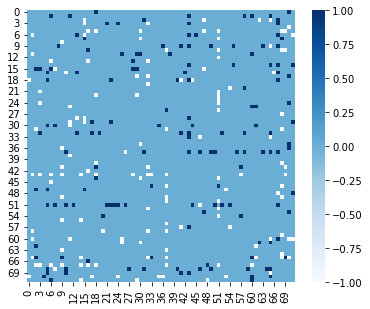

Number of components = 1


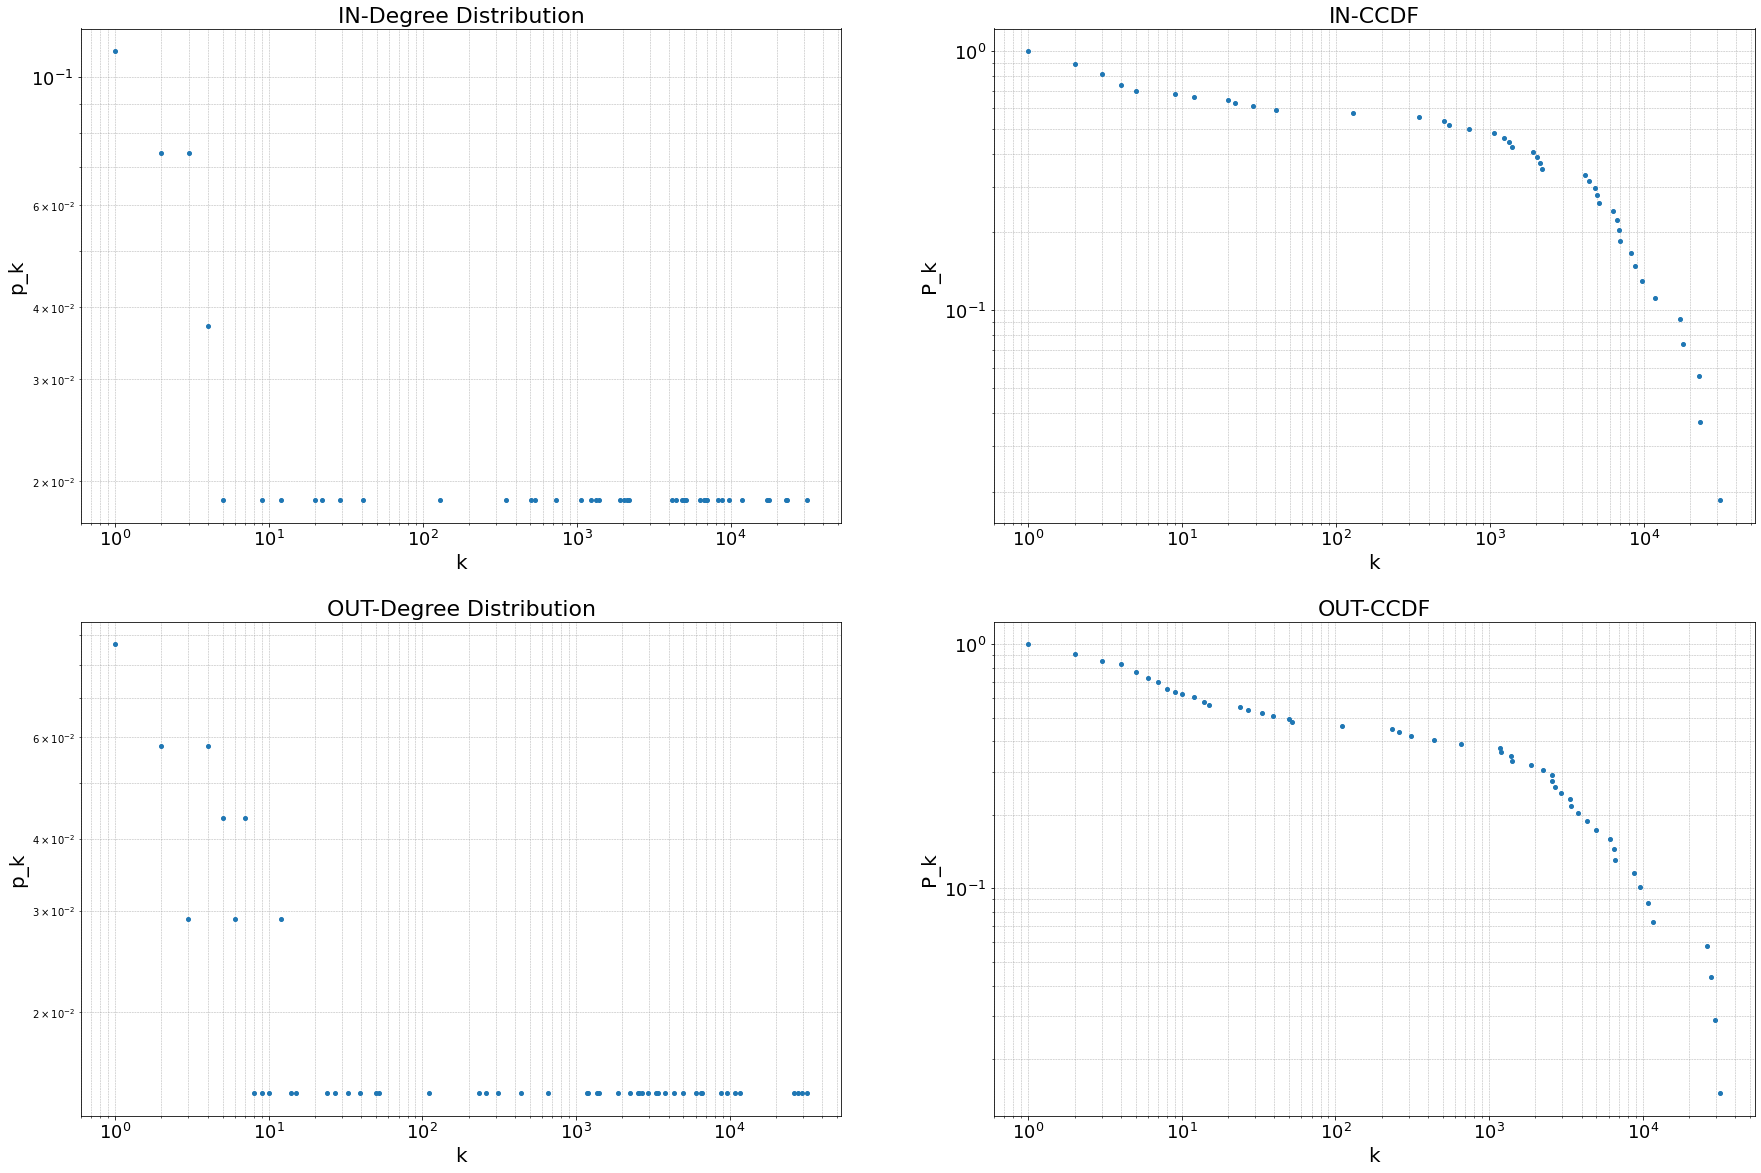

Top 10 for in degree


Nodes  in degree
16        Spain      31328
51      Germany      23334
68       France      22774
70           UK      17896
33        Italy      17313
28       Poland      11915
37     Portugal       9770
48  Netherlands       8832
14       Sweden       8277
20      Finland       6992

Top 10 for out degree


Nodes  out degree
51      Germany       31842
16        Spain       29491
68       France       27790
33        Italy       26119
30       Turkey       11601
28       Poland       10874
70           UK        9630
48  Netherlands        8838
57      Belgium        6641
69      Czechia        6492

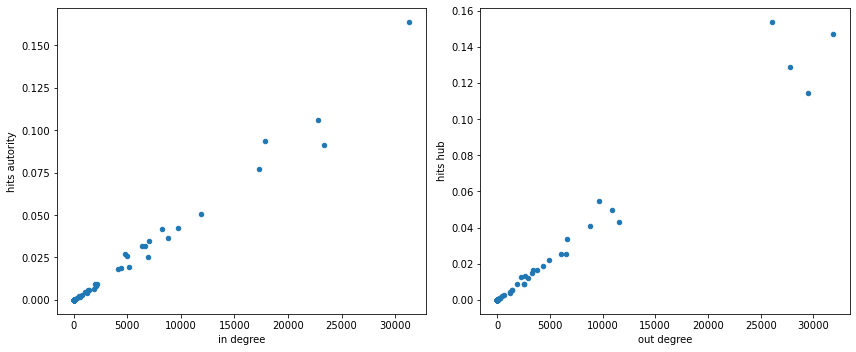

Top 10 for hits hub


Nodes  hits hub
33        Italy  0.153959
51      Germany  0.147386
68       France  0.128948
16        Spain  0.114324
70           UK  0.054692
28       Poland  0.049684
30       Turkey  0.042843
48  Netherlands  0.040712
57      Belgium  0.033620
37     Portugal  0.025642

Top 10 for hits autority


Nodes  hits autority
16        Spain       0.164030
68       France       0.106196
70           UK       0.093642
51      Germany       0.091452
33        Italy       0.076907
28       Poland       0.050483
37     Portugal       0.042417
14       Sweden       0.041725
48  Netherlands       0.036388
20      Finland       0.034568

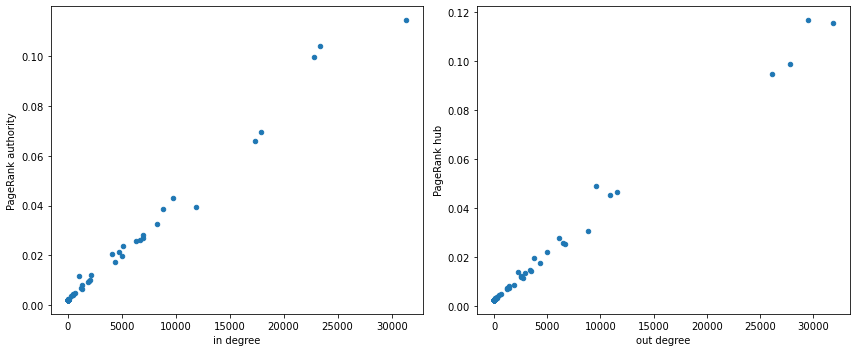

Top 10 for PageRank hub


Nodes  PageRank hub
16        Spain      0.116762
51      Germany      0.115689
68       France      0.098750
33        Italy      0.094661
70           UK      0.048974
30       Turkey      0.046628
28       Poland      0.045302
48  Netherlands      0.030773
37     Portugal      0.028010
69      Czechia      0.026003

Top 10 for PageRank authority


Nodes  PageRank authority
16        Spain            0.114362
51      Germany            0.104124
68       France            0.099493
70           UK            0.069481
33        Italy            0.066042
37     Portugal            0.042854
28       Poland            0.039454
48  Netherlands            0.038527
14       Sweden            0.032644
69      Czechia            0.028223

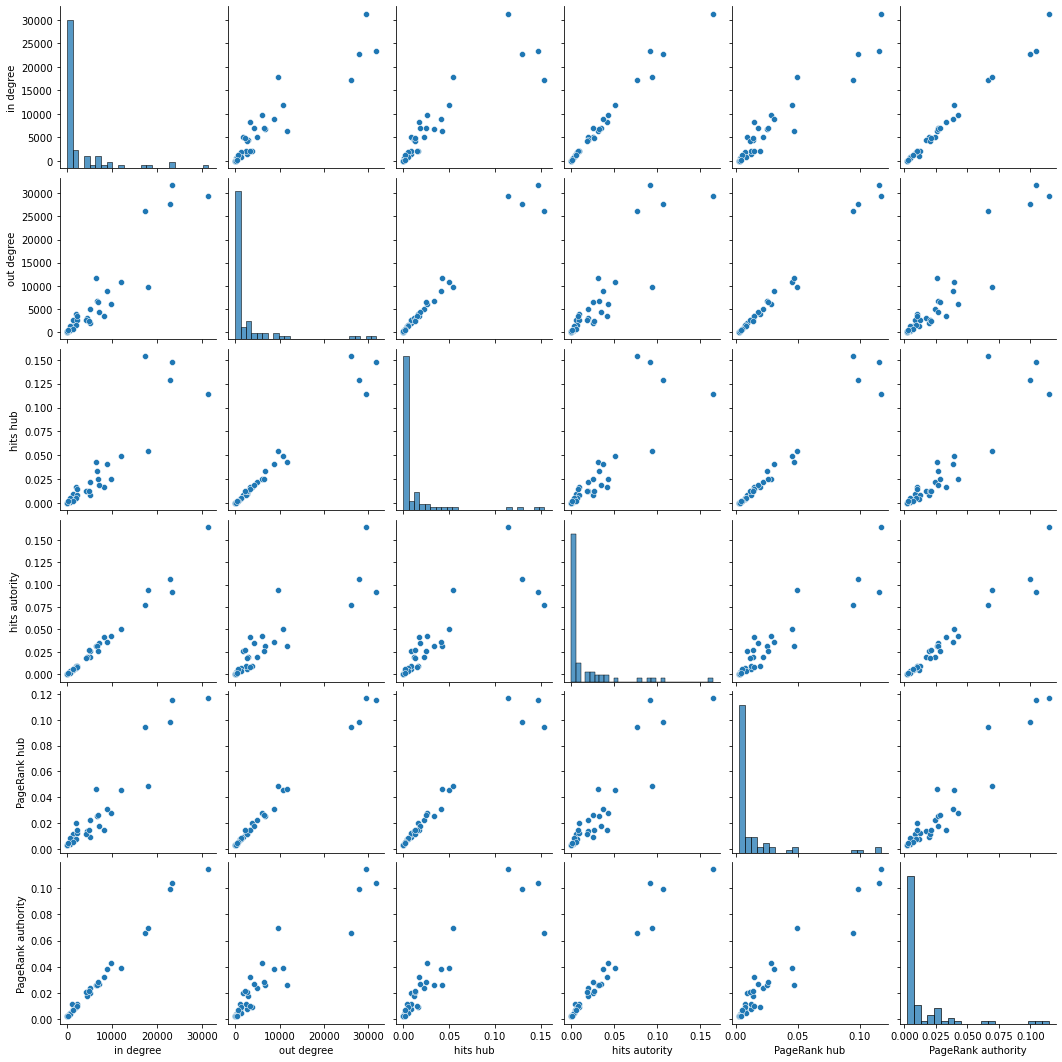

Nodes  in degree  in degree position  hits autority  \
16               Spain      31328                   1       0.164030   
51             Germany      23334                   2       0.091452   
68              France      22774                   3       0.106196   
70                  UK      17896                   4       0.093642   
33               Italy      17313                   5       0.076907   
37            Portugal       9770                   7       0.042417   
28              Poland      11915                   6       0.050483   
48         Netherlands       8832                   8       0.036388   
14              Sweden       8277                   9       0.041725   
69             Czechia       6950                  11       0.025480   
20             Finland       6992                  10       0.034568   
57             Belgium       6689                  12       0.031768   
30              Turkey       6356                  13       0.031474   
18             Austria       5143                  14       0.019585   
47             Ireland       4808                  16       0.026830   
32             Denmark       4153                  18       0.018201   
1               Norway       5003                  15       0.025615   
29             Hungary       4419                  17       0.019052   
6            Lithuania       2185                  19       0.009079   
9               Latvia       1065                  26       0.004839   
38                  EL       2115                  20       0.008328   
2              Romania       2014                  21       0.009355   
25            Slovenia       1910                  22       0.006646   
3             Slovakia       1387                  23       0.005585   
19             Croatia       1242                  25       0.004221   
62             Estonia       1326                  24       0.006006   
60            Bulgaria        735                  27       0.003097   
61              Cyprus        539                  28       0.001746   
15             Iceland        505                  29       0.002442   
11               Malta        347                  30       0.001382   
71          Luxembourg        129                  31       0.000776   
65       Liechtenstein         41                  32       0.000120   
41  Russian Federation         29                  33       0.000149   
54       United States         22                  34       0.000115   
67     North Macedonia         20                  35       0.000052   
17  Korea, Republic of         12                  36       0.000044   
7               Canada          9                  37       0.000041   
26              Brazil          5                  38       0.000007   
53           Hong Kong          3                  42       0.000007   
24            Thailand          3                  41       0.000009   

    hits autority position  PageRank authority  PageRank authority position  
16                       1            0.114362                            1  
51                       4            0.104124                            2  
68                       2            0.099493                            3  
70                       3            0.069481                            4  
33                       5            0.066042                            5  
37                       7            0.042854                            6  
28                       6            0.039454                            7  
48                       9            0.038527                            8  
14                       8            0.032644                            9  
69                      15            0.028223                           10  
20                      10            0.026799                           11  
57                      11            0.026297                           12  
30                      12            0.025807    

Nodes  out degree  out degree position  hits hub  \
16               Spain       29491                    2  0.114324   
51             Germany       31842                    1  0.147386   
68              France       27790                    3  0.128948   
33               Italy       26119                    4  0.153959   
70                  UK        9630                    7  0.054692   
30              Turkey       11601                    5  0.042843   
28              Poland       10874                    6  0.049684   
48         Netherlands        8838                    8  0.040712   
37            Portugal        6081                   11  0.025642   
69             Czechia        6492                   10  0.025322   
57             Belgium        6641                    9  0.033620   
18             Austria        4940                   12  0.022294   
2              Romania        3770                   14  0.016433   
20             Finland        4329                   13  0.018747   
38                  EL        3337                   16  0.015089   
14              Sweden        3436                   15  0.016781   
47             Ireland        2255                   21  0.012472   
29             Hungary        2944                   17  0.012341   
6            Lithuania        2550                   20  0.008745   
3             Slovakia        2568                   19  0.009045   
32             Denmark        2683                   18  0.013080   
1               Norway        1869                   22  0.008825   
60            Bulgaria        1378                   24  0.005649   
25            Slovenia        1407                   23  0.005383   
19             Croatia        1191                   25  0.004348   
9               Latvia        1173                   26  0.003807   
62             Estonia         653                   27  0.002497   
71          Luxembourg         439                   28  0.002321   
61              Cyprus         310                   29  0.001054   
15             Iceland         260                   30  0.000968   
11               Malta         232                   31  0.000957   
67     North Macedonia         111                   32  0.000276   
43             Ukraine          52                   33  0.000180   
41  Russian Federation          50                   34  0.000287   
10             Morocco          39                   35  0.000230   
5                China          33                   36  0.000170   
22              Serbia          24                   38  0.000109   
65       Liechtenstein          27                   37  0.000098   
49             Algeria          14                   40  0.000031   
7               Canada          12                   42  0.000070   

    hits hub position  PageRank hub  PageRank hub position  
16                  4      0.116762                      1  
51                  2      0.115689                      2  
68                  3      0.098750                      3  
33                  1      0.094661                      4  
70                  5      0.048974                      5  
30                  7      0.046628                      6  
28                  6      0.045302                      7  
48                  8      0.030773                      8  
37                 10      0.028010                      9  
69                 11      0.026003                     10  
57                  9      0.025457                     11  
18                 12      0.022232                     12  
2                  15      0.019659                     13  
20                 13      0.017803                     14  
38                 16      0.014721                     15  
14                 14      0.014326                     16  
47                 18      0.014202                     17  
29                 19      0.013761                     18  
6                  22      0

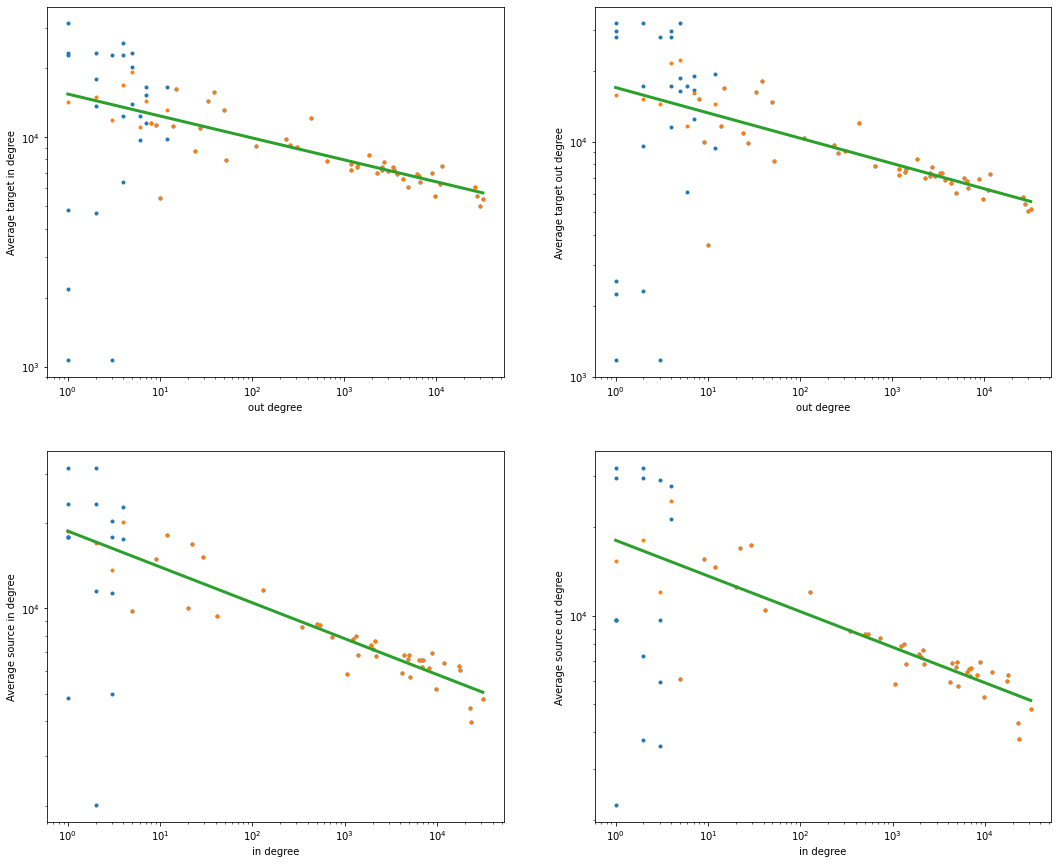

(-0.09567862679402746, -0.10766937303520784, -0.1268215594385636, -0.12154368544529677)


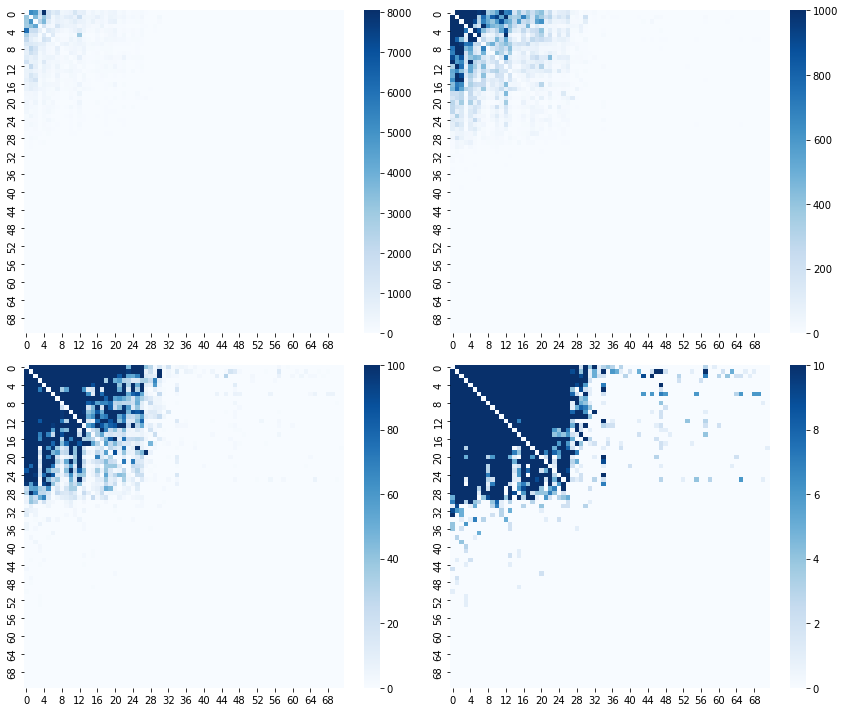

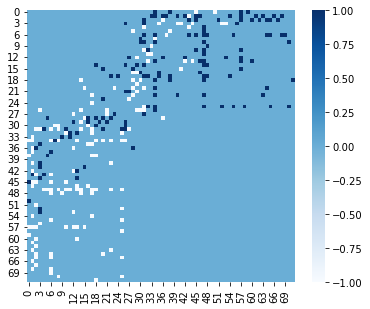

Nodes  Community
1                      Norway          0
2                     Romania          0
6                   Lithuania          0
11                      Malta          0
14                     Sweden          0
19                    Croatia          0
20                    Finland          0
22                     Serbia          0
25                   Slovenia          0
28                     Poland          0
29                    Hungary          0
31       Moldova, Republic of          0
33                      Italy          0
38                         EL          0
43                    Ukraine          0
45  Taiwan, Province of China          0
48                Netherlands          0
54              United States          0
55                      India          0
57                    Belgium          0
60                   Bulgaria          0
61                     Cyprus          0
62                    Estonia          0
65              Liechtenstein          0
69                    Czechia          0
71                 Luxembourg          0

Nodes  Community
0                Chile          1
4         South Africa          1
5                China          1
7               Canada          1
15             Iceland          1
16               Spain          1
17  Korea, Republic of          1
18             Austria          1
27           Argentina          1
30              Turkey          1
34         New Zealand          1
35           Singapore          1
40           Indonesia          1
42             Uruguay          1
44           Australia          1
47             Ireland          1
53           Hong Kong          1
66              Jordan          1
70                  UK          1

Nodes  Community
10                 Morocco          2
12  Bosnia and Herzegovina          2
13                  Israel          2
23              Kazakhstan          2
26                  Brazil          2
32                 Denmark          2
37                Portugal          2
41      Russian Federation          2
46                 Tunisia          2
50              Azerbaijan          2
51                 Germany          2
52                   Egypt          2
56                 Armenia          2
58                 Georgia          2

Nodes  Community
8      Nepal          3
9     Latvia          3
36  Malaysia          3
39     Japan          3
49   Algeria          3
59  Viet Nam          3
63   Belarus          3
64   Lebanon          3
68    France          3

Nodes  Community
3          Slovakia          4
21       Kyrgyzstan          4
24         Thailand          4
67  North Macedonia          4

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
17          Turkey                          7107650.0
26         Germany                          2625241.0
35  United Kingdom                          2263020.0
20           Italy                          1797986.0
9            Spain                          1491419.0
15          Poland                          1418588.0
25     Netherlands                           720583.0
22          Greece                           704969.0
7           Sweden                           438578.0
21        Portugal                           323467.0

country  weight_pr_hub
0            Malta   2.000000e-07
1    Liechtenstein   2.000000e-07
2       Luxembourg   2.000000e-07
3         Slovenia   1.461950e-07
4          Romania   1.458174e-07
5          Belgium   1.103613e-07
6        Lithuania   1.081824e-07
7          Estonia   1.071431e-07
8         Slovakia   1.054367e-07
9           Latvia   9.279777e-08
10         Czechia   8.766619e-08
11        Portugal   8.659352e-08
12           Spain   7.828899e-08
13         Ireland   7.065396e-08
14       Macedonia   6.588155e-08
15         Finland   6.434946e-08
16           Italy   5.264814e-08
17         Hungary   4.946756e-08
18         Denmark   4.570027e-08
19         Croatia   4.558587e-08
20         Germany   4.406799e-08
21     Netherlands   4.270612e-08
22        Bulgaria   3.558353e-08
23          Sweden   3.266394e-08
24          Norway   3.250385e-08
25          Poland   3.193459e-08
26  United Kingdom   2.164089e-08
27          Greece   2.088241e-08
28          Serbia   1.167707e-08
29          Turkey   6.560308e-09
30     Switzerland   0.000000e+00

country  weight_pr_aut
0            Malta   2.000000e-07
1       Luxembourg   2.000000e-07
2    Liechtenstein   2.000000e-07
3         Slovenia   1.747029e-07
4           Latvia   1.504565e-07
5          Estonia   1.484368e-07
6         Portugal   1.324825e-07
7          Belgium   1.140064e-07
8          Ireland   1.055553e-07
9        Lithuania   1.043529e-07
10         Finland   9.686751e-08
11         Czechia   9.515131e-08
12         Denmark   7.949865e-08
13           Spain   7.667993e-08
14          Sweden   7.443156e-08
15          Norway   7.321852e-08
16        Slovakia   7.199844e-08
17         Romania   7.093829e-08
18         Hungary   6.280841e-08
19     Netherlands   5.346593e-08
20       Macedonia   4.553254e-08
21         Croatia   4.304839e-08
22         Germany   3.966272e-08
23           Italy   3.673111e-08
24  United Kingdom   3.070285e-08
25          Poland   2.781247e-08
26        Bulgaria   2.027881e-08
27          Greece   1.462227e-08
28          Serbia   9.153143e-09
29          Turkey   3.630832e-09
30     Switzerland   0.000000e+00

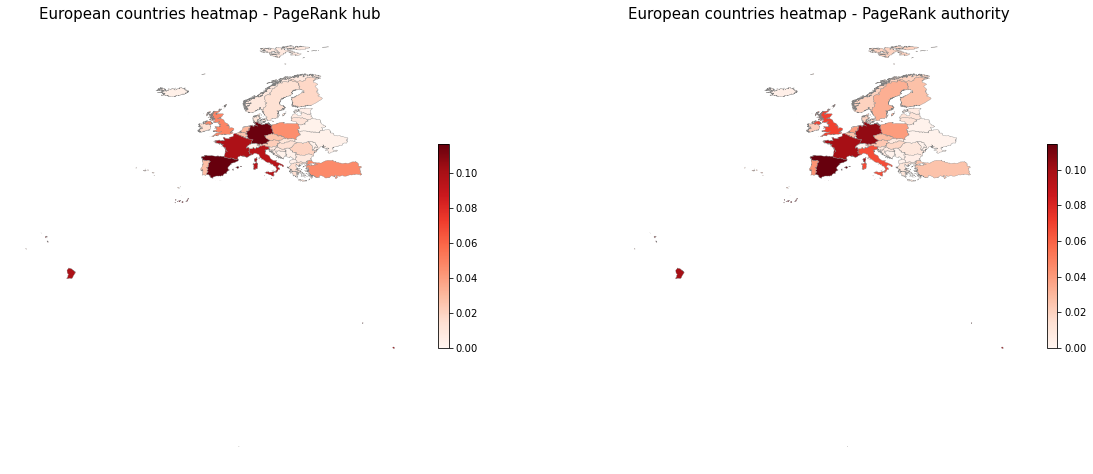

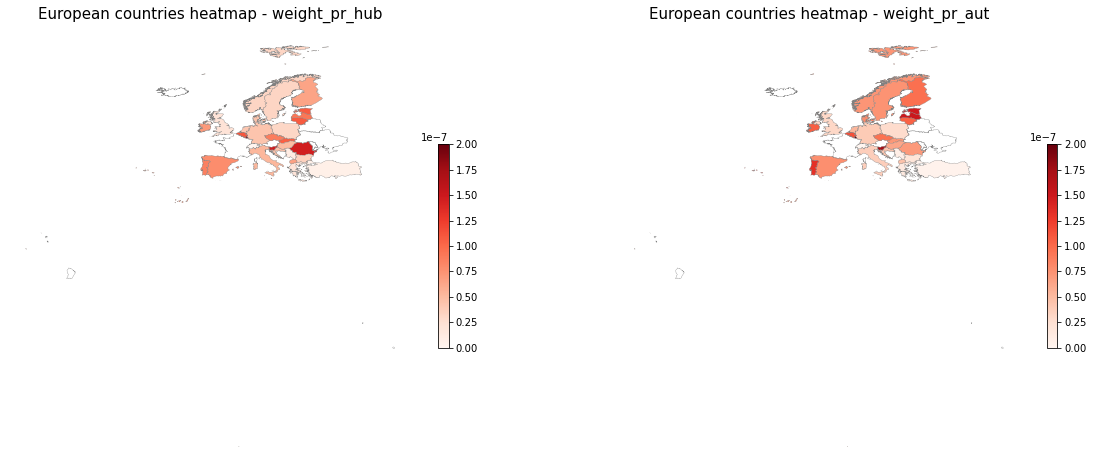

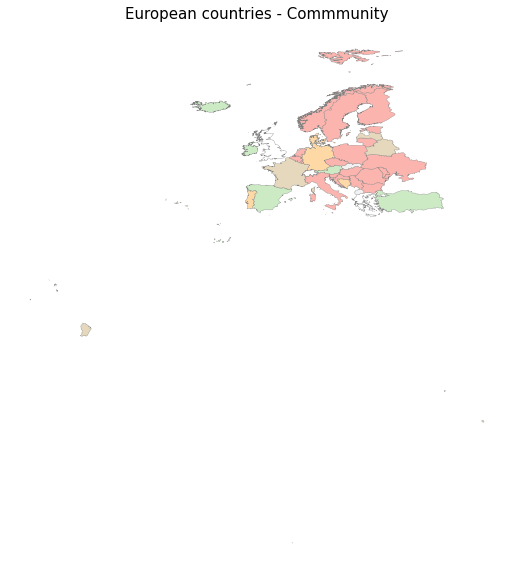

In [8]:
country15_df = pd.read_csv('data\Erasmus15.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country15_df)

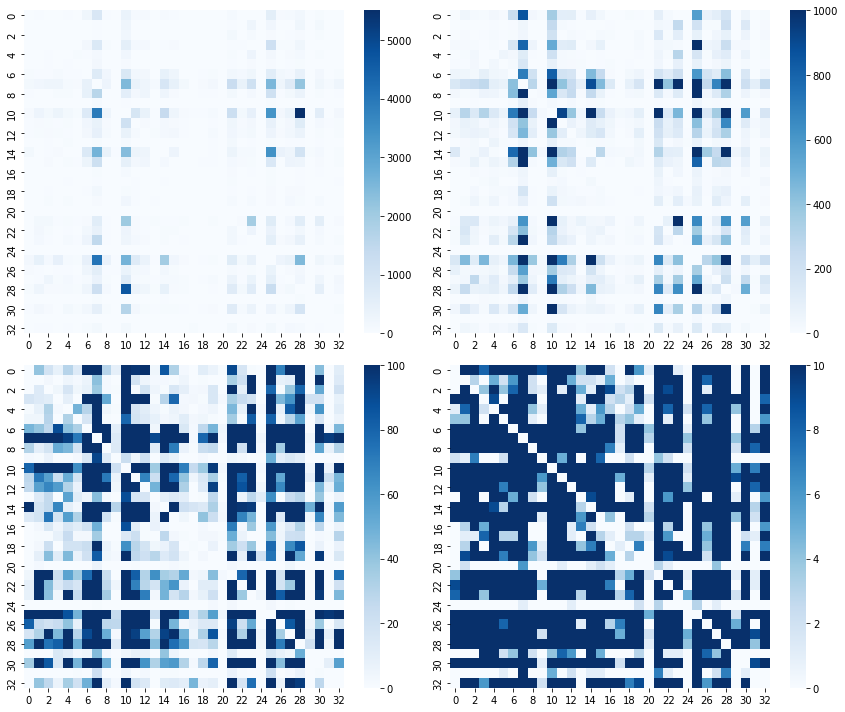

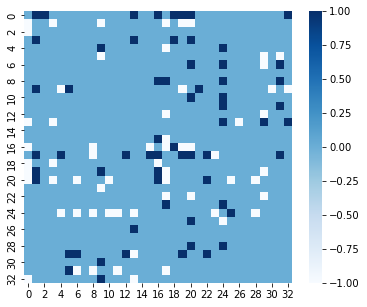

Number of components = 1


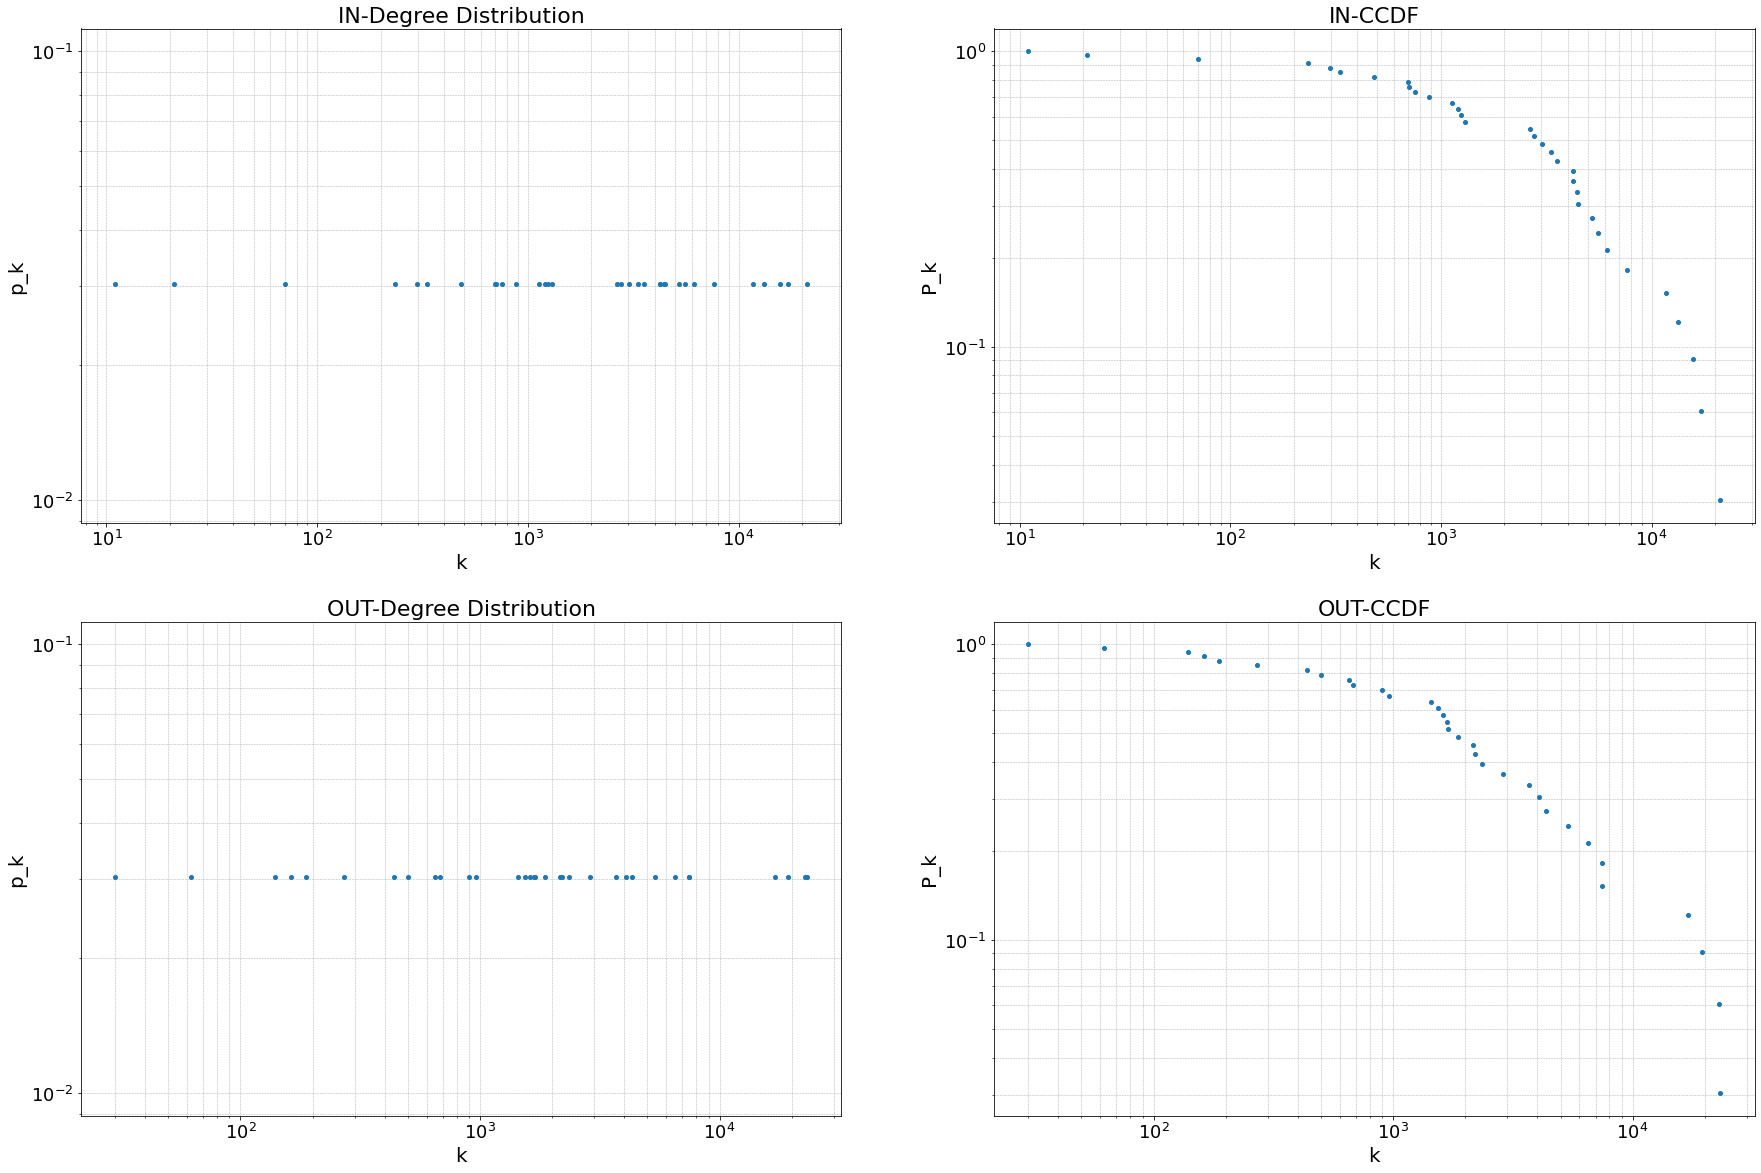

Top 10 for in degree


Nodes  in degree
10        Spain      21119
25       France      17250
7       Germany      15714
14           UK      13281
28        Italy      11699
21       Poland       7628
30     Portugal       6146
8        Sweden       5562
6   Netherlands       5232
15      Finland       4494

Top 10 for out degree


Nodes  out degree
10        Spain       23155
7       Germany       22824
25       France       19399
28        Italy       17047
21       Poland        7462
23       Turkey        7441
14           UK        6492
6   Netherlands        5390
11      Belgium        4330
27      Czechia        4066

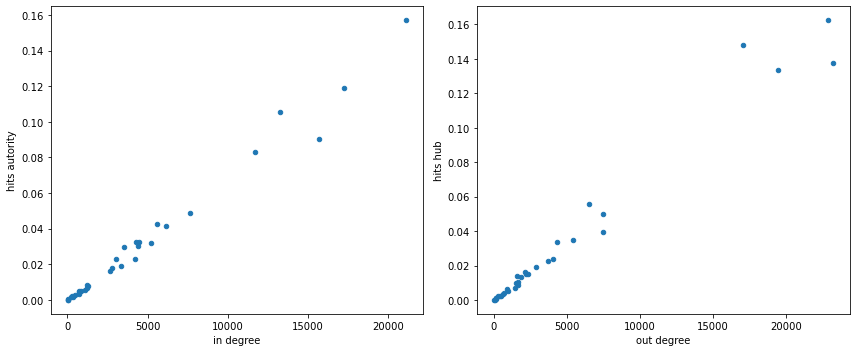

Top 10 for hits hub


Nodes  hits hub
7       Germany  0.162275
28        Italy  0.147887
10        Spain  0.137271
25       France  0.133438
14           UK  0.055983
21       Poland  0.050064
23       Turkey  0.039574
6   Netherlands  0.035035
11      Belgium  0.033543
27      Czechia  0.023626

Top 10 for hits autority


Nodes  hits autority
10     Spain       0.156956
25    France       0.118921
14        UK       0.105617
7    Germany       0.090148
28     Italy       0.082788
21    Poland       0.048618
8     Sweden       0.042787
30  Portugal       0.041566
15   Finland       0.032696
23    Turkey       0.032405

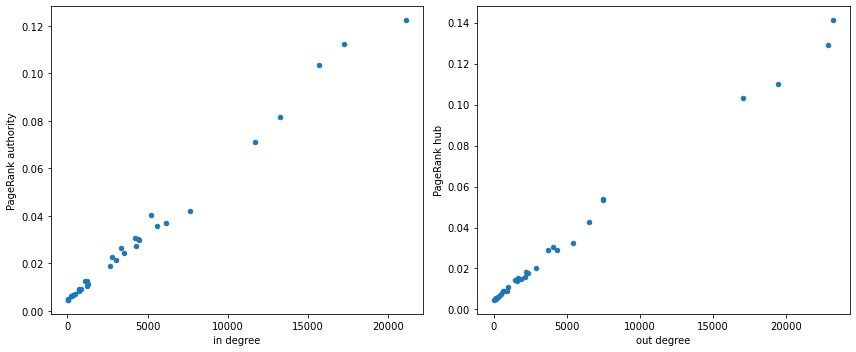

Top 10 for PageRank hub


Nodes  PageRank hub
10        Spain      0.141112
7       Germany      0.129106
25       France      0.110293
28        Italy      0.103348
21       Poland      0.054073
23       Turkey      0.053611
14           UK      0.042490
6   Netherlands      0.032353
27      Czechia      0.030299
30     Portugal      0.029030

Top 10 for PageRank authority


Nodes  PageRank authority
10        Spain            0.122351
25       France            0.112269
7       Germany            0.103498
14           UK            0.081532
28        Italy            0.070998
21       Poland            0.041874
6   Netherlands            0.040290
30     Portugal            0.036863
8        Sweden            0.035680
27      Czechia            0.030777

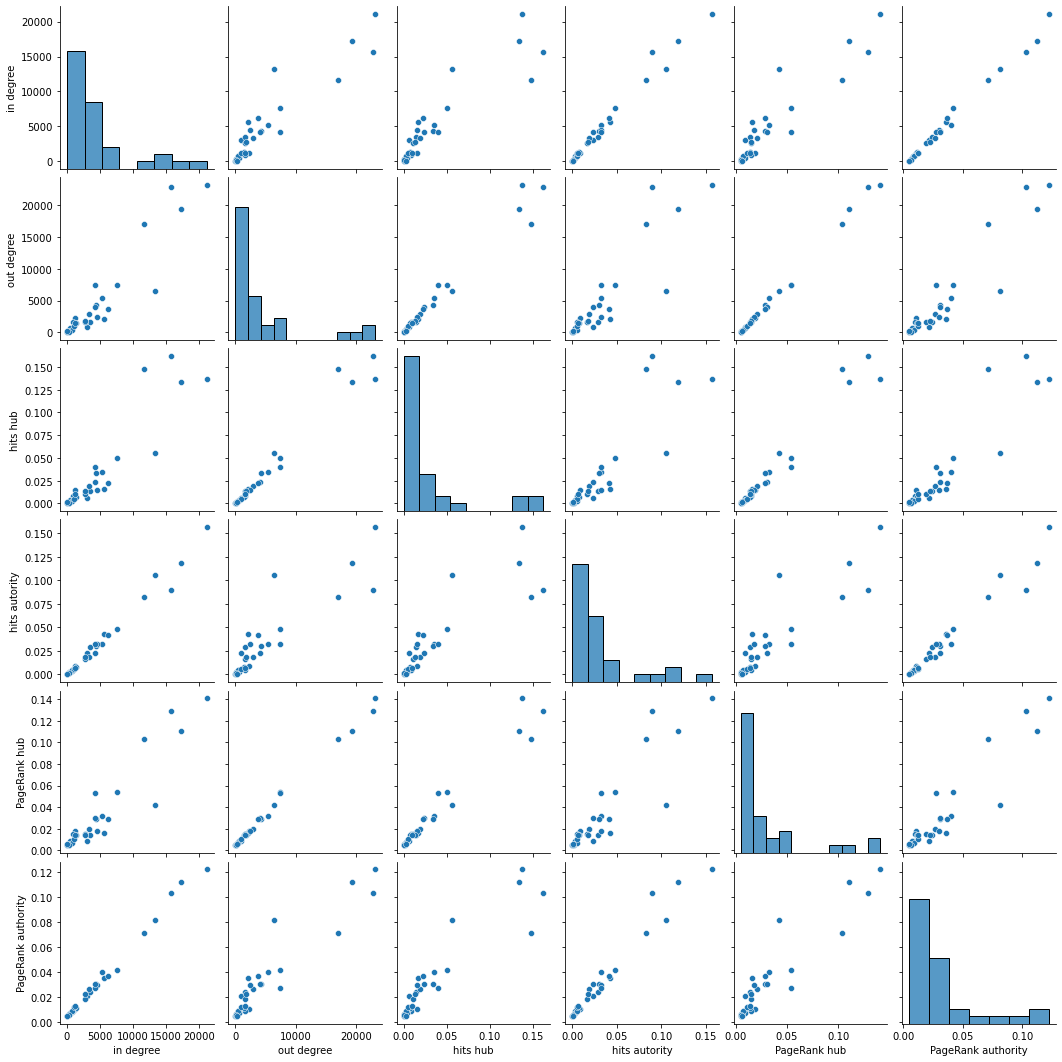

Nodes  in degree  in degree position  hits autority  \
10            Spain      21119                   1       0.156956   
25           France      17250                   2       0.118921   
7           Germany      15714                   3       0.090148   
14               UK      13281                   4       0.105617   
28            Italy      11699                   5       0.082788   
21           Poland       7628                   6       0.048618   
6       Netherlands       5232                   9       0.032177   
30         Portugal       6146                   7       0.041566   
8            Sweden       5562                   8       0.042787   
27          Czechia       4234                  13       0.023135   
11          Belgium       4413                  11       0.030519   
15          Finland       4494                  10       0.032696   
23           Turkey       4251                  12       0.032405   
12          Austria       3342                  15       0.019049   
3           Ireland       3545                  14       0.029458   
26          Denmark       2764                  17       0.018001   
0            Norway       3021                  16       0.023204   
22          Hungary       2648                  18       0.016353   
32               EL       1201                  21       0.006676   
19         Slovenia       1130                  22       0.005621   
4         Lithuania       1306                  19       0.007822   
1           Romania       1247                  20       0.008469   
2          Slovakia        882                  23       0.005118   
13          Croatia        697                  26       0.003269   
18          Estonia        756                  24       0.004975   
5            Latvia        704                  25       0.004647   
16         Bulgaria        483                  27       0.002911   
17           Cyprus        332                  28       0.001673   
9           Iceland        297                  29       0.002126   
29            Malta        234                  30       0.001527   
31       Luxembourg         70                  31       0.000613   
20    Liechtenstein         21                  32       0.000100   
24  North Macedonia         11                  33       0.000055   

    hits autority position  PageRank authority  PageRank authority position  
10                       1            0.122351                            1  
25                       2            0.112269                            2  
7                        4            0.103498                            3  
14                       3            0.081532                            4  
28                       5            0.070998                            5  
21                       6            0.041874                            6  
6                       11            0.040290                            7  
30                       8            0.036863                            8  
8                        7            0.035680                            9  
27                      15            0.030777                           10  
11                      12            0.030385                           11  
15                       9            0.029802                           12  
23                      10            0.027118                           13  
12                      16            0.026471                           14  
3                       13            0.024297                           15  
26                      17            0.022712                           16  
0                       14            0.021254                           17  
22                      18            0.018899                           18  
32                      21            0.012545                           19  
19                      22            0.012368                           20  
4                       20   

Nodes  out degree  out degree position  hits hub  \
10            Spain       23155                    1  0.137271   
7           Germany       22824                    2  0.162275   
25           France       19399                    3  0.133438   
28            Italy       17047                    4  0.147887   
21           Poland        7462                    5  0.050064   
23           Turkey        7441                    6  0.039574   
14               UK        6492                    7  0.055983   
6       Netherlands        5390                    8  0.035035   
27          Czechia        4066                   10  0.023626   
30         Portugal        3694                   11  0.022424   
11          Belgium        4330                    9  0.033543   
12          Austria        2887                   12  0.019040   
1           Romania        2196                   14  0.015245   
15          Finland        2360                   13  0.015171   
8            Sweden        2159                   15  0.016356   
2          Slovakia        1681                   18  0.008573   
22          Hungary        1692                   17  0.010578   
26          Denmark        1860                   16  0.013242   
4         Lithuania        1445                   21  0.006855   
32               EL        1539                   20  0.009965   
3           Ireland        1611                   19  0.013796   
19         Slovenia         958                   22  0.005292   
0            Norway         899                   23  0.006516   
16         Bulgaria         682                   24  0.004288   
5            Latvia         652                   25  0.003334   
13          Croatia         502                   26  0.002617   
18          Estonia         439                   27  0.002435   
31       Luxembourg         271                   28  0.002151   
17           Cyprus         162                   30  0.000952   
9           Iceland         188                   29  0.001245   
29            Malta         139                   31  0.000883   
24  North Macedonia          62                   32  0.000155   
20    Liechtenstein          30                   33  0.000191   

    hits hub position  PageRank hub  PageRank hub position  
10                  3      0.141112                      1  
7                   1      0.129106                      2  
25                  4      0.110293                      3  
28                  2      0.103348                      4  
21                  6      0.054073                      5  
23                  7      0.053611                      6  
14                  5      0.042490                      7  
6                   8      0.032353                      8  
27                 10      0.030299                      9  
30                 11      0.029030                     10  
11                  9      0.028949                     11  
12                 12      0.020286                     12  
1                  14      0.018381                     13  
15                 15      0.018006                     14  
8                  13      0.016049                     15  
2                  20      0.015143                     16  
22                 18      0.015005                     17  
26                 17      0.014631                     18  
4                  21      0.014240                     19  
32                 19      0.014236                     20  
3                  16      0.013981                     21  
19                 23      0.011038                     22  
0                  22      0.009230                     23  
16                 24      0.009153                     24  
5                  25      0.008935                     25  
13                 26      0.007738                     26  
18                 27      0.007054                     27  
31                 28      0.006142                     28  


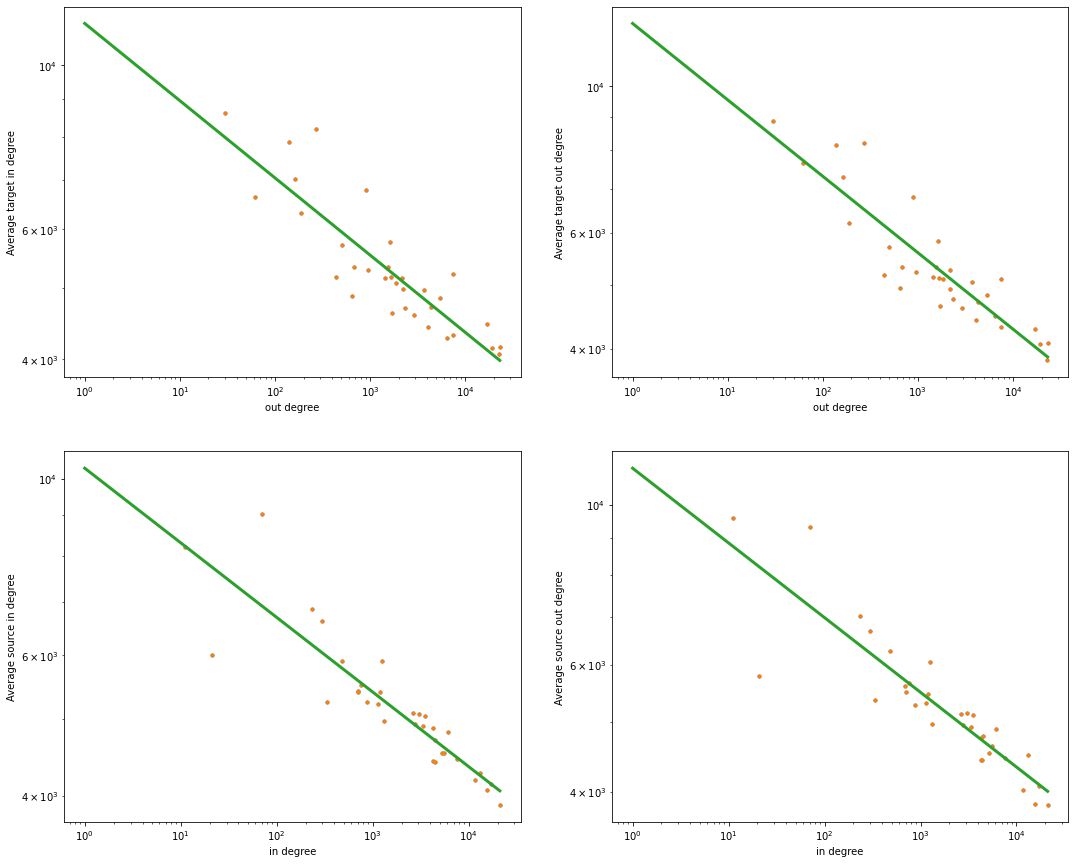

(-0.10455240865841625, -0.11594182711442622, -0.09360541404419462, -0.1037260967588432)


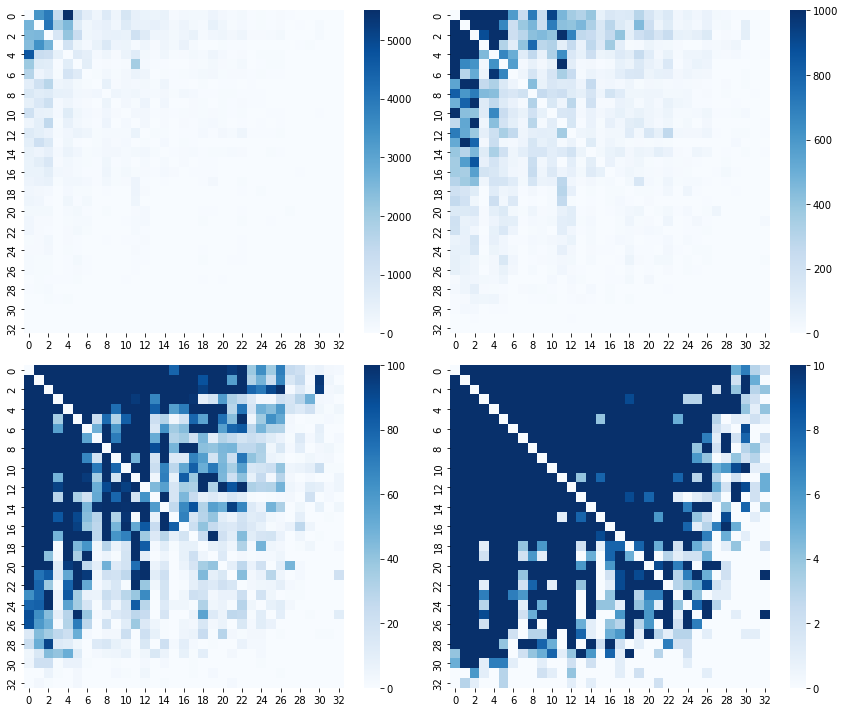

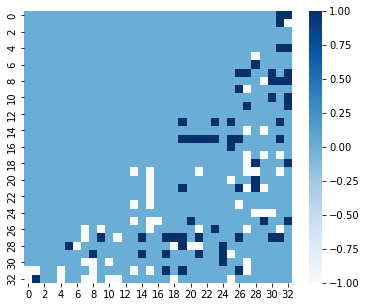

Nodes  Community
0          Norway          0
1         Romania          0
2        Slovakia          0
5          Latvia          0
9         Iceland          0
10          Spain          0
11        Belgium          0
14             UK          0
15        Finland          0
16       Bulgaria          0
17         Cyprus          0
18        Estonia          0
20  Liechtenstein          0
21         Poland          0
22        Hungary          0
25         France          0
28          Italy          0
30       Portugal          0
31     Luxembourg          0
32             EL          0

Nodes  Community
3           Ireland          1
4         Lithuania          1
6       Netherlands          1
7           Germany          1
8            Sweden          1
12          Austria          1
13          Croatia          1
19         Slovenia          1
23           Turkey          1
24  North Macedonia          1
26          Denmark          1
27          Czechia          1
29            Malta          1

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
22          Turkey                          7107650.0
7          Germany                          2625241.0
14  United Kingdom                          2263020.0
27           Italy                          1797986.0
10           Spain                          1491419.0
20          Poland                          1418588.0
6      Netherlands                           720583.0
31          Greece                           704969.0
8           Sweden                           438578.0
29        Portugal                           323467.0

country  weight_pr_hub
0       Luxembourg   2.000000e-07
1            Malta   2.000000e-07
2    Liechtenstein   2.000000e-07
3         Slovenia   2.000000e-07
4          Estonia   1.561997e-07
5          Romania   1.363381e-07
6         Slovakia   1.352762e-07
7          Belgium   1.255014e-07
8        Lithuania   1.244512e-07
9           Latvia   1.142395e-07
10       Macedonia   1.030193e-07
11         Czechia   1.021499e-07
12           Spain   9.461599e-08
13        Portugal   8.974626e-08
14         Ireland   6.955643e-08
15         Finland   6.508419e-08
16           Italy   5.748009e-08
17         Denmark   5.683028e-08
18         Hungary   5.394088e-08
19         Germany   4.917889e-08
20         Croatia   4.826007e-08
21     Netherlands   4.489903e-08
22        Bulgaria   3.943778e-08
23          Poland   3.811757e-08
24          Sweden   3.659371e-08
25          Norway   3.424649e-08
26          Greece   2.019327e-08
27  United Kingdom   1.877573e-08
28          Turkey   7.542693e-09
29     Switzerland   0.000000e+00

country  weight_pr_aut
0       Luxembourg   2.000000e-07
1    Liechtenstein   2.000000e-07
2         Slovenia   2.000000e-07
3            Malta   2.000000e-07
4          Estonia   1.926244e-07
5          Belgium   1.317276e-07
6          Ireland   1.208751e-07
7         Portugal   1.139634e-07
8          Finland   1.077198e-07
9           Latvia   1.052956e-07
10         Czechia   1.037606e-07
11       Lithuania   9.924275e-08
12       Macedonia   9.451786e-08
13         Denmark   8.822145e-08
14        Slovakia   8.342777e-08
15           Spain   8.203669e-08
16          Sweden   8.135302e-08
17          Norway   7.885817e-08
18         Romania   7.843321e-08
19         Hungary   6.793889e-08
20         Croatia   5.765418e-08
21     Netherlands   5.591304e-08
22           Italy   3.948754e-08
23         Germany   3.942410e-08
24  United Kingdom   3.602784e-08
25        Bulgaria   3.083430e-08
26          Poland   2.951780e-08
27          Greece   1.779566e-08
28          Turkey   3.815350e-09
29     Switzerland   0.000000e+00

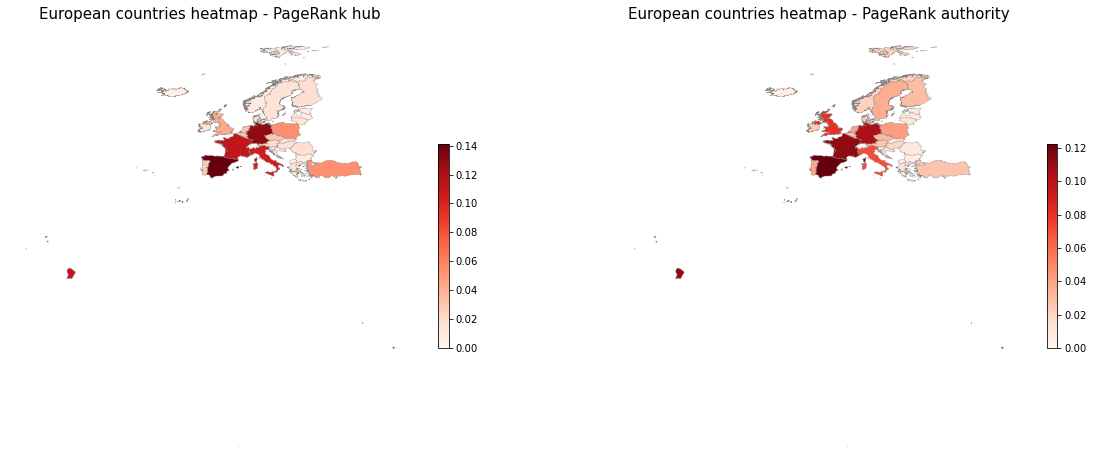

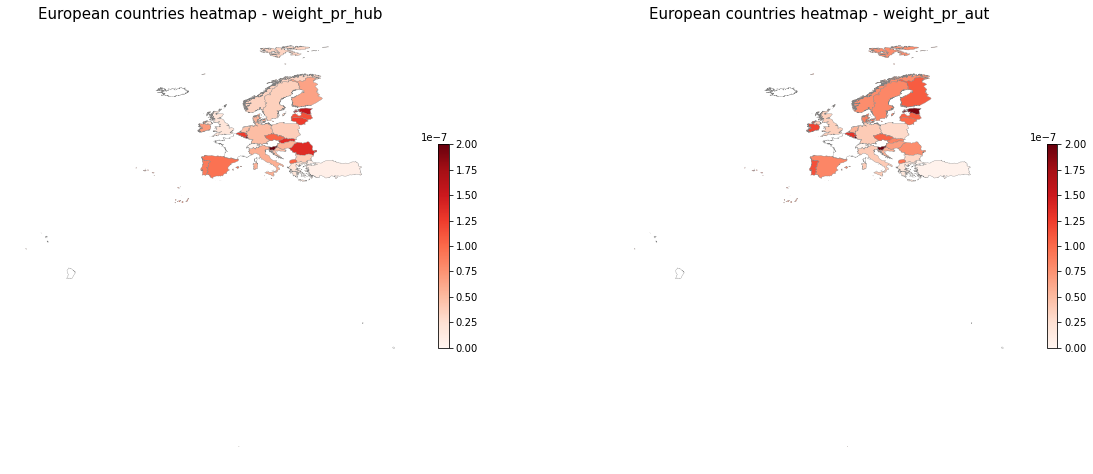

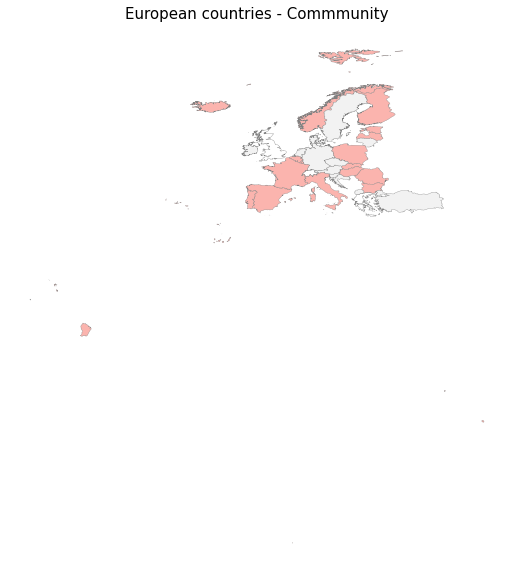

In [9]:
country14_df = pd.read_csv('data\Erasmus14.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country14_df)

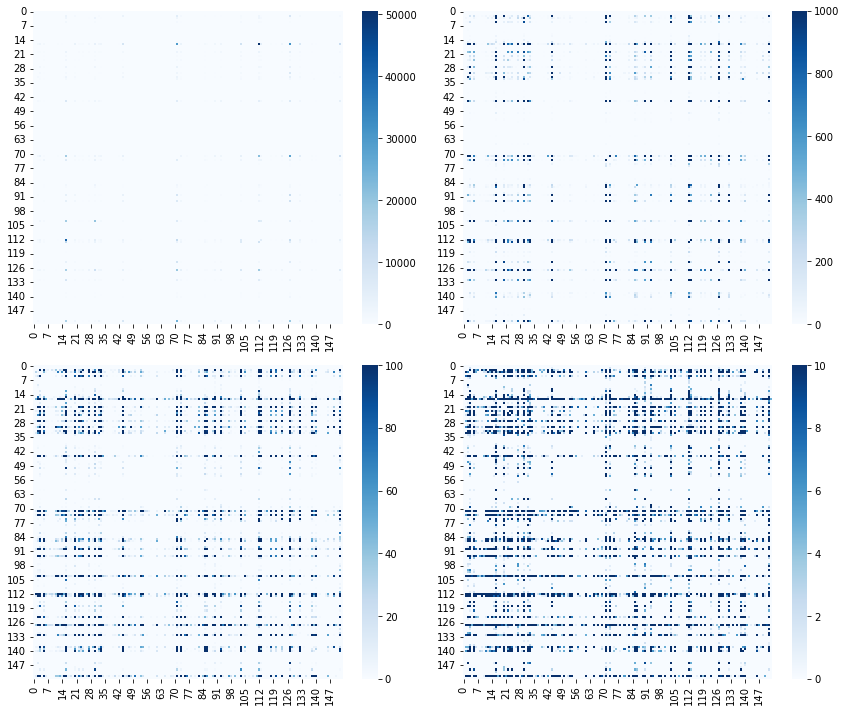

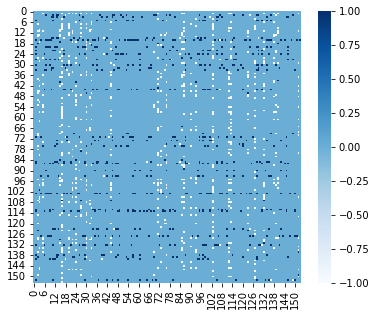

Number of components = 2


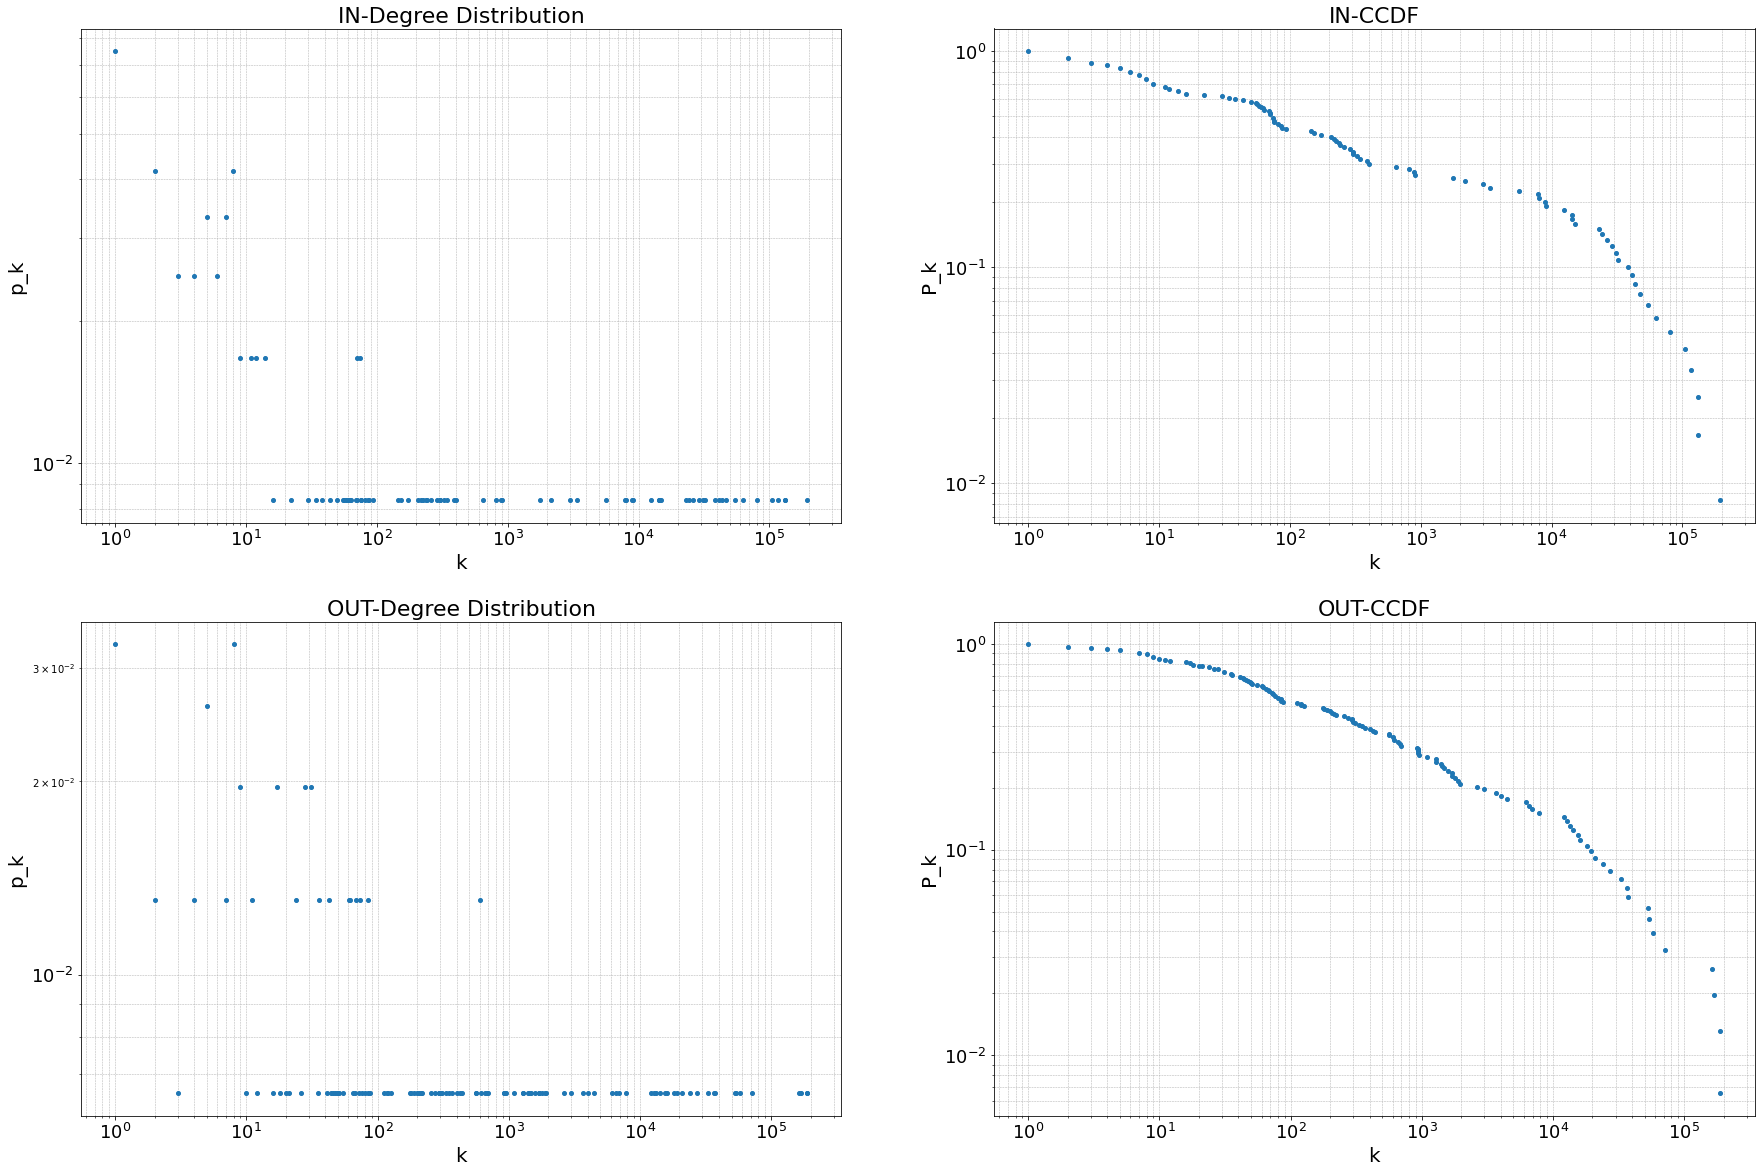

Top 10 for in degree


Nodes  in degree
16         Spain     193628
127      Germany     131451
71        France     130821
112        Italy     116180
152           UK     103962
103       Poland      79774
113     Portugal      63268
44   Netherlands      54828
90        Sweden      47028
73       Czechia      43532

Top 10 for out degree


Nodes  out degree
127      Germany      187627
16         Spain      186670
71        France      168162
112        Italy      162235
30        Turkey       71621
103       Poland       58299
152           UK       53862
44   Netherlands       53340
132      Belgium       37427
113     Portugal       36678

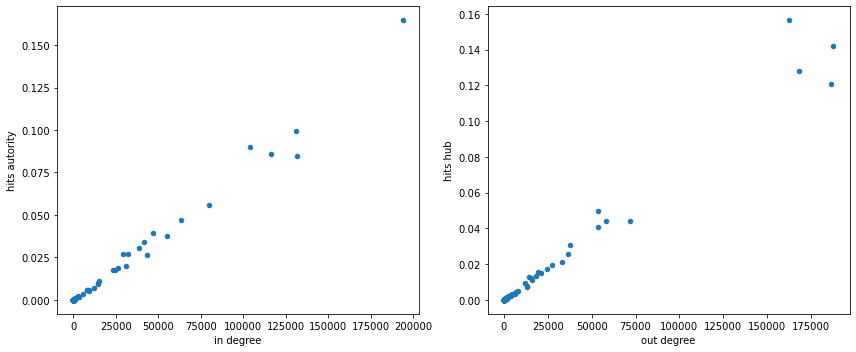

Top 10 for hits hub


Nodes  hits hub
112        Italy  0.156293
127      Germany  0.141831
71        France  0.128110
16         Spain  0.120733
152           UK  0.049901
103       Poland  0.044319
30        Turkey  0.043977
44   Netherlands  0.040685
132      Belgium  0.030840
113     Portugal  0.025639

Top 10 for hits autority


Nodes  hits autority
16         Spain       0.164556
71        France       0.099586
152           UK       0.089991
112        Italy       0.085836
127      Germany       0.084588
103       Poland       0.056051
113     Portugal       0.046731
90        Sweden       0.039643
44   Netherlands       0.037504
93       Finland       0.033788

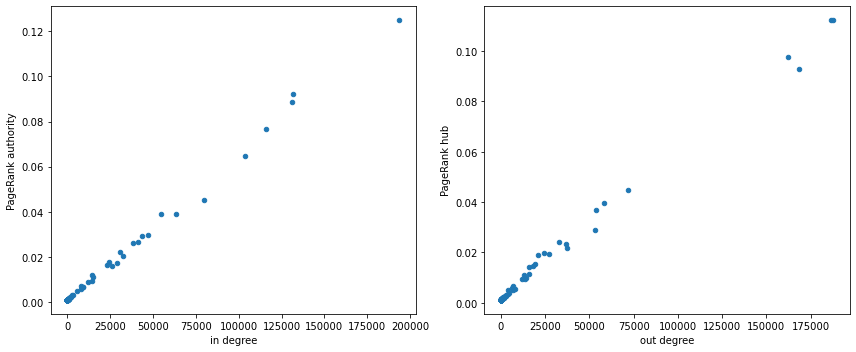

Top 10 for PageRank hub


Nodes  PageRank hub
127      Germany      0.112138
16         Spain      0.112125
112        Italy      0.097475
71        France      0.092776
30        Turkey      0.044988
103       Poland      0.039472
152           UK      0.036884
44   Netherlands      0.028761
73       Czechia      0.024009
113     Portugal      0.023171

Top 10 for PageRank authority


Nodes  PageRank authority
16         Spain            0.124839
127      Germany            0.092253
71        France            0.088529
112        Italy            0.076540
152           UK            0.064553
103       Poland            0.045153
113     Portugal            0.039174
44   Netherlands            0.038861
90        Sweden            0.029709
73       Czechia            0.029178

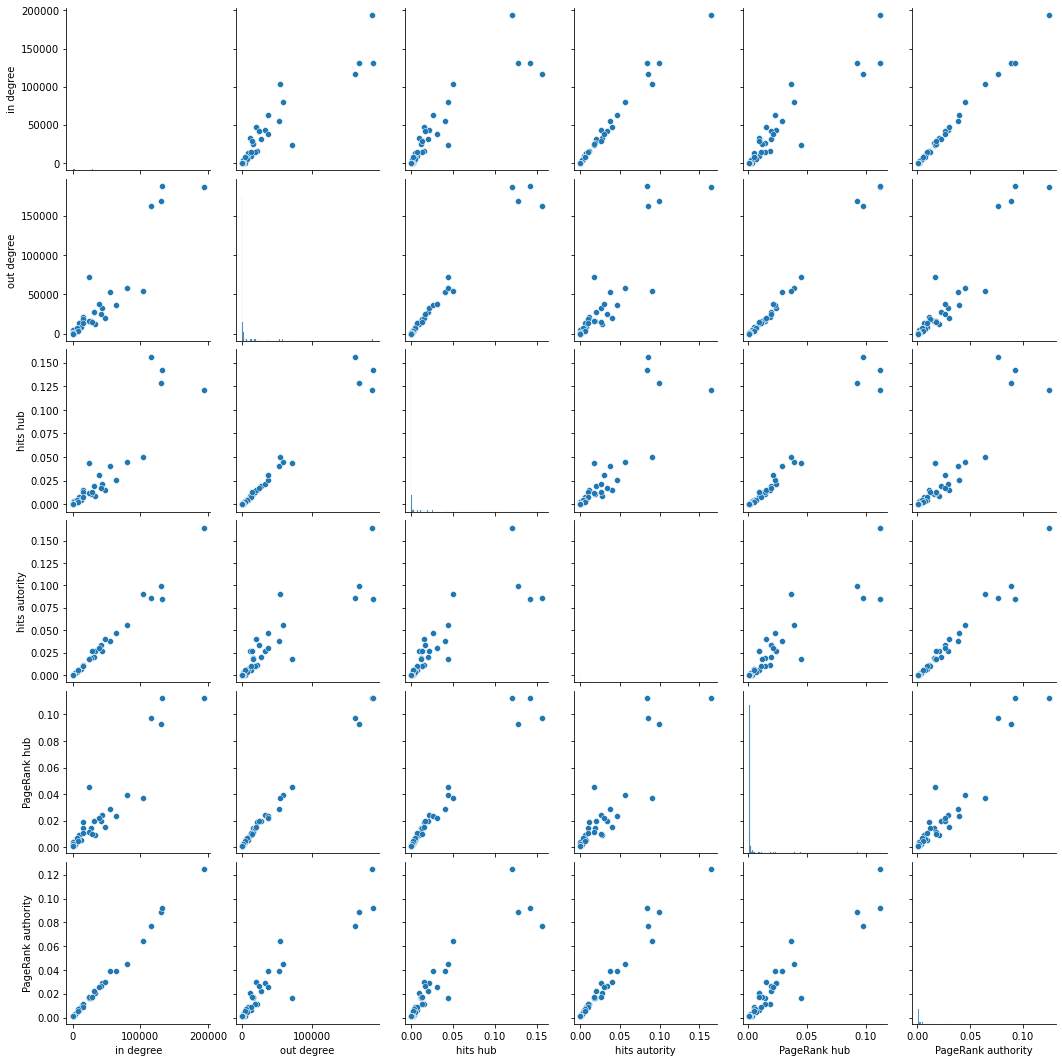

Nodes  in degree  in degree position  hits autority  \
16                    Spain     193628                   1       0.164556   
127                 Germany     131451                   2       0.084588   
71                   France     130821                   3       0.099586   
112                   Italy     116180                   4       0.085836   
152                      UK     103962                   5       0.089991   
103                  Poland      79774                   6       0.056051   
113                Portugal      63268                   7       0.046731   
44              Netherlands      54828                   8       0.037504   
90                   Sweden      47028                   9       0.039643   
73                  Czechia      43532                  10       0.026612   
93                  Finland      41491                  11       0.033788   
132                 Belgium      38404                  12       0.030425   
20                  Austria      30949                  14       0.020008   
2                    Norway      32344                  13       0.027140   
32                  Denmark      24228                  17       0.017316   
123                 Ireland      28897                  15       0.026713   
30                   Turkey      23039                  18       0.017419   
27                  Hungary      26280                  16       0.018527   
33                       EL      14333                  20       0.009585   
3                   Romania      14966                  19       0.011204   
85                Lithuania      14273                  21       0.009962   
24                 Slovenia      12383                  22       0.007141   
86                   Latvia       8064                  25       0.006076   
22                  Croatia       9059                  23       0.005239   
5                  Slovakia       8950                  24       0.005978   
140                 Estonia       7844                  26       0.005851   
138                Bulgaria       5609                  27       0.003485   
139                  Cyprus       3364                  28       0.001827   
15                  Iceland       2995                  29       0.002287   
75                    Malta       2161                  30       0.001473   
118      Russian Federation       1758                  31       0.001265   
89                   Israel        892                  33       0.000605   
23                   Serbia        908                  32       0.000602   
76               Luxembourg        812                  34       0.000725   
50            United States        643                  35       0.000460   
84                   Canada        401                  36       0.000289   
82                    China        302                  41       0.000125   
149         North Macedonia        390                  37       0.000238   
14   Bosnia and Herzegovina        345                  38       0.000210   
116                   Japan        326                  39       0.000264   

     hits autority position  PageRank authority  PageRank authority position  
16                        1            0.124839                            1  
127                       5            0.092253                            2  
71                        2            0.088529                            3  
112                       4            0.076540                            4  
152                       3            0.064553                            5  
103                       6            0.045153                            6  
113                       7            0.039174                            7  
44                        9            0.038861                            8  
90                        8            0.029709                            9  
73                       14            0.029178                           

Nodes  out degree  out degree position  hits hub  \
127                 Germany      187627                    1  0.141831   
16                    Spain      186670                    2  0.120733   
112                   Italy      162235                    4  0.156293   
71                   France      168162                    3  0.128110   
30                   Turkey       71621                    5  0.043977   
103                  Poland       58299                    6  0.044319   
152                      UK       53862                    7  0.049901   
44              Netherlands       53340                    8  0.040685   
73                  Czechia       32912                   11  0.021089   
113                Portugal       36678                   10  0.025639   
132                 Belgium       37427                    9  0.030840   
93                  Finland       24264                   13  0.017102   
20                  Austria       27204                   12  0.019678   
3                   Romania       21012                   14  0.014906   
90                   Sweden       19337                   15  0.015423   
33                       EL       18254                   16  0.013360   
27                  Hungary       16068                   17  0.011245   
32                  Denmark       15651                   18  0.012205   
85                Lithuania       12867                   21  0.007240   
123                 Ireland       14255                   19  0.012791   
5                  Slovakia       13370                   20  0.007605   
2                    Norway       12075                   22  0.009214   
138                Bulgaria        6558                   25  0.004334   
86                   Latvia        6178                   26  0.003345   
24                 Slovenia        7847                   23  0.004957   
22                  Croatia        6937                   24  0.004517   
140                 Estonia        3696                   29  0.002296   
118      Russian Federation        4500                   27  0.003247   
120                 Ukraine        4025                   28  0.002819   
23                   Serbia        2962                   30  0.002150   
76               Luxembourg        2653                   31  0.002165   
53                  Georgia        1893                   33  0.001299   
12                  Morocco        1939                   32  0.001774   
139                  Cyprus        1714                   35  0.000830   
82                    China        1796                   34  0.001301   
42                  Tunisia        1708                   36  0.001601   
14   Bosnia and Herzegovina        1584                   37  0.001099   
149         North Macedonia        1290                   41  0.000470   
105                 Albania        1438                   39  0.000992   
89                   Israel        1277                   42  0.000881   

     hits hub position  PageRank hub  PageRank hub position  
127                  2      0.112138                      1  
16                   4      0.112125                      2  
112                  1      0.097475                      3  
71                   3      0.092776                      4  
30                   7      0.044988                      5  
103                  6      0.039472                      6  
152                  5      0.036884                      7  
44                   8      0.028761                      8  
73                  11      0.024009                      9  
113                 10      0.023171                     10  
132                  9      0.021710                     11  
93                  13      0.019637                     12  
20                  12      0.019579                     13  
3                   15      0.019101                     14  
90                  14      0.015339                     

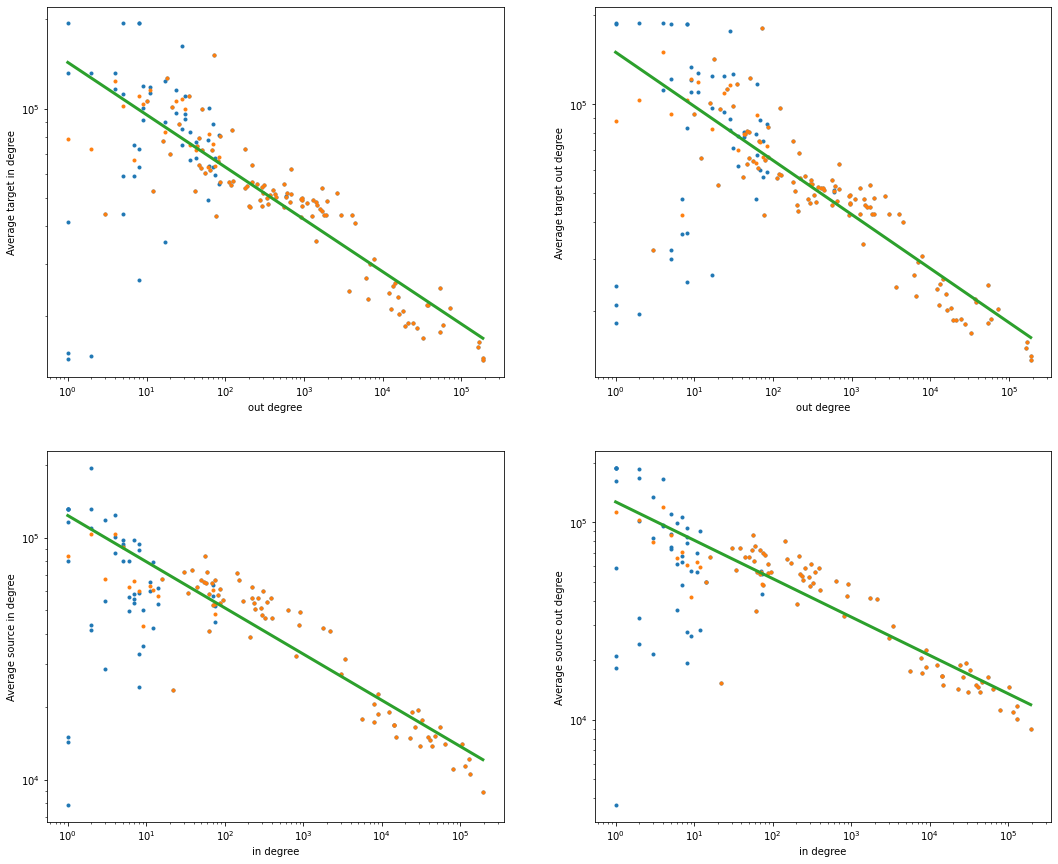

(-0.17644093588481982, -0.1826865894999842, -0.1908311792419887, -0.19417524253887586)


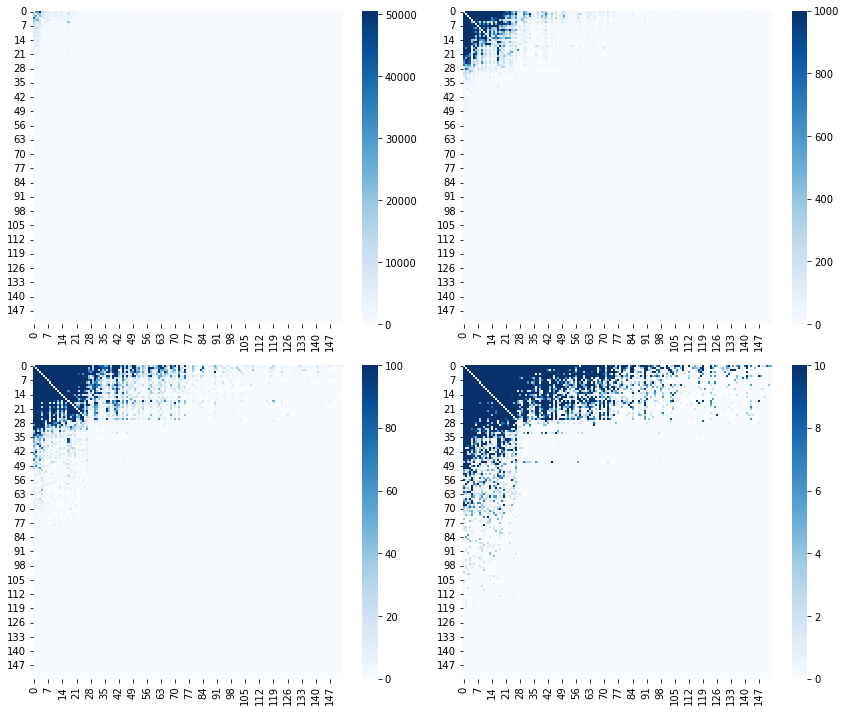

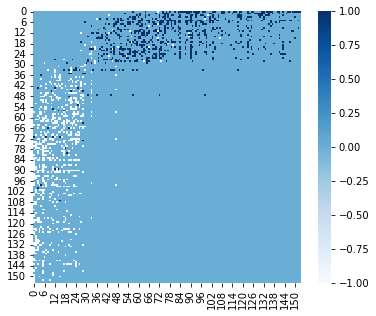

Nodes  Community
1                Uzbekistan          0
3                   Romania          0
5                  Slovakia          0
12                  Morocco          0
14   Bosnia and Herzegovina          0
..                      ...        ...
138                Bulgaria          0
140                 Estonia          0
147                   Gabon          0
148     Trinidad and Tobago          0
149         North Macedonia          0

[51 rows x 2 columns]

Nodes  Community
4             Iraq          1
6     South Africa          1
10          Uganda          1
11              XK          1
17        Colombia          1
..             ...        ...
135     Bangladesh          1
141         Rwanda          1
143        Burundi          1
150       Paraguay          1
151  Côte d'Ivoire          1

[45 rows x 2 columns]

Nodes  Community
2                              Norway          2
7                            Ethiopia          2
8                             Myanmar          2
13                Palestine, State of          2
20                            Austria          2
23                             Serbia          2
31                            Jamaica          2
40                          Australia          2
43                           Barbados          2
46                          Hong Kong          2
47                              Egypt          2
53                            Georgia          2
54                           Viet Nam          2
68                             Zambia          2
69                      Liechtenstein          2
70                             Malawi          2
75                              Malta          2
76                         Luxembourg          2
80                           Pakistan          2
89                             Israel          2
90                             Sweden          2
93                            Finland          2
98                           Thailand          2
115                             Ghana          2
118                Russian Federation          2
119                           Uruguay          2
120                           Ukraine          2
123                           Ireland          2
124   Bolivia, Plurinational State of          2
133                          Zimbabwe          2
136      Tanzania, United Republic of          2
139                            Cyprus          2
145  Lao People's Democratic Republic          2
152                                UK          2

Nodes  Community
15             Iceland          3
16               Spain          3
26           Argentina          3
37             Nigeria          3
64                Togo          3
73             Czechia          3
82               China          3
92   Equatorial Guinea          3
96         Afghanistan          3
102         Costa Rica          3
121             Belize          3
122   Papua New Guinea          3
142        El Salvador          3
146             Jordan          3
153         Mauritania          3

Nodes  Community
9       Nepal          4
36      Kenya          4
45    Algeria          4
58   Honduras          4
86     Latvia          4
88     Panama          4
125   Lesotho          4
144     Libya          4

Nodes  Community
0   nan          5

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
13          Turkey                          7107650.0
34         Germany                          2625241.0
39  United Kingdom                          2263020.0
30           Italy                          1797986.0
6            Spain                          1491419.0
28          Poland                          1418588.0
16     Netherlands                           720583.0
15          Greece                           704969.0
25          Sweden                           438578.0
31        Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.436605e-07
3          Romania   1.416776e-07
4          Estonia   1.091404e-07
5         Slovenia   1.060772e-07
6        Lithuania   9.576885e-08
7          Belgium   9.411755e-08
8         Slovakia   8.501996e-08
9          Czechia   8.094202e-08
10          Latvia   7.568011e-08
11           Spain   7.517994e-08
12        Portugal   7.163195e-08
13         Finland   7.097819e-08
14           Italy   5.421317e-08
15         Hungary   5.164213e-08
16         Ireland   4.854750e-08
17       Macedonia   4.571612e-08
18         Denmark   4.514084e-08
19         Germany   4.271524e-08
20     Netherlands   3.991404e-08
21          Sweden   3.497513e-08
22          Norway   3.442421e-08
23         Croatia   3.306144e-08
24        Bulgaria   2.858916e-08
25          Poland   2.782512e-08
26          Greece   2.051796e-08
27  United Kingdom   1.629872e-08
28         Albania   1.608158e-08
29          Serbia   1.277912e-08
30          Turkey   6.329569e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.851544e-07
3         Slovenia   1.708349e-07
4          Estonia   1.234076e-07
5         Portugal   1.211056e-07
6          Belgium   1.128108e-07
7          Czechia   9.837169e-08
8          Finland   9.590120e-08
9           Latvia   9.280425e-08
10         Ireland   8.696108e-08
11           Spain   8.370455e-08
12         Romania   8.249194e-08
13       Lithuania   7.999926e-08
14          Norway   7.534802e-08
15         Denmark   6.878679e-08
16          Sweden   6.773854e-08
17        Slovakia   5.815819e-08
18         Hungary   5.775969e-08
19     Netherlands   5.393050e-08
20           Italy   4.256987e-08
21         Croatia   4.082327e-08
22         Germany   3.514081e-08
23          Poland   3.182963e-08
24  United Kingdom   2.852515e-08
25       Macedonia   2.399950e-08
26        Bulgaria   2.106220e-08
27          Greece   1.673973e-08
28         Albania   7.942546e-09
29          Serbia   6.320501e-09
30          Turkey   2.297469e-09
31     Switzerland   0.000000e+00

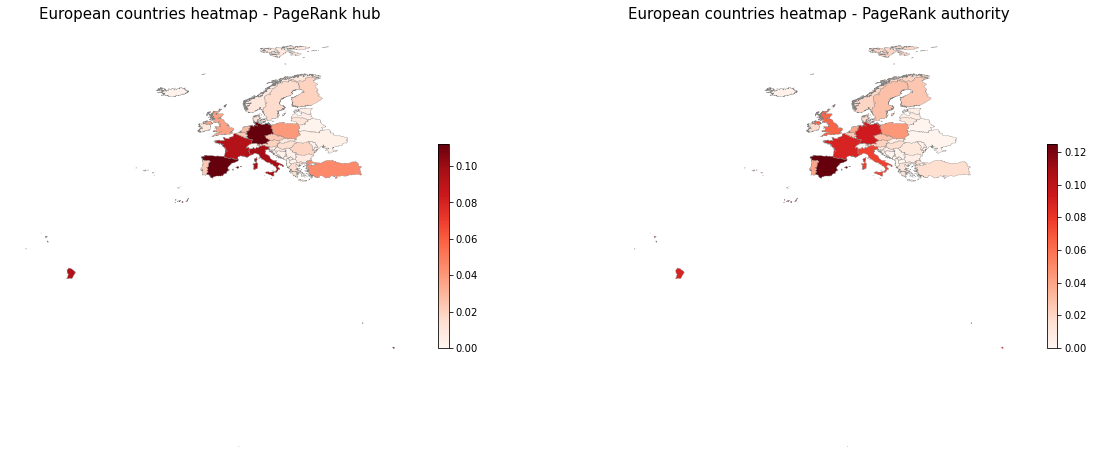

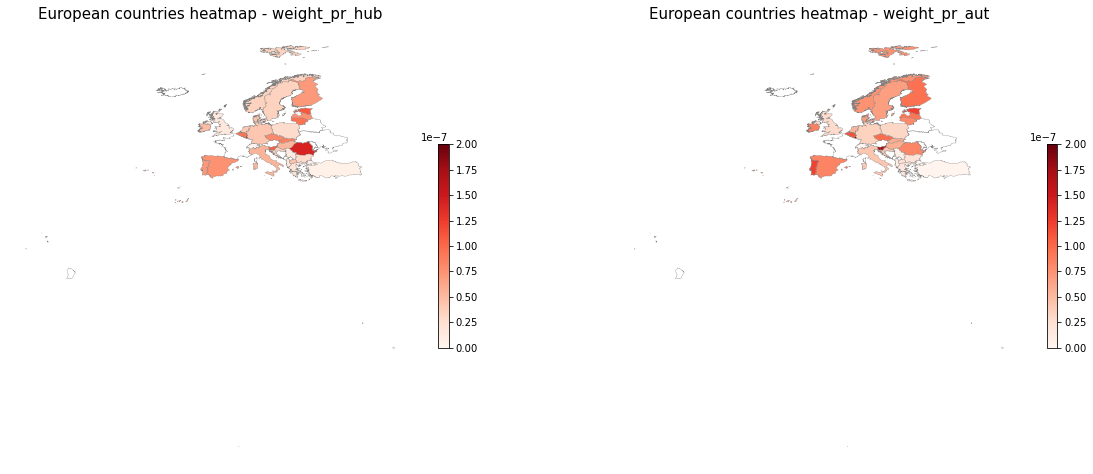

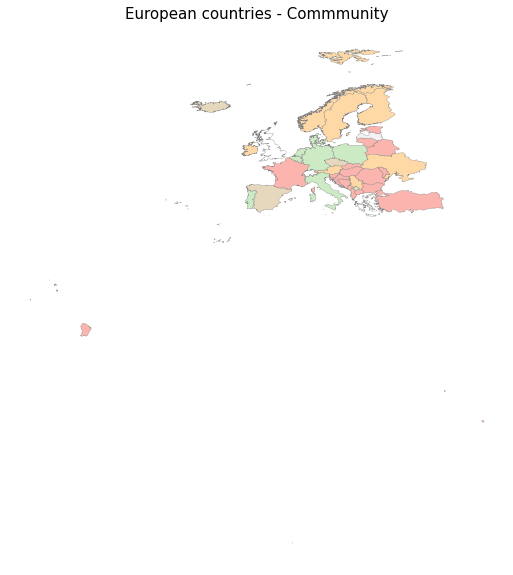

In [10]:
country_df = country19_df.append(country18_df)
country_df = country_df.append(country17_df)
country_df = country_df.append(country16_df)
country_df = country_df.append(country15_df)
country_df = country_df.append(country14_df)
analysis(country_df)